<a href="https://colab.research.google.com/github/Christoph2209/2022_Spring_CS_249/blob/main/Group_2_Curriculum_Learning_Alogrithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Due to RAM requirements, please run this notebook using the A100 GPU.

In [ ]:
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from transformers import ViTConfig, ViTForImageClassification, ViTFeatureExtractor, Trainer, TrainingArguments
import io

Download the photo files

In [ ]:
from kagglehub import dataset_download

# Download latest version
path = dataset_download("sharansmenon/inat2021birds")
print("Path to dataset files:", path)

100%|██████████| 5.11G/5.11G [03:50<00:00, 23.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sharansmenon/inat2021birds/versions/1


This is the function that collects a random assortment of pictures from the dataset iNaturalist: then once selected the images are then changed to be a static 250x250 size

In [ ]:
from PIL import Image
import os
import pandas as pd
import random
import shutil
from torchvision import datasets, transforms

# Set Random Seed
random.seed(6350122)

def apply_transform_and_save(image_path, save_path):
    """Applies transformations to a single image and saves it."""
    transform = transforms.Compose([
        transforms.Resize((250, 250)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    img = Image.open(image_path)
    img = transform(img)
    img_pil = transforms.ToPILImage()(img)
    img_pil.save(save_path)

def split_and_transform_images(src_path, dest_path, sizes=[1 * 1024 * 1024, 10 * 1024 * 1024, 100 * 1024 * 1024, 1 * 1024 * 1024 * 1024]):
    """
    Splits image data into different size categories and applies transformations.
    Saves transformed images separately and returns updated DataFrames.
    """
    # Initialize data structures
    dataframes = {size: pd.DataFrame(columns=['filename', 'label', 'image_size']) for size in sizes}
    current_size = {size: 0 for size in sizes}

    # Load dataset metadata (but not images)
    dataset = datasets.ImageFolder(src_path)
    file_list = [(img_path, dataset.classes[label]) for img_path, label in dataset.imgs]
    random.shuffle(file_list)  # Shuffle files

    os.makedirs(dest_path, exist_ok=True)

    for filename, label in file_list:
        image_size = os.path.getsize(filename)

        for size in sizes:
            if current_size[size] + image_size <= size:
                # Define class folder for transformed images
                class_folder = os.path.join(dest_path, label)
                os.makedirs(class_folder, exist_ok=True)
                # Save transformed image
                transformed_path = os.path.join(class_folder, os.path.basename(filename))
                apply_transform_and_save(filename, transformed_path)

                # Update DataFrame with transformed image path
                dataframes[size].loc[len(dataframes[size])] = [transformed_path, label, image_size]
                current_size[size] += image_size
                break  # Move to next image

    return dataframes

# Define paths
transformed_dataset_path = "/content/training_pictures"

if os.path.exists(transformed_dataset_path):
    shutil.rmtree(transformed_dataset_path)  # Remove pre-existing transformed images

# Split and transform images for all size categories
dataframes_by_size = split_and_transform_images(path+"/bird_train", transformed_dataset_path)

# Access transformed data
df_1MB = dataframes_by_size[1 * 1024 * 1024]
df_10MB = dataframes_by_size[10 * 1024 * 1024]
df_100MB = dataframes_by_size[100 * 1024 * 1024]
df_1GB = dataframes_by_size[1 * 1024 * 1024 * 1024]
all_data = datasets.ImageFolder(transformed_dataset_path)
classes = all_data.classes

Creating the actual Data Sets

In [ ]:
df_1MB_train = df_1MB[:int(len(df_1MB) * .8)]
df_1MB_val = df_1MB[int(len(df_1MB) * .8):]
df_10MB_train = df_10MB[:int(len(df_10MB) * .8)]
df_10MB_val = df_10MB[int(len(df_10MB) * .8):]
df_100MB_train = df_100MB[:int(len(df_100MB) * .8)]
df_100MB_val = df_100MB[int(len(df_100MB) *.8):]
df_1GB_train = df_1GB[:int(len(df_1GB) * .8)]
df_1GB_val = df_1GB[int(len(df_1GB) * .8):]
print(len(df_1MB))
print(len(df_1MB_train))
print(len(df_1MB_val))
print(len(df_10MB))
print(len(df_10MB_train))
print(len(df_10MB_val))
print(len(df_100MB))
print(len(df_100MB_train))
print(len(df_100MB_val))
print(len(df_1GB))
print(len(df_1GB_train))
print(len(df_1GB_val))

12
9
3
142
113
29
1397
1117
280
14579
11663
2916


Testing out the Printing

In [ ]:
def formatText(class_label):
    return " ".join(class_label.split("_")[-2:])

In [ ]:
from transformers import ViTFeatureExtractor

# Define the ViT model and feature extractor (assuming you've already loaded them)
model_name = "google/vit-base-patch16-224-in21k"  # Example model name
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

# Get all unique labels from all datasets
all_labels = set(df_1MB['label']).union(set(df_10MB['label']), set(df_100MB['label']), set(df_1GB['label']))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data, label_mapping=None):
        self.data = data
        self.label_mapping = label_mapping if label_mapping is not None else {label: i for i, label in enumerate(sorted(list(set(item[1] for item in data))))}  # Create label mapping if not provided
        #print(self.label_mapping) # Print to check label mapping

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        #print(label) # Print before conversion
        #print(self.label_mapping[label]) # Print after conversion
        return image, torch.tensor(self.label_mapping[label], dtype=torch.long) # Convert label to numerical index

In [ ]:
import torch
import os
from PIL import Image

def preprocess_image(image_path, feature_extractor):
    """Preprocess a single image using ViT's feature extractor."""
    try:
        image = Image.open(image_path).convert("RGB")  # Ensure RGB format
        encoding = feature_extractor(images=image, return_tensors="pt")["pixel_values"]
        return encoding[0]  # Remove batch dimension
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def preprocess_and_save(df, feature_extractor, output_file, batch_size=100):
    """
    Process dataset in batches and save all results into a single file.
    """
    temp_batches = []  # Temporary storage for batches
    batch_count = 0

    for _, row in df.iterrows():
        image_tensor = preprocess_image(row['filename'], feature_extractor)
        if image_tensor is not None:
            temp_batches.append((image_tensor, row['label']))

        if len(temp_batches) >= batch_size:
            batch_file = f"{output_file}_batch{batch_count}.pth"
            torch.save(temp_batches, batch_file)
            print(f"Saved batch {batch_count} to {batch_file}")
            temp_batches = []  # Clear memory
            batch_count += 1

    # Save remaining data if any
    if temp_batches:
        batch_file = f"{output_file}_batch{batch_count}.pth"
        torch.save(temp_batches, batch_file)
        print(f"Final batch saved to {batch_file}")

    # Merge all batches into a single file
    merge_batches(output_file, batch_count)

def merge_batches(output_file, batch_count):
    """Merge all batch files into a single file."""
    final_data = []
    for i in range(batch_count + 1):  # Loop through all batch files
        batch_file = f"batch{i}.pth"
        if os.path.exists(batch_file):
            batch_data = torch.load(batch_file)
            final_data.extend(batch_data)  # Append all data
            os.remove(batch_file)  # Delete temp batch file
            gc.collect()  # Clear memory

    # Save the final merged dataset
    torch.save(final_data, output_file)
    print(f"All batches merged into {output_file}")


In [ ]:
import gc
import os

# Define paths to store preprocessed datasets
preprocessed_files = {
    "df_1MB_train": "preprocessed_1MB_train.pth",
    "df_1MB_val": "preprocessed_1MB_val.pth",
    "df_10MB_train": "preprocessed_10MB_train.pth",
    "df_10MB_val": "preprocessed_10MB_val.pth",
    "df_100MB_train": "preprocessed_100MB_train.pth",
    "df_100MB_val": "preprocessed_100MB_val.pth",
    "df_1GB_train": "preprocessed_1GB_train.pth",
    "df_1GB_val": "preprocessed_1GB_val.pth"
}

# Preprocess and save all datasets
for df_name, file_path in zip(["df_1MB_train","df_1MB_val",
    "df_10MB_train",
    "df_10MB_val",
    "df_100MB_train",
    "df_100MB_val",
    "df_1GB_train",
    "df_1GB_val"], preprocessed_files.values()):
    print(f"Preprocessing {df_name}...")
    if os.path.exists(file_path):
        os.remove(file_path)
    preprocess_and_save(globals()[df_name], feature_extractor, file_path)
    torch.cuda.empty_cache()


In [ ]:
# prompt: create a curriculum learning with the VIT-base we have imported and the datasets provided from above (df_1MB, df_10MB, df_100MB, df_1GB)
from PIL import Image, UnidentifiedImageError
import torch
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, default_collate
from transformers import ViTForImageClassification

from tqdm import tqdm  # Optional: for progress bars
# Define the ViT model and feature extractor (assuming you've already loaded them)
torch.cuda.empty_cache()
gc.collect()
def formatText(text):
    formatted_text = text.replace("_", " ").title()
    return formatted_text

def create_dataloader(file_path, batch_size, collate_fn=default_collate):
    data = torch.load(file_path)
    dataset = CustomDataset(data)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# global to help write visualization code
epoch_losses = {"vanilla": {}, "curriculum": {}, "anticurriculum": {}}

def train_model(train_loader, model, optimizer, epochs, device='cuda', model_label="vanilla"):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    global epoch_losses
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader, desc='Training')):
            inputs = inputs.to(device)  # Move the input batch to the device (GPU/CPU)
            labels = labels.to(device)  # Move the label batch to the device

            optimizer.zero_grad()  # Clear the gradients
            outputs = model(inputs).logits  # Perform a forward pass
            loss = F.cross_entropy(outputs, labels)  # Compute the loss

            loss.backward()  # Backpropagate the gradients
            optimizer.step()  # Update the model's weights

            running_loss += loss.item() if not np.isnan(loss.item()) else 0.0
            epoch_losses[model_label][epoch] = loss.item()

            # Optionally, print the loss every 10 batches
            if batch_idx % 10 == 0:
                print(f"Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

    avg_loss = running_loss / (len(train_loader) * epochs)
    print(f"Training completed. Average loss: {avg_loss:.4f}")
    return avg_loss

def train_uncertainty_model(eval_loader, model, optimizer, epochs, file_path, device='cuda', batch_size=50):
    previous_labels = {}
    label_flips = {}

    def uncertainry_collate_fn(batch):
        sorted_batch = sorted(batch, key=lambda x: label_flips[x[0]], reverse=True)  # Sort by image size in descending order
        return default_collate(sorted_batch)

    # Load the curriculum learning DataLoader for the current dataset
    uncertainty_train_loader = create_dataloader(file_path, batch_size=batch_size, collate_fn=default_collate)

    running_loss = 0.0
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Train on Samples
        model.train()  # Set the model to training mode

        for batch_idx, (inputs, labels) in enumerate(tqdm(uncertainty_train_loader, desc='Training')):
            inputs = inputs.to(device)  # Move the input batch to the device (GPU/CPU)
            labels = labels.to(device)  # Move the label batch to the device

            optimizer.zero_grad()  # Clear the gradients
            outputs = model(inputs).logits  # Perform a forward pass
            loss = F.cross_entropy(outputs, labels)  # Compute the loss

            loss.backward()  # Backpropagate the gradients
            optimizer.step()  # Update the model's weights

            running_loss += loss.item() if not np.isnan(loss.item()) else 0.0

            # Optionally, print the loss every 10 batches
            if batch_idx % 10 == 0:
                print(f"Batch {batch_idx+1}/{len(uncertainty_train_loader)}, Loss: {loss.item():.4f}")

        # Evaluate Training Samples
        optimizer.zero_grad()
        model.eval()

        for _, (inputs, _) in enumerate(tqdm(eval_loader, desc='Training')):
            for input in inputs:
                input = input.to(device)
                predicted_class = torch.argmax(model(input.unsqueeze(0)).logits, dim=1).item()

                hash_key = hash(tuple(input.reshape(-1).tolist()))

                if hash_key not in previous_labels:
                    previous_labels[hash_key] = predicted_class
                    label_flips[hash_key] = 1
                else:
                    if predicted_class != previous_labels[hash_key]:
                        label_flips[hash_key] += 1
                        previous_labels[hash_key] = predicted_class

    avg_loss = running_loss / (len(eval_loader) * epochs)
    print(f"Training completed. Average loss: {avg_loss:.4f}")

# Curriculum learning loop
def curriculum_learning(preprocessed_files,
                        all_labels,
                        feature_extractor,
                        model_name="google/vit-base-patch16-224-in21k",
                        batch_size=50,
                        epochs=3,
                        learning_rate=5e-5,
                        device='cuda'):
    running_loss = 0.0
    for i, (df_name, file_path) in enumerate(preprocessed_files.items()):

        print(f"Training on dataset {df_name}...")
        print(f"File path: {file_path}")

        vanilla_model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(all_labels)) # Initialize with all labels

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        vanilla_model.to(device)

        # Load the DataLoader for the current dataset
        vanilla_train_loader = create_dataloader(file_path, batch_size=batch_size)

        # Define the optimizer
        vanilla_optimizer = optim.Adam(vanilla_model.parameters(), lr=learning_rate)

        # Train the model on the current dataset
        train_model(vanilla_train_loader, vanilla_model, vanilla_optimizer, 1, device=device, model_label="vanilla")
        vanilla_optimizer.zero_grad()
        torch.cuda.empty_cache()
        # Optionally save the model after each stage
        torch.save(vanilla_model.state_dict(), f"/content/vit_model_stage{i+1}.pth")

        vanilla_model.eval()

        # Initialize curriculum learning model
        curriculum_model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(all_labels)) # Initialize with all labels
        curriculum_model.to(device)

        def curriculum_learning_collate_fn(batch):
            accurate_predictions = []
            inaccurate_predictions = []

            for image_tensor, label in batch:  # Unpack the tuple here
                image_tensor = image_tensor.to(device)  # Move the image tensor to the device
                predicted_class = torch.argmax(vanilla_model(image_tensor.unsqueeze(0)).logits, dim=1).item()  # Pass only the image tensor and add batch dimension
                if predicted_class == label.item():  # Compare with the label's value
                    accurate_predictions.append((image_tensor, label))
                    torch.cuda.empty_cache()
                else:
                    inaccurate_predictions.append((image_tensor, label))
                    torch.cuda.empty_cache()
            batch = accurate_predictions + inaccurate_predictions
            return default_collate(batch)

        # Load the curriculum learning DataLoader for the current dataset
        curriculum_train_loader = create_dataloader(file_path, batch_size=batch_size, collate_fn=curriculum_learning_collate_fn)

        # Define the optimizer
        curriculum_optimizer = optim.Adam(curriculum_model.parameters(), lr=learning_rate)

        # Train the curriculum learning model on the current dataset
        running_loss += train_model(curriculum_train_loader, curriculum_model, curriculum_optimizer, epochs, device=device, model_label="curriculum")
        curriculum_optimizer.zero_grad()
        torch.cuda.empty_cache()

        torch.save(curriculum_model.state_dict(), f"/content/vit_curriculum_model_stage{i+1}.pth")

        # Initialize anticurriculum learning model
        anticurriculum_model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(all_labels)) # Initialize with all labels
        anticurriculum_model.to(device)

        def anticurriculum_learning_collate_fn(batch):
            accurate_predictions = []
            inaccurate_predictions = []

            for image_tensor, label in batch:  # Unpack the tuple here
                image_tensor = image_tensor.to(device)  # Move the image tensor to the device
                predicted_class = torch.argmax(vanilla_model(image_tensor.unsqueeze(0)).logits, dim=1).item()  # Pass only the image tensor and add batch dimension
                if predicted_class == label.item():  # Compare with the label's value
                    accurate_predictions.append((image_tensor, label))
                    torch.cuda.empty_cache()
                else:
                    inaccurate_predictions.append((image_tensor, label))
                    torch.cuda.empty_cache()
            batch = inaccurate_predictions + accurate_predictions
            return default_collate(batch)

        # Load the curriculum learning DataLoader for the current dataset
        anticurriculum_train_loader = create_dataloader(file_path, batch_size=batch_size, collate_fn=anticurriculum_learning_collate_fn)

        # Define the optimizer
        anticurriculum_optimizer = optim.Adam(anticurriculum_model.parameters(), lr=learning_rate)

        # Train the curriculum learning model on the current dataset
        train_model(anticurriculum_train_loader, anticurriculum_model, anticurriculum_optimizer, epochs, device=device, model_label="anticurriculum")
        anticurriculum_optimizer.zero_grad()
        torch.cuda.empty_cache()

        torch.save(anticurriculum_model.state_dict(), f"/content/vit_anticurriculum_model_stage{i+1}.pth")

        # Initialize uncertainty model
        uncertainty_model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(all_labels)) # Initialize with all labels
        uncertainty_model.to(device)

        # Define the optimizer
        uncertainty_optimizer = optim.Adam(uncertainty_model.parameters(), lr=learning_rate)

        # Train the uncertainty model on the current dataset
        train_uncertainty_model(vanilla_train_loader, uncertainty_model, uncertainty_optimizer, epochs, file_path, device=device, batch_size=batch_size)
        uncertainty_optimizer.zero_grad()
        torch.cuda.empty_cache()

        torch.save(uncertainty_model.state_dict(), f"/content/vit_uncertainty_model_stage{i+1}.pth")

    return running_loss / len(preprocessed_files)

preprocessed_training_files = {
    "df_1MB_train": preprocessed_files["df_1MB_train"],
    "df_10MB_train": preprocessed_files["df_10MB_train"],
    "df_100MB_train": preprocessed_files["df_100MB_train"],
    "df_1GB_train": preprocessed_files["df_1GB_train"],
}
preprocessed_validation_files = {
    "df_1MB_val": preprocessed_files["df_1MB_val"],
    "df_10MB_val": preprocessed_files["df_10MB_train"],
    "df_100MB_val": preprocessed_files["df_100MB_train"],
    "df_1GB_val": preprocessed_files["df_1GB_val"]
}
gc.collect()
torch.cuda.empty_cache()
# curriculum_learning(preprocessed_training_files, all_labels, feature_extractor)
# torch.cuda.empty_cache()

In [ ]:
import numpy as np
import itertools as it
import concurrent.futures


def test_hyperparameters(learning_rate, batch_size, epochs, training_data):
    gc.collect()
    torch.cuda.empty_cache()
    ret = curriculum_learning(
        {k: v for (k, v) in preprocessed_files.items() if k in training_data},
        classes,
        feature_extractor,
        epochs=epochs,
        batch_size=int(batch_size),
        learning_rate=learning_rate,
    )
    gc.collect()
    torch.cuda.empty_cache()
    return (learning_rate, batch_size), ret


def two_round_grid_search(learning_rate_space, batch_size_space):
    """
    Perform a non-parallelized two-round grid search for hyperparameters.
    Use this one for low memory configurations.
    """

    l_min, l_max = learning_rate_space
    b_min, b_max = batch_size_space
    learning_rates = np.linspace(l_min, l_max, 5)
    batch_sizes = np.linspace(b_min, b_max, 5, dtype=int)
    hyperparam_combinations = it.product(learning_rates, batch_sizes)

    training_data = ["df_1MB_train", "df_10MB_train", "df_100MB_train", "df_1GB_train"]

    print(f"\nHyperparam search round 1, testing 25 broad combinations")
    outputs = {}
    for l, b in hyperparam_combinations:
        gc.collect()
        torch.cuda.empty_cache()
        outputs[(l, b)] = test_hyperparameters(l, b, 1, training_data)

    best_output = list(outputs.keys())[np.argmin(outputs.values())]
    (best_learning_rate, best_batch_size) = best_output
    learning_rates = np.linspace(
        max(0.0000001, best_learning_rate - 0.1 * abs(l_max - l_min)),
        min(l_max, best_learning_rate + 0.1 * abs(l_max - l_min)),
        5,
    )
    batch_sizes = np.linspace(
        max(1, best_batch_size - 0.1 * abs(b_max - b_min)),
        min(b_max, best_batch_size + 0.1 * abs(b_max - b_min)),
        5,
        dtype=int,
    )
    hyperparam_combinations = it.product(learning_rates, batch_sizes)

    print(f"\nHyperparam search round 2, testing 25 focused combinations")
    for l, b in hyperparam_combinations:
        gc.collect()
        torch.cuda.empty_cache()
        outputs[(l, b)] = test_hyperparameters(l, b, 3, training_data)

    return outputs


def progressive_grid_search(rounds, learning_rate_space, batch_size_space):
    """
    Perform a progressive grid search over learning rate and batch size.
    """

    # May cause issues on low memory systems
    num_workers = 2

    gc.collect()
    torch.cuda.empty_cache()

    l_min, l_max = learning_rate_space
    b_min, b_max = batch_size_space

    # round 1

    learning_rates = np.linspace(l_min, l_max, 5)
    batch_sizes = np.linspace(b_min, b_max, 5, dtype=int)
    hyperparam_combinations = it.product(learning_rates, batch_sizes)
    training_data = ["df_1MB_train"]

    print(f"\nHyperparam search round 1, testing 9 coarse combinations")
    outputs = {}
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(test_hyperparameters, l, b, 1, training_data) for l, b in hyperparam_combinations]

        for future in concurrent.futures.as_completed(futures):
            (l, b), ret = future.result()
            outputs[(l, b)] = ret

    # later rounds
    training_data = [
        "df_1MB_train",
        "df_10MB_train",
        "df_100MB_train",
    ]

    best_learning_rate: float
    best_batch_size: float
    for r in range(rounds - 1):
        best_output = list(outputs.keys())[np.argmin(outputs.values())]
        (best_learning_rate, best_batch_size) = best_output
        learning_rates = np.linspace(
            max(l_min, best_learning_rate - 0.1 * abs(l_max - l_min)),
            min(l_max, best_learning_rate + 0.1 * abs(l_max - l_min)),
            3,
        )
        batch_sizes = np.linspace(
            max(b_min, best_batch_size - 0.1 * abs(b_max - b_min)),
            min(b_max, best_batch_size + 0.1 * abs(b_max - b_min)),
            3,
            dtype=int,
        )
        hyperparam_combinations = it.product(learning_rates, batch_sizes)

        print(f"\nHyperparam search round {r + 1}, testing 25 fine combinations")
        with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
            futures = [
                executor.submit(test_hyperparameters, l, b, 3, training_data) for l, b in hyperparam_combinations
            ]
            for future in concurrent.futures.as_completed(futures):
                (l, b), ret = future.result()
                outputs[(l, b)] = ret

    return outputs


# Batch size 100 seems like it can use more than 16 GB GPU RAM, may need to decrease for less resources
hyperparam_grid_search = progressive_grid_search(3, (0.0000001, 0.99), (1, 150))



Hyperparam search round 1, testing 25 coarse combinations
Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth
Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:  33%|███▎      | 3/9 [00:00<00:00, 26.99it/s]

Batch 1/9, Loss: 7.3605


Training:  78%|███████▊  | 7/9 [00:00<00:00, 24.31it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1



Training: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]

Batch 1/1, Loss: 7.3243
Training completed. Average loss: 7.3243



Training: 100%|██████████| 9/9 [00:00<00:00, 14.09it/s]

Training completed. Average loss: 7.3121



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1



Training:   0%|          | 0/9 [00:00<?, ?it/s]

Batch 1/9, Loss: 7.1525



Training: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

Batch 1/1, Loss: 7.2955
Training completed. Average loss: 7.2955




Training: 100%|██████████| 9/9 [00:00<00:00, 12.62it/s]


Training completed. Average loss: 7.2667


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:  22%|██▏       | 2/9 [00:00<00:00, 18.11it/s]

Batch 1/9, Loss: 7.3075


Training: 100%|██████████| 9/9 [00:00<00:00, 20.38it/s]


Training completed. Average loss: 7.2902


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]

Batch 1/1, Loss: 7.3196
Training completed. Average loss: 7.3196



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


Batch 1/1, Loss: 7.3649


Training: 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]

Training completed. Average loss: 7.3649


Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:  33%|███▎      | 3/9 [00:00<00:00, 28.37it/s]

Batch 1/9, Loss: 7.1724


Training: 100%|██████████| 9/9 [00:00<00:00, 53.06it/s]


Training completed. Average loss: 7.2758
Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 10.41it/s]

Batch 1/1, Loss: 7.3216
Training completed. Average loss: 7.3216



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

Batch 1/1, Loss: 7.3477
Training completed. Average loss: 7.3477



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]

Batch 1/1, Loss: 7.3297
Training completed. Average loss: 7.3297



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]

Batch 1/1, Loss: 7.3051
Training completed. Average loss: 7.3051



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

Batch 1/1, Loss: 7.3544
Training completed. Average loss: 7.3544



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]

Batch 1/1, Loss: 7.2985
Training completed. Average loss: 7.2985



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


Batch 1/1, Loss: 7.3636


Training: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


Training completed. Average loss: 7.3636
Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]

Batch 1/1, Loss: 7.2968
Training completed. Average loss: 7.2968



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1



Training: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


Batch 1/1, Loss: 7.2943



Training: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

Training: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

Batch 1/1, Loss: 7.2667
Training completed. Average loss: 7.2667
Training completed. Average loss: 7.2943



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth
Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


Batch 1/1, Loss: 7.2776
Training completed. Average loss: 7.2776


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:  33%|███▎      | 3/9 [00:00<00:00, 29.72it/s]

Batch 1/9, Loss: 7.2629


Training:  78%|███████▊  | 7/9 [00:00<00:00, 31.29it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training: 100%|██████████| 9/9 [00:00<00:00, 23.19it/s]


Training completed. Average loss: 47.7545
Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


Batch 1/1, Loss: 7.2925


Training: 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]

Training completed. Average loss: 7.2925



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth
Epoch 1/1


Training:  33%|███▎      | 3/9 [00:00<00:00, 20.99it/s]

Batch 1/9, Loss: 7.3209


Training:  67%|██████▋   | 6/9 [00:00<00:00, 21.87it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1



Training: 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]

Batch 1/1, Loss: 7.3217
Training completed. Average loss: 7.3217



Training: 100%|██████████| 9/9 [00:00<00:00, 12.50it/s]

Training completed. Average loss: 27.7306



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1



Training:   0%|          | 0/9 [00:00<?, ?it/s]

Batch 1/9, Loss: 7.3380



Training: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

Batch 1/1, Loss: 7.3089
Training completed. Average loss: 7.3089




Training: 100%|██████████| 9/9 [00:00<00:00, 12.65it/s]


Training completed. Average loss: 49.3579


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:  33%|███▎      | 3/9 [00:00<00:00, 25.79it/s]

Batch 1/9, Loss: 7.1550


Training: 100%|██████████| 9/9 [00:00<00:00, 54.52it/s]


Training completed. Average loss: 55.2552
Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]

Batch 1/1, Loss: 7.2642
Training completed. Average loss: 7.2642



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]

Batch 1/1, Loss: 7.3391
Training completed. Average loss: 7.3391



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

Batch 1/1, Loss: 7.3330
Training completed. Average loss: 7.3330



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

Batch 1/1, Loss: 7.3341
Training completed. Average loss: 7.3341



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


Batch 1/1, Loss: 7.2799


Training: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]

Training completed. Average loss: 7.2799



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth
Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


Batch 1/1, Loss: 7.2892


Training: 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]

Training completed. Average loss: 7.2892



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]

Batch 1/1, Loss: 7.2818
Training completed. Average loss: 7.2818


Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1



Training: 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

Batch 1/1, Loss: 7.3960
Training completed. Average loss: 7.3960




Training: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

Batch 1/1, Loss: 7.3642
Training completed. Average loss: 7.3642



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:   0%|          | 0/1 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1



Training: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

Batch 1/1, Loss: 7.2940
Training completed. Average loss: 7.2940




Training: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

Batch 1/1, Loss: 7.3383
Training completed. Average loss: 7.3383



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:   0%|          | 0/1 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training: 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


Batch 1/1, Loss: 7.2915


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1



Training: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


Training completed. Average loss: 7.2915



Training: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

Batch 1/1, Loss: 7.3111
Training completed. Average loss: 7.3111


Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


Batch 1/1, Loss: 7.3949


Training: 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]

Training completed. Average loss: 7.3949


Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:   0%|          | 0/1 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training: 100%|██████████| 1/1 [00:00<00:00,  9.53it/s]

Batch 1/1, Loss: 7.3496
Training completed. Average loss: 7.3496


Epoch 1/1


Training:  33%|███▎      | 3/9 [00:00<00:00, 22.23it/s]

Batch 1/9, Loss: 7.4115


Training: 100%|██████████| 9/9 [00:00<00:00, 24.40it/s]


Training completed. Average loss: 138.5610


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

Batch 1/1, Loss: 7.3775
Training completed. Average loss: 7.3775



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:  22%|██▏       | 2/9 [00:00<00:00, 13.70it/s]

Batch 1/9, Loss: 7.2752


Training: 100%|██████████| 9/9 [00:00<00:00, 18.18it/s]


Training completed. Average loss: 149.3688


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

Batch 1/1, Loss: 7.2958
Training completed. Average loss: 7.2958



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:  33%|███▎      | 3/9 [00:00<00:00, 10.74it/s]

Batch 1/9, Loss: 7.4851


Training: 100%|██████████| 9/9 [00:00<00:00, 14.72it/s]
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training completed. Average loss: 108.2018
Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


Batch 1/1, Loss: 7.3164


Training: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Training completed. Average loss: 7.3164


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth
Epoch 1/1


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Batch 1/9, Loss: 7.4175


Training:  33%|███▎      | 3/9 [00:00<00:00, 23.33it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1



Training: 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]

Batch 1/1, Loss: 7.2611
Training completed. Average loss: 7.2611



Training: 100%|██████████| 9/9 [00:00<00:00, 17.10it/s]


Training completed. Average loss: 221.6064


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth
Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Batch 1/1, Loss: 7.2970
Training completed. Average loss: 7.2970
Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]

Batch 1/1, Loss: 7.3289
Training completed. Average loss: 7.3289



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]

Batch 1/1, Loss: 7.2685
Training completed. Average loss: 7.2685



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

Batch 1/1, Loss: 7.3450
Training completed. Average loss: 7.3450



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


Batch 1/1, Loss: 7.3387


Training: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]

Training completed. Average loss: 7.3387



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth
Batch 1/1, Loss: 7.2563
Training completed. Average loss: 7.2563



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  9.73it/s]

Batch 1/1, Loss: 7.2828
Training completed. Average loss: 7.2828



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


Batch 1/1, Loss: 7.2938


Training: 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]

Training completed. Average loss: 7.2938



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

Batch 1/1, Loss: 7.2597
Training completed. Average loss: 7.2597


Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:  33%|███▎      | 3/9 [00:00<00:00, 28.81it/s]

Batch 1/9, Loss: 7.2508


Training: 100%|██████████| 9/9 [00:00<00:00, 28.11it/s]
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training completed. Average loss: 445.1807
Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

Batch 1/1, Loss: 7.3084
Training completed. Average loss: 7.3084



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:  22%|██▏       | 2/9 [00:00<00:00, 17.91it/s]

Batch 1/9, Loss: 7.2744


Training: 100%|██████████| 9/9 [00:00<00:00, 20.89it/s]


Training completed. Average loss: 223.3637


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:  22%|██▏       | 2/9 [00:00<00:00, 17.69it/s]

Batch 1/9, Loss: 7.5924


Training: 100%|██████████| 9/9 [00:00<00:00, 20.64it/s]


Training completed. Average loss: 289.7802


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:  33%|███▎      | 3/9 [00:00<00:00, 25.64it/s]

Batch 1/9, Loss: 7.3823


Training: 100%|██████████| 9/9 [00:00<00:00, 57.36it/s]


Training completed. Average loss: 272.7279
Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


Batch 1/1, Loss: 7.3213


Training:   0%|          | 0/1 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1



Training: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

Batch 1/1, Loss: 7.3287
Training completed. Average loss: 7.3287



Training: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

Training completed. Average loss: 7.3213



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth
Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


Batch 1/1, Loss: 7.3357
Training completed. Average loss: 7.3357


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]

Batch 1/1, Loss: 7.3589
Training completed. Average loss: 7.3589



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]

Batch 1/1, Loss: 7.2840
Training completed. Average loss: 7.2840



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


Batch 1/1, Loss: 7.2885


Training: 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]

Training completed. Average loss: 7.2885



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

Batch 1/1, Loss: 7.3041
Training completed. Average loss: 7.3041


Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

Batch 1/1, Loss: 7.3121
Training completed. Average loss: 7.3121



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 13.13it/s]


Batch 1/1, Loss: 7.3292
Training completed. Average loss: 7.3292


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


Batch 1/1, Loss: 7.2786


Training: 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]

Training completed. Average loss: 7.2786



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]

Batch 1/1, Loss: 7.2976
Training completed. Average loss: 7.2976


Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 10.60it/s]

Batch 1/1, Loss: 7.2754
Training completed. Average loss: 7.2754



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

Batch 1/1, Loss: 7.3232
Training completed. Average loss: 7.3232



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


Batch 1/1, Loss: 7.3501


Training: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]

Training completed. Average loss: 7.3501


Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:  33%|███▎      | 3/9 [00:00<00:00, 29.63it/s]

Batch 1/9, Loss: 7.4824


Training: 100%|██████████| 9/9 [00:00<00:00, 31.34it/s]


Training completed. Average loss: 493.1708


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:  33%|███▎      | 3/9 [00:00<00:00, 21.45it/s]

Batch 1/9, Loss: 7.2962


Training: 100%|██████████| 9/9 [00:00<00:00, 21.65it/s]


Training completed. Average loss: 461.8111


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

Batch 1/1, Loss: 7.2723
Training completed. Average loss: 7.2723



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:  22%|██▏       | 2/9 [00:00<00:00, 17.79it/s]

Batch 1/9, Loss: 7.2469


Training: 100%|██████████| 9/9 [00:00<00:00, 20.39it/s]


Training completed. Average loss: 436.8669


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:  33%|███▎      | 3/9 [00:00<00:00, 25.91it/s]

Batch 1/9, Loss: 7.1583


Training: 100%|██████████| 9/9 [00:00<00:00, 51.34it/s]


Training completed. Average loss: 626.5934


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth
Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


Batch 1/1, Loss: 7.2618
Training completed. Average loss: 7.2618


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


Batch 1/1, Loss: 7.2995


Training: 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]

Training completed. Average loss: 7.2995



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth
Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Batch 1/1, Loss: 7.3239
Training completed. Average loss: 7.3239


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 10.52it/s]

Batch 1/1, Loss: 7.2783
Training completed. Average loss: 7.2783



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

Batch 1/1, Loss: 7.2770
Training completed. Average loss: 7.2770



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:   0%|          | 0/1 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1



Training: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

Batch 1/1, Loss: 7.2952
Training completed. Average loss: 7.2952




Training: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

Batch 1/1, Loss: 7.3182
Training completed. Average loss: 7.3182



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:   0%|          | 0/1 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

Batch 1/1, Loss: 7.2763
Training completed. Average loss: 7.2763


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


Batch 1/1, Loss: 7.2968


Training: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


Training completed. Average loss: 7.2968


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth
Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


Batch 1/1, Loss: 7.3485


Training: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]

Training completed. Average loss: 7.3485



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]

Batch 1/1, Loss: 7.3312
Training completed. Average loss: 7.3312


Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]

Batch 1/1, Loss: 7.3498
Training completed. Average loss: 7.3498



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

Batch 1/1, Loss: 7.2750
Training completed. Average loss: 7.2750



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]

Batch 1/1, Loss: 7.2821
Training completed. Average loss: 7.2821



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

Batch 1/1, Loss: 7.2851
Training completed. Average loss: 7.2851



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Batch 1/1, Loss: 7.3143
Training completed. Average loss: 7.3143
Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


Batch 1/1, Loss: 7.3404


Training: 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

Training completed. Average loss: 7.3404



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


Batch 1/1, Loss: 7.2662


Training: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]

Training completed. Average loss: 7.2662



Hyperparam search round 1, testing 25 fine combinations
Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth
Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]

Batch 1/1, Loss: 7.2402
Training completed. Average loss: 7.2402



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

Batch 1/1, Loss: 7.2838
Training completed. Average loss: 7.2838



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training: 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


Batch 1/1, Loss: 7.2523
Epoch 2/3


Training:   0%|          | 0/1 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Batch 1/1, Loss: 7.2513
Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Batch 1/1, Loss: 7.2742
Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

Training: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Batch 1/1, Loss: 7.2503
Training completed. Average loss: 7.2513
Batch 1/1, Loss: 7.2732
Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

Batch 1/1, Loss: 7.2722
Training completed. Average loss: 7.2732



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   0%|          | 0/1 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

Batch 1/1, Loss: 7.3161
Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Batch 1/1, Loss: 7.3099
Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Batch 1/1, Loss: 7.3151
Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Batch 1/1, Loss: 7.3088
Epoch 3/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

Batch 1/1, Loss: 7.3142
Training completed. Average loss: 7.3151




Training: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

Batch 1/1, Loss: 7.3078
Training completed. Average loss: 7.3088



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Batch 1/1, Loss: 7.2630Batch 1/1, Loss: 7.3440



Training: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch 2/3


Training: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Batch 1/1, Loss: 7.2622Batch 1/1, Loss: 7.3429



Training: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Epoch 3/3



Training: 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


Batch 1/1, Loss: 7.3417Batch 1/1, Loss: 7.2613



Training: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Training completed. Average loss: 7.2622
Training completed. Average loss: 7.3429
Training on dataset df_10MB_train...
File path: preprocessed_10MB_train.pth
Training on dataset df_10MB_train...
File path: preprocessed_10MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/1



Training:  33%|███▎      | 1/3 [00:00<00:00,  2.73it/s]

Batch 1/5, Loss: 7.3317
Batch 1/3, Loss: 7.3204



Training: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


Training completed. Average loss: 7.3168


Training: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]


Training completed. Average loss: 7.3109


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/3



Training:  20%|██        | 1/5 [00:00<00:02,  1.35it/s]

Batch 1/5, Loss: 7.3012



Training:  33%|███▎      | 1/3 [00:01<00:02,  1.36s/it]

Batch 1/3, Loss: 7.3060


Training: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 2/3
Epoch 2/3



Training:  20%|██        | 1/5 [00:00<00:02,  1.39it/s]

Batch 1/5, Loss: 7.3111


Training:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

Batch 1/3, Loss: 7.3451



Training: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


Epoch 3/3


Training: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 3/3



Training:  20%|██        | 1/5 [00:00<00:02,  1.50it/s]

Batch 1/5, Loss: 7.3167


Training:  33%|███▎      | 1/3 [00:01<00:02,  1.41s/it]

Batch 1/3, Loss: 7.3168



Training: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Training completed. Average loss: 7.3123



Training: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Training completed. Average loss: 7.3144


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3



Training:  20%|██        | 1/5 [00:00<00:02,  1.44it/s]

Batch 1/5, Loss: 7.2980


Training:  33%|███▎      | 1/3 [00:01<00:02,  1.43s/it]

Batch 1/3, Loss: 7.3400



Training: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


Epoch 2/3


Training: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch 2/3



Training:  20%|██        | 1/5 [00:00<00:02,  1.35it/s]

Batch 1/5, Loss: 7.3030


Training:  33%|███▎      | 1/3 [00:01<00:02,  1.48s/it]

Batch 1/3, Loss: 7.2947



Training: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


Epoch 3/3


Training: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch 3/3



Training:  20%|██        | 1/5 [00:00<00:03,  1.30it/s]

Batch 1/5, Loss: 7.2926


Training:  33%|███▎      | 1/3 [00:01<00:02,  1.49s/it]

Batch 1/3, Loss: 7.3093



Training: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


Training completed. Average loss: 7.3090



Training: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Training completed. Average loss: 7.3031


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   0%|          | 0/3 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  33%|███▎      | 1/3 [00:00<00:00,  3.78it/s]

Batch 1/3, Loss: 7.3136


Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3



Training:  20%|██        | 1/5 [00:00<00:00,  5.31it/s]

Batch 1/5, Loss: 7.2962



Training: 100%|██████████| 5/5 [00:00<00:00,  5.56it/s]

Training: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


Epoch 2/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  3.40it/s]

Batch 1/3, Loss: 7.2969


Training: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 2/3



Training:  20%|██        | 1/5 [00:00<00:00,  5.44it/s]

Batch 1/5, Loss: 7.3282



Training: 100%|██████████| 5/5 [00:00<00:00,  5.59it/s]

Training: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


Epoch 3/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  3.48it/s]

Batch 1/3, Loss: 7.2634


Training: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 3/3



Training:  20%|██        | 1/5 [00:00<00:00,  5.35it/s]

Batch 1/5, Loss: 7.3259



Training: 100%|██████████| 5/5 [00:00<00:00,  5.56it/s]

Training: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


Training completed. Average loss: 7.2960



Training: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Training completed. Average loss: 7.3194
Training on dataset df_100MB_train...
File path: preprocessed_100MB_train.pth
Training on dataset df_100MB_train...
File path: preprocessed_100MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/1



Training:   3%|▎         | 1/30 [00:00<00:09,  3.11it/s]

Batch 1/30, Loss: 7.3190


Training:   2%|▏         | 1/49 [00:00<00:27,  1.75it/s]

Batch 1/49, Loss: 7.3051



Training:  37%|███▋      | 11/30 [00:04<00:08,  2.35it/s]

Batch 11/30, Loss: 7.3048


Training:  22%|██▏       | 11/49 [00:04<00:16,  2.34it/s]

Batch 11/49, Loss: 7.3050



Training:  70%|███████   | 21/30 [00:08<00:03,  2.35it/s]

Batch 21/30, Loss: 7.3207


Training:  43%|████▎     | 21/49 [00:09<00:11,  2.34it/s]

Batch 21/49, Loss: 7.2838



Training: 100%|██████████| 30/30 [00:12<00:00,  2.39it/s]


Training completed. Average loss: 7.3098



Training:  65%|██████▌   | 32/49 [00:12<00:04,  3.87it/s]

Batch 31/49, Loss: 7.2692



Training:  86%|████████▌ | 42/49 [00:14<00:01,  5.77it/s]

Batch 41/49, Loss: 7.3038


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Training: 100%|██████████| 49/49 [00:15<00:00,  3.08it/s]


Training completed. Average loss: 7.3054
Epoch 1/3


Training:   0%|          | 0/30 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:   3%|▎         | 1/30 [00:01<00:35,  1.24s/it]

Batch 1/30, Loss: 7.3223
Epoch 1/3



Training:   2%|▏         | 1/49 [00:01<00:48,  1.00s/it]

Batch 1/49, Loss: 7.3455


Training:  22%|██▏       | 11/49 [00:09<00:32,  1.16it/s]

Batch 11/49, Loss: 7.3026


Training:  37%|███▋      | 11/30 [00:15<00:26,  1.41s/it]

Batch 11/30, Loss: 7.3276



Training:  43%|████▎     | 21/49 [00:18<00:26,  1.07it/s]

Batch 21/49, Loss: 7.3061



Training:  70%|███████   | 21/30 [00:29<00:13,  1.45s/it]

Batch 21/30, Loss: 7.3112



Training:  63%|██████▎   | 31/49 [00:27<00:15,  1.13it/s]

Batch 31/49, Loss: 7.3185



Training:  84%|████████▎ | 41/49 [00:36<00:07,  1.10it/s]

Batch 41/49, Loss: 7.2955


Training: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it]


Epoch 2/3


Training:   3%|▎         | 1/30 [00:01<00:36,  1.25s/it]

Batch 1/30, Loss: 7.3165



Training: 100%|██████████| 49/49 [00:43<00:00,  1.13it/s]


Epoch 2/3



Training:   2%|▏         | 1/49 [00:01<00:50,  1.06s/it]

Batch 1/49, Loss: 7.3088


Training:  22%|██▏       | 11/49 [00:09<00:33,  1.13it/s]

Batch 11/49, Loss: 7.3299


Training:  27%|██▋       | 13/49 [00:11<00:34,  1.04it/s]

Batch 11/30, Loss: 7.3230



Training:  43%|████▎     | 21/49 [00:19<00:26,  1.06it/s]

Batch 21/49, Loss: 7.3169



Training:  70%|███████   | 21/30 [00:29<00:12,  1.37s/it]

Batch 21/30, Loss: 7.3219



Training:  63%|██████▎   | 31/49 [00:27<00:16,  1.11it/s]

Batch 31/49, Loss: 7.2906


Training:  84%|████████▎ | 41/49 [00:36<00:06,  1.15it/s]

Batch 41/49, Loss: 7.2894


Training: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it]


Epoch 3/3


Training:   3%|▎         | 1/30 [00:01<00:38,  1.32s/it]

Batch 1/30, Loss: 7.3245



Training: 100%|██████████| 49/49 [00:43<00:00,  1.12it/s]


Epoch 3/3



Training:   2%|▏         | 1/49 [00:00<00:34,  1.39it/s]

Batch 1/49, Loss: 7.2921


Training:  22%|██▏       | 11/49 [00:10<00:35,  1.07it/s]

Batch 11/30, Loss: 7.2788
Batch 11/49, Loss: 7.3527



Training:  43%|████▎     | 21/49 [00:19<00:25,  1.11it/s]

Batch 21/49, Loss: 7.2907



Training:  70%|███████   | 21/30 [00:30<00:12,  1.41s/it]

Batch 21/30, Loss: 7.3291



Training:  63%|██████▎   | 31/49 [00:27<00:15,  1.13it/s]

Batch 31/49, Loss: 7.2884


Training: 100%|██████████| 30/30 [00:42<00:00,  1.40s/it]


Training completed. Average loss: 7.3115



Training:  84%|████████▎ | 41/49 [00:37<00:07,  1.12it/s]

Batch 41/49, Loss: 7.3321



Training:  86%|████████▌ | 42/49 [00:37<00:05,  1.22it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Training:  88%|████████▊ | 43/49 [00:38<00:04,  1.25it/s]

Epoch 1/3


Training:   3%|▎         | 1/30 [00:01<00:35,  1.23s/it]

Batch 1/30, Loss: 7.3111



Training: 100%|██████████| 49/49 [00:43<00:00,  1.13it/s]


Training completed. Average loss: 7.3093


Training:  13%|█▎        | 4/30 [00:05<00:36,  1.40s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  17%|█▋        | 5/30 [00:06<00:32,  1.28s/it]

Epoch 1/3



Training:   2%|▏         | 1/49 [00:00<00:35,  1.34it/s]

Batch 1/49, Loss: 7.2693


Training:  37%|███▋      | 11/30 [00:15<00:27,  1.44s/it]

Batch 11/30, Loss: 7.3020



Training:  22%|██▏       | 11/49 [00:09<00:34,  1.09it/s]

Batch 11/49, Loss: 7.3050



Training:  43%|████▎     | 21/49 [00:18<00:24,  1.13it/s]

Batch 21/49, Loss: 7.3455



Training:  70%|███████   | 21/30 [00:29<00:12,  1.37s/it]

Batch 21/30, Loss: 7.3023



Training:  63%|██████▎   | 31/49 [00:27<00:15,  1.15it/s]

Batch 31/49, Loss: 7.3163


Training: 100%|██████████| 30/30 [00:41<00:00,  1.37s/it]


Epoch 2/3


Training:   3%|▎         | 1/30 [00:01<00:38,  1.33s/it]

Batch 1/30, Loss: 7.3103



Training:  84%|████████▎ | 41/49 [00:36<00:06,  1.17it/s]

Batch 41/49, Loss: 7.2753


Training: 100%|██████████| 49/49 [00:43<00:00,  1.13it/s]


Epoch 2/3



Training:   2%|▏         | 1/49 [00:00<00:45,  1.06it/s]

Batch 1/49, Loss: 7.2571



Training:  37%|███▋      | 11/30 [00:15<00:26,  1.40s/it]

Batch 11/30, Loss: 7.2932



Training:  22%|██▏       | 11/49 [00:09<00:34,  1.11it/s]

Batch 11/49, Loss: 7.2945



Training:  43%|████▎     | 21/49 [00:18<00:25,  1.11it/s]

Batch 21/49, Loss: 7.3087


Training:  70%|███████   | 21/30 [00:29<00:12,  1.44s/it]

Batch 21/30, Loss: 7.2818



Training:  63%|██████▎   | 31/49 [00:27<00:15,  1.17it/s]

Batch 31/49, Loss: 7.3085


Training: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it]


Epoch 3/3


Training:   3%|▎         | 1/30 [00:01<00:41,  1.42s/it]

Batch 1/30, Loss: 7.2901



Training:  84%|████████▎ | 41/49 [00:36<00:06,  1.16it/s]

Batch 41/49, Loss: 7.3282


Training: 100%|██████████| 49/49 [00:43<00:00,  1.13it/s]


Epoch 3/3



Training:   2%|▏         | 1/49 [00:01<00:48,  1.01s/it]

Batch 1/49, Loss: 7.2947



Training:  37%|███▋      | 11/30 [00:15<00:27,  1.42s/it]

Batch 11/30, Loss: 7.3142



Training:  22%|██▏       | 11/49 [00:09<00:33,  1.13it/s]

Batch 11/49, Loss: 7.3278


Training:  43%|████▎     | 21/49 [00:18<00:23,  1.21it/s]

Batch 21/49, Loss: 7.3096


Training:  70%|███████   | 21/30 [00:29<00:12,  1.39s/it]

Batch 21/30, Loss: 7.2920



Training:  63%|██████▎   | 31/49 [00:27<00:17,  1.03it/s]

Batch 31/49, Loss: 7.2974



Training: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it]


Training completed. Average loss: 7.3096



Training:  73%|███████▎  | 36/49 [00:31<00:10,  1.20it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Training:  76%|███████▌  | 37/49 [00:32<00:09,  1.26it/s]

Epoch 1/3


Training:   3%|▎         | 1/30 [00:00<00:07,  3.65it/s]

Batch 1/30, Loss: 7.3257


Training:  37%|███▋      | 11/30 [00:03<00:05,  3.42it/s]

Batch 11/30, Loss: 7.3039


Training:  70%|███████   | 21/30 [00:06<00:02,  3.50it/s]

Batch 21/30, Loss: 7.3328


Training:  84%|████████▎ | 41/49 [00:43<00:15,  1.88s/it]

Batch 41/49, Loss: 7.3021



Training: 100%|██████████| 49/49 [00:49<00:00,  1.02s/it]


Training completed. Average loss: 7.3084


Training:  23%|██▎       | 7/30 [00:09<00:29,  1.26s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  27%|██▋       | 8/30 [00:10<00:25,  1.16s/it]

Epoch 1/3



Training:   4%|▍         | 2/49 [00:00<00:09,  5.04it/s]

Batch 1/49, Loss: 7.3091



Training:  24%|██▍       | 12/49 [00:02<00:06,  5.57it/s]

Batch 11/49, Loss: 7.3377



Training:  45%|████▍     | 22/49 [00:03<00:04,  5.57it/s]

Batch 21/49, Loss: 7.3350



Training:  65%|██████▌   | 32/49 [00:05<00:03,  5.58it/s]

Batch 31/49, Loss: 7.3137



Training:  86%|████████▌ | 42/49 [00:07<00:01,  5.53it/s]

Batch 41/49, Loss: 7.3165



Training: 100%|██████████| 49/49 [00:08<00:00,  5.57it/s]

Training: 100%|██████████| 30/30 [00:42<00:00,  1.41s/it]


Epoch 2/3


Training:   3%|▎         | 1/30 [00:00<00:08,  3.39it/s]

Batch 1/30, Loss: 7.3043


Training:  37%|███▋      | 11/30 [00:03<00:05,  3.61it/s]

Batch 11/30, Loss: 7.3018


Training:  70%|███████   | 21/30 [00:05<00:02,  3.61it/s]

Batch 21/30, Loss: 7.2995


Training: 100%|██████████| 49/49 [00:41<00:00,  1.18it/s]


Epoch 2/3



Training:   2%|▏         | 1/49 [00:00<00:09,  5.11it/s]

Batch 1/49, Loss: 7.3270



Training:  24%|██▍       | 12/49 [00:02<00:06,  5.56it/s]

Batch 11/49, Loss: 7.2912



Training:  45%|████▍     | 22/49 [00:03<00:04,  5.56it/s]

Batch 21/49, Loss: 7.3416



Training:  65%|██████▌   | 32/49 [00:05<00:03,  5.54it/s]

Batch 31/49, Loss: 7.3126



Training:  86%|████████▌ | 42/49 [00:07<00:01,  5.56it/s]

Batch 41/49, Loss: 7.2898



Training: 100%|██████████| 49/49 [00:08<00:00,  5.57it/s]

Training: 100%|██████████| 30/30 [00:41<00:00,  1.40s/it]


Epoch 3/3


Training:   3%|▎         | 1/30 [00:00<00:09,  3.21it/s]

Batch 1/30, Loss: 7.2838


Training:  37%|███▋      | 11/30 [00:03<00:05,  3.61it/s]

Batch 11/30, Loss: 7.3264


Training:  70%|███████   | 21/30 [00:05<00:02,  3.61it/s]

Batch 21/30, Loss: 7.3279


Training: 100%|██████████| 49/49 [00:42<00:00,  1.16it/s]


Epoch 3/3



Training:   4%|▍         | 2/49 [00:00<00:08,  5.24it/s]

Batch 1/49, Loss: 7.3173



Training:  24%|██▍       | 12/49 [00:02<00:06,  5.55it/s]

Batch 11/49, Loss: 7.3269



Training:  45%|████▍     | 22/49 [00:03<00:04,  5.55it/s]

Batch 21/49, Loss: 7.3031



Training:  65%|██████▌   | 32/49 [00:05<00:03,  5.52it/s]

Batch 31/49, Loss: 7.3719



Training:  86%|████████▌ | 42/49 [00:07<00:01,  5.57it/s]

Batch 41/49, Loss: 7.2875



Training: 100%|██████████| 49/49 [00:08<00:00,  5.56it/s]

Training: 100%|██████████| 30/30 [00:42<00:00,  1.40s/it]


Training completed. Average loss: 7.3087



Training:  65%|██████▌   | 32/49 [00:23<00:14,  1.16it/s]

Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth



Training:  67%|██████▋   | 33/49 [00:23<00:11,  1.35it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

Batch 1/1, Loss: 7.2575
Training completed. Average loss: 7.2575




Training:  71%|███████▏  | 35/49 [00:25<00:09,  1.46it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Batch 1/1, Loss: 7.2837
Epoch 2/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Batch 1/1, Loss: 7.2827
Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Batch 1/1, Loss: 7.2817
Training completed. Average loss: 7.2827



Training:  80%|███████▉  | 39/49 [00:27<00:06,  1.52it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Batch 1/1, Loss: 7.3122
Epoch 2/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Batch 1/1, Loss: 7.3112
Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Batch 1/1, Loss: 7.3101
Training completed. Average loss: 7.3112



Training:  88%|████████▊ | 43/49 [00:30<00:04,  1.37it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training: 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]


Batch 1/1, Loss: 7.2551


Training: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Epoch 2/3


Training: 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


Batch 1/1, Loss: 7.2541


Training: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


Batch 1/1, Loss: 7.2530


Training: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Training completed. Average loss: 7.2541



Training:  94%|█████████▍| 46/49 [00:32<00:02,  1.39it/s]

Training on dataset df_10MB_train...
File path: preprocessed_10MB_train.pth



Training:  96%|█████████▌| 47/49 [00:33<00:01,  1.50it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:  33%|███▎      | 1/3 [00:00<00:00,  2.49it/s]

Batch 1/3, Loss: 7.2962


Training: 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Training completed. Average loss: 7.2959



Training: 100%|██████████| 49/49 [00:35<00:00,  1.39it/s]


Training completed. Average loss: 7.3122


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth
Epoch 1/3


Training:   0%|          | 0/3 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1



Training: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]

Batch 1/1, Loss: 7.3724
Training completed. Average loss: 7.3724



Training:  33%|███▎      | 1/3 [00:01<00:03,  1.54s/it]

Batch 1/3, Loss: 7.2963


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Batch 1/1, Loss: 7.2886
Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Batch 1/1, Loss: 6.7775
Epoch 3/3



Training: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Batch 1/1, Loss: 3.2733
Training completed. Average loss: 5.7798
Epoch 2/3


Training:   0%|          | 0/3 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  33%|███▎      | 1/3 [00:01<00:02,  1.32s/it]

Batch 1/3, Loss: 7.2967
Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Batch 1/1, Loss: 7.3372
Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Batch 1/1, Loss: 6.3517
Epoch 3/3



Training: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

Batch 1/1, Loss: 2.6724
Training completed. Average loss: 5.4538



Training: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch 3/3


Training:   0%|          | 0/3 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


Batch 1/1, Loss: 7.3060



Training: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  9.75it/s]


Batch 1/1, Loss: 6.8753



Training: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Batch 1/3, Loss: 7.3061
Epoch 3/3



Training: 100%|██████████| 1/1 [00:00<00:00,  9.75it/s]


Batch 1/1, Loss: 2.7089



Training: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Training completed. Average loss: 5.6301


Training:  67%|██████▋   | 2/3 [00:03<00:02,  2.03s/it]

Training on dataset df_10MB_train...
File path: preprocessed_10MB_train.pth


Training: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


Training completed. Average loss: 7.3001


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:  20%|██        | 1/5 [00:00<00:00,  5.47it/s]

Batch 1/5, Loss: 7.3521


Training: 100%|██████████| 5/5 [00:00<00:00,  5.80it/s]


Training completed. Average loss: 7.9388


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   0%|          | 0/3 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

Batch 1/3, Loss: 7.3145
Epoch 1/3



Training:  20%|██        | 1/5 [00:00<00:03,  1.25it/s]

Batch 1/5, Loss: 7.2846



Training: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


Epoch 2/3


Training:  33%|███▎      | 1/3 [00:01<00:03,  1.84s/it]

Batch 1/3, Loss: 7.3322



Training: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch 2/3



Training:  20%|██        | 1/5 [00:00<00:02,  1.50it/s]

Batch 1/5, Loss: 13.5783


Training: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]


Epoch 3/3


Training:  33%|███▎      | 1/3 [00:01<00:03,  1.86s/it]

Batch 1/3, Loss: 7.3302



Training: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 3/3



Training:  20%|██        | 1/5 [00:00<00:03,  1.26it/s]

Batch 1/5, Loss: 5.5527


Training: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


Training completed. Average loss: 7.3169



Training:  80%|████████  | 4/5 [00:03<00:00,  1.25it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  2.71it/s]

Batch 1/3, Loss: 7.3108


Training: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Training completed. Average loss: 8.3072


Training:  33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training:  67%|██████▋   | 2/3 [00:02<00:01,  1.49s/it]

Batch 1/5, Loss: 7.3041


Training: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch 2/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  2.75it/s]

Batch 1/3, Loss: 7.2935


Training: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 2/3



Training:  67%|██████▋   | 2/3 [00:03<00:01,  1.89s/it]

Batch 1/5, Loss: 12.9754


Training: 100%|██████████| 3/3 [00:04<00:00,  1.33s/it]


Epoch 3/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  2.75it/s]

Batch 1/3, Loss: 7.2702


Training: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Epoch 3/3



Training:  20%|██        | 1/5 [00:00<00:03,  1.22it/s]

Batch 1/5, Loss: 6.7167


Training: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]


Training completed. Average loss: 7.3106



Training:  40%|████      | 2/5 [00:01<00:02,  1.31it/s]

Training on dataset df_100MB_train...
File path: preprocessed_100MB_train.pth



Training:  60%|██████    | 3/5 [00:02<00:01,  1.42it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:   5%|▍         | 1/22 [00:00<00:08,  2.50it/s]

Batch 1/22, Loss: 7.2974


Training:  50%|█████     | 11/22 [00:04<00:04,  2.61it/s]

Batch 11/22, Loss: 7.3171


Training:  95%|█████████▌| 21/22 [00:08<00:00,  2.61it/s]

Batch 21/22, Loss: 7.3273


Training: 100%|██████████| 22/22 [00:08<00:00,  2.61it/s]


Training completed. Average loss: 8.2601
Training completed. Average loss: 7.3096


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/3



Training:  20%|██        | 1/5 [00:00<00:00,  4.80it/s]

Batch 1/5, Loss: 7.3050


Training:   5%|▍         | 1/22 [00:02<00:51,  2.47s/it]

Batch 1/22, Loss: 7.2759


Training: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch 2/3


Training:  20%|██        | 1/5 [00:00<00:00,  5.39it/s]

Batch 1/5, Loss: 15.6953


Training: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch 3/3


Training:  20%|██        | 1/5 [00:00<00:00,  5.75it/s]

Batch 1/5, Loss: 5.1301


Training: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Training completed. Average loss: 7.8078



Training:  32%|███▏      | 7/22 [00:14<00:30,  2.02s/it]

Training on dataset df_100MB_train...
File path: preprocessed_100MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:   4%|▍         | 2/49 [00:00<00:12,  3.92it/s]

Batch 1/49, Loss: 7.3214


Training:  24%|██▍       | 12/49 [00:02<00:07,  5.20it/s]

Batch 11/49, Loss: 8.0743


Training:  45%|████▍     | 22/49 [00:04<00:05,  5.18it/s]

Batch 21/49, Loss: 8.7013


Training:  65%|██████▌   | 32/49 [00:06<00:03,  4.75it/s]

Batch 31/49, Loss: 8.6231


Training:  86%|████████▌ | 42/49 [00:08<00:01,  5.17it/s]

Batch 41/49, Loss: 9.3755


Training: 100%|██████████| 49/49 [00:09<00:00,  4.97it/s]


Training completed. Average loss: 9.1101



Training:  45%|████▌     | 10/22 [00:26<00:42,  3.56s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:  50%|█████     | 11/22 [00:28<00:32,  2.92s/it]

Batch 11/22, Loss: 7.3180


Training:   2%|▏         | 1/49 [00:00<00:45,  1.05it/s]

Batch 1/49, Loss: 7.2886


Training:  22%|██▏       | 11/49 [00:10<00:35,  1.08it/s]

Batch 11/49, Loss: 10.1625


Training:  43%|████▎     | 21/49 [00:18<00:24,  1.12it/s]

Batch 21/49, Loss: 11.1608



Training:  95%|█████████▌| 21/22 [00:47<00:01,  1.97s/it]

Batch 21/22, Loss: 7.3274


Training: 100%|██████████| 22/22 [00:48<00:00,  2.20s/it]


Epoch 2/3



Training:   5%|▍         | 1/22 [00:01<00:40,  1.95s/it]

Batch 1/22, Loss: 7.3059


Training:  63%|██████▎   | 31/49 [00:28<00:17,  1.04it/s]

Batch 31/49, Loss: 9.1469


Training:  84%|████████▎ | 41/49 [00:37<00:06,  1.17it/s]

Batch 41/49, Loss: 11.1388



Training:  50%|█████     | 11/22 [00:21<00:20,  1.91s/it]

Batch 11/22, Loss: 7.3062


Training: 100%|██████████| 49/49 [00:44<00:00,  1.11it/s]


Epoch 2/3


Training:   2%|▏         | 1/49 [00:00<00:31,  1.54it/s]

Batch 1/49, Loss: 10.2157



Training:  22%|██▏       | 11/49 [00:09<00:33,  1.13it/s]

Batch 11/49, Loss: 8.1300



Training:  95%|█████████▌| 21/22 [00:40<00:01,  1.96s/it]

Batch 21/22, Loss: 7.2939


Training: 100%|██████████| 22/22 [00:41<00:00,  1.89s/it]


Epoch 3/3



Training:  43%|████▎     | 21/49 [00:18<00:24,  1.15it/s]

Batch 21/49, Loss: 7.2362



Training:   5%|▍         | 1/22 [00:01<00:39,  1.88s/it]

Batch 1/22, Loss: 7.3035


Training:  63%|██████▎   | 31/49 [00:27<00:16,  1.08it/s]

Batch 31/49, Loss: 7.5942


Training:  84%|████████▎ | 41/49 [00:37<00:07,  1.04it/s]

Batch 41/49, Loss: 7.7442


Training:  50%|█████     | 11/22 [00:21<00:21,  1.97s/it]

Batch 11/22, Loss: 7.2959


Training: 100%|██████████| 49/49 [00:43<00:00,  1.12it/s]


Epoch 3/3


Training:   2%|▏         | 1/49 [00:01<00:52,  1.09s/it]

Batch 1/49, Loss: 7.7894


Training:  22%|██▏       | 11/49 [00:09<00:33,  1.15it/s]

Batch 11/49, Loss: 7.6044



Training:  95%|█████████▌| 21/22 [00:40<00:01,  1.97s/it]

Batch 21/22, Loss: 7.3223


Training: 100%|██████████| 22/22 [00:41<00:00,  1.90s/it]


Training completed. Average loss: 7.3062


Training:  39%|███▉      | 19/49 [00:16<00:22,  1.31it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training:  43%|████▎     | 21/49 [00:18<00:20,  1.35it/s]

Batch 21/49, Loss: 7.2286


Training:   5%|▍         | 1/22 [00:01<00:39,  1.88s/it]

Batch 1/22, Loss: 7.2653


Training:  63%|██████▎   | 31/49 [00:27<00:16,  1.10it/s]

Batch 31/49, Loss: 7.9001


Training:  84%|████████▎ | 41/49 [00:35<00:06,  1.17it/s]

Batch 41/49, Loss: 7.2466



Training:  50%|█████     | 11/22 [00:20<00:20,  1.89s/it]

Batch 11/22, Loss: 7.2977


Training: 100%|██████████| 49/49 [00:42<00:00,  1.14it/s]


Training completed. Average loss: 8.6758



Training:  64%|██████▎   | 14/22 [00:26<00:15,  1.92s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   2%|▏         | 1/49 [00:00<00:36,  1.33it/s]

Batch 1/49, Loss: 7.3550



Training:  22%|██▏       | 11/49 [00:09<00:32,  1.18it/s]

Batch 11/49, Loss: 9.1976



Training:  95%|█████████▌| 21/22 [00:39<00:01,  1.90s/it]

Batch 21/22, Loss: 7.3209


Training: 100%|██████████| 22/22 [00:40<00:00,  1.86s/it]


Epoch 2/3



Training:   5%|▍         | 1/22 [00:01<00:39,  1.90s/it]

Batch 1/22, Loss: 7.2916


Training:  43%|████▎     | 21/49 [00:18<00:24,  1.16it/s]

Batch 21/49, Loss: 8.4826



Training:  63%|██████▎   | 31/49 [00:27<00:16,  1.07it/s]

Batch 31/49, Loss: 10.6667


Training:  50%|█████     | 11/22 [00:21<00:20,  1.90s/it]

Batch 11/22, Loss: 7.3381


Training:  84%|████████▎ | 41/49 [00:36<00:07,  1.11it/s]

Batch 41/49, Loss: 9.7782


Training: 100%|██████████| 49/49 [00:43<00:00,  1.13it/s]


Epoch 2/3


Training:   2%|▏         | 1/49 [00:01<00:50,  1.04s/it]

Batch 1/49, Loss: 12.0754


Training:  22%|██▏       | 11/49 [00:09<00:33,  1.13it/s]

Batch 11/49, Loss: 8.1498



Training:  95%|█████████▌| 21/22 [00:40<00:01,  1.93s/it]

Batch 21/22, Loss: 7.3128


Training: 100%|██████████| 22/22 [00:41<00:00,  1.87s/it]


Epoch 3/3



Training:   5%|▍         | 1/22 [00:01<00:40,  1.91s/it]

Batch 1/22, Loss: 7.3030


Training:  43%|████▎     | 21/49 [00:18<00:23,  1.17it/s]

Batch 21/49, Loss: 8.1119



Training:  63%|██████▎   | 31/49 [00:27<00:16,  1.11it/s]

Batch 31/49, Loss: 7.7182


Training:  50%|█████     | 11/22 [00:21<00:21,  1.96s/it]

Batch 11/22, Loss: 7.3088


Training:  84%|████████▎ | 41/49 [00:37<00:07,  1.02it/s]

Batch 41/49, Loss: 8.2119


Training: 100%|██████████| 49/49 [00:43<00:00,  1.12it/s]


Epoch 3/3


Training:   2%|▏         | 1/49 [00:01<00:50,  1.06s/it]

Batch 1/49, Loss: 7.7375


Training:  95%|█████████▌| 21/22 [00:40<00:01,  1.93s/it]

Batch 21/22, Loss: 7.3313


Training: 100%|██████████| 22/22 [00:41<00:00,  1.88s/it]


Training completed. Average loss: 7.3034


Training:  22%|██▏       | 11/49 [00:09<00:32,  1.19it/s]

Batch 11/49, Loss: 7.0704


Training:  24%|██▍       | 12/49 [00:10<00:27,  1.36it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training:   5%|▍         | 1/22 [00:00<00:07,  2.74it/s]

Batch 1/22, Loss: 7.2998



Training:  50%|█████     | 11/22 [00:04<00:04,  2.59it/s]

Batch 11/22, Loss: 7.3032



Training:  95%|█████████▌| 21/22 [00:08<00:00,  2.60it/s]

Batch 21/22, Loss: 7.3276



Training: 100%|██████████| 22/22 [00:08<00:00,  2.61it/s]

Training:  43%|████▎     | 21/49 [00:25<00:30,  1.09s/it]

Batch 21/49, Loss: 7.0031


Training:  63%|██████▎   | 31/49 [00:34<00:16,  1.07it/s]

Batch 31/49, Loss: 7.0842


Training:  84%|████████▎ | 41/49 [00:43<00:06,  1.15it/s]

Batch 41/49, Loss: 7.1467


Training: 100%|██████████| 49/49 [00:49<00:00,  1.02s/it]


Training completed. Average loss: 8.3234



Training:  77%|███████▋  | 17/22 [00:30<00:08,  1.78s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Training:  82%|████████▏ | 18/22 [00:32<00:06,  1.64s/it]

Epoch 1/3


Training:   4%|▍         | 2/49 [00:00<00:09,  5.12it/s]

Batch 1/49, Loss: 7.3247


Training:  24%|██▍       | 12/49 [00:02<00:06,  5.56it/s]

Batch 11/49, Loss: 8.5932


Training:  45%|████▍     | 22/49 [00:03<00:04,  5.60it/s]

Batch 21/49, Loss: 11.3394


Training:  65%|██████▌   | 32/49 [00:05<00:03,  5.59it/s]

Batch 31/49, Loss: 8.6335


Training:  86%|████████▌ | 42/49 [00:07<00:01,  5.58it/s]

Batch 41/49, Loss: 10.8004


Training: 100%|██████████| 22/22 [00:45<00:00,  2.05s/it]


Epoch 2/3



Training:   5%|▍         | 1/22 [00:00<00:08,  2.57it/s]

Batch 1/22, Loss: 7.3058



Training:  50%|█████     | 11/22 [00:04<00:04,  2.70it/s]

Batch 11/22, Loss: 7.3160



Training: 100%|██████████| 22/22 [00:07<00:00,  3.13it/s]

Batch 21/22, Loss: 7.3094


Training: 100%|██████████| 22/22 [00:07<00:00,  2.75it/s]

Training: 100%|██████████| 49/49 [00:42<00:00,  1.16it/s]


Epoch 2/3


Training:  86%|████████▋ | 19/22 [00:30<00:05,  1.72s/it]

Batch 1/49, Loss: 10.2065


Training:  24%|██▍       | 12/49 [00:02<00:06,  5.58it/s]

Batch 11/49, Loss: 8.7320


Training:  45%|████▍     | 22/49 [00:03<00:04,  5.58it/s]

Batch 21/49, Loss: 7.6244


Training:  65%|██████▌   | 32/49 [00:05<00:03,  5.59it/s]

Batch 31/49, Loss: 7.6337


Training:  86%|████████▌ | 42/49 [00:07<00:01,  5.60it/s]

Batch 41/49, Loss: 7.0276


Training: 100%|██████████| 22/22 [00:41<00:00,  1.90s/it]


Epoch 3/3



Training:   5%|▍         | 1/22 [00:00<00:07,  2.63it/s]

Batch 1/22, Loss: 7.3244



Training:  50%|█████     | 11/22 [00:04<00:04,  2.70it/s]

Batch 11/22, Loss: 7.3046



Training: 100%|██████████| 22/22 [00:07<00:00,  2.76it/s]

Batch 21/22, Loss: 7.3071




Training: 100%|██████████| 49/49 [00:42<00:00,  1.16it/s]


Epoch 3/3


Training:   2%|▏         | 1/49 [00:00<00:09,  5.04it/s]

Batch 1/49, Loss: 7.0578


Training:  24%|██▍       | 12/49 [00:02<00:06,  5.60it/s]

Batch 11/49, Loss: 7.6913


Training:  45%|████▍     | 22/49 [00:03<00:04,  5.61it/s]

Batch 21/49, Loss: 8.7998


Training:  65%|██████▌   | 32/49 [00:05<00:03,  5.58it/s]

Batch 31/49, Loss: 7.5111


Training:  86%|████████▌ | 42/49 [00:07<00:01,  5.57it/s]

Batch 41/49, Loss: 7.2127


Training: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it]


Training completed. Average loss: 7.3058


Training:   6%|▌         | 3/49 [00:02<00:31,  1.44it/s]

Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth


Training:   8%|▊         | 4/49 [00:03<00:40,  1.12it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1



Training: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

Batch 1/1, Loss: 7.2748
Training completed. Average loss: 7.2748



Training:  14%|█▍        | 7/49 [00:05<00:40,  1.05it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Batch 1/1, Loss: 7.3145
Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Batch 1/1, Loss: 5.9431
Epoch 3/3



Training: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

Batch 1/1, Loss: 2.9589
Training completed. Average loss: 5.4055



Training:  24%|██▍       | 12/49 [00:09<00:23,  1.59it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


Batch 1/1, Loss: 7.3262
Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Batch 1/1, Loss: 7.7794
Epoch 3/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Batch 1/1, Loss: 2.4817
Training completed. Average loss: 5.8624


Training:  37%|███▋      | 18/49 [00:12<00:16,  1.84it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


Batch 1/1, Loss: 7.3294



Training: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


Batch 1/1, Loss: 6.5045



Training: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Epoch 3/3



Training: 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


Batch 1/1, Loss: 2.4964



Training: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Training completed. Average loss: 5.4434


Training:  45%|████▍     | 22/49 [00:15<00:17,  1.57it/s]

Training on dataset df_10MB_train...
File path: preprocessed_10MB_train.pth


Training:  47%|████▋     | 23/49 [00:15<00:14,  1.75it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1



Training:  33%|███▎      | 1/3 [00:00<00:00,  3.05it/s]

Batch 1/3, Loss: 7.3058



Training: 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Training completed. Average loss: 7.3587


Training:  51%|█████     | 25/49 [00:17<00:18,  1.30it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  53%|█████▎    | 26/49 [00:18<00:16,  1.42it/s]

Epoch 1/3



Training:  57%|█████▋    | 28/49 [00:19<00:15,  1.34it/s]

Batch 1/3, Loss: 7.3069


Training: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


Epoch 2/3



Training:  67%|██████▋   | 33/49 [00:24<00:13,  1.18it/s]

Batch 1/3, Loss: 15.6685


Training: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Epoch 3/3



Training:  78%|███████▊  | 38/49 [00:28<00:09,  1.17it/s]

Batch 1/3, Loss: 10.2030


Training: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]


Training completed. Average loss: 9.2913


Training:  88%|████████▊ | 43/49 [00:31<00:04,  1.36it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training:  33%|███▎      | 1/3 [00:01<00:02,  1.36s/it]

Batch 1/3, Loss: 7.3100


Training: 100%|██████████| 49/49 [00:36<00:00,  1.36it/s]


Training completed. Average loss: 8.3653



Training: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


Epoch 2/3


Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth


Training:  33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Batch 1/3, Loss: 7.5870
Epoch 1/1



Training: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]

Batch 1/1, Loss: 7.3197
Training completed. Average loss: 7.3197



Training:  67%|██████▋   | 2/3 [00:02<00:01,  1.29s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch 3/3


Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Batch 1/1, Loss: 7.3526
Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Batch 1/1, Loss: 6.1704
Epoch 3/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

Batch 1/1, Loss: 2.4904
Training completed. Average loss: 5.3378



Training:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

Batch 1/3, Loss: 5.4169


Training:  67%|██████▋   | 2/3 [00:02<00:01,  1.18s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Batch 1/1, Loss: 7.3063
Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Batch 1/1, Loss: 8.3350
Epoch 3/3



Training: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


Batch 1/1, Loss: 2.6707
Training completed. Average loss: 6.1040
Training completed. Average loss: 7.8485


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Batch 1/3, Loss: 7.3004
Batch 1/1, Loss: 7.3304


Training: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]

Training: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Epoch 2/3


Training: 100%|██████████| 1/1 [00:00<00:00,  9.57it/s]


Batch 1/1, Loss: 8.7823


Training: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


Batch 1/1, Loss: 2.6700


Training: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Training completed. Average loss: 6.2609



Training:  33%|███▎      | 1/3 [00:01<00:02,  1.37s/it]

Training on dataset df_10MB_train...
File path: preprocessed_10MB_train.pth



Training:  67%|██████▋   | 2/3 [00:02<00:01,  1.02s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:  33%|███▎      | 1/3 [00:00<00:00,  2.65it/s]

Batch 1/3, Loss: 7.3148


Training: 100%|██████████| 3/3 [00:00<00:00,  3.57it/s]


Training completed. Average loss: 7.5006



Training: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


Epoch 2/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  3.63it/s]

Batch 1/3, Loss: 6.5963


Training:   0%|          | 0/3 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training:  33%|███▎      | 1/3 [00:01<00:03,  1.67s/it]

Batch 1/3, Loss: 7.3520


Training: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch 3/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  3.68it/s]

Batch 1/3, Loss: 5.8588


Training: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


Epoch 2/3



Training:  33%|███▎      | 1/3 [00:01<00:03,  1.92s/it]

Batch 1/3, Loss: 7.9502


Training: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]


Training completed. Average loss: 7.9111
Training on dataset df_100MB_train...
File path: preprocessed_100MB_train.pth



Training:  67%|██████▋   | 2/3 [00:03<00:01,  1.87s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Training: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


Epoch 3/3


Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/1



Training:   3%|▎         | 1/30 [00:00<00:08,  3.58it/s]

Batch 1/30, Loss: 7.2834



Training:  37%|███▋      | 11/30 [00:03<00:05,  3.42it/s]

Batch 11/30, Loss: 8.2355



Training:  70%|███████   | 21/30 [00:06<00:02,  3.43it/s]

Batch 21/30, Loss: 8.5576



Training: 100%|██████████| 30/30 [00:08<00:00,  3.35it/s]


Batch 1/3, Loss: 6.3135
Training completed. Average loss: 8.7586


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training: 100%|██████████| 3/3 [00:11<00:00,  3.68s/it]


Training completed. Average loss: 7.3069
Epoch 1/3


Training:   3%|▎         | 1/30 [00:00<00:24,  1.19it/s]

Batch 1/30, Loss: 7.3159


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training:  33%|███▎      | 1/3 [00:01<00:03,  2.00s/it]

Batch 1/3, Loss: 7.3199


Training: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


Epoch 2/3



Training:  33%|███▎      | 1/3 [00:02<00:04,  2.06s/it]

Batch 1/3, Loss: 10.0683


Training: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Epoch 3/3



Training:  33%|███▎      | 1/3 [00:01<00:03,  1.99s/it]

Batch 1/3, Loss: 6.6052


Training: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


Training completed. Average loss: 7.8323


Training:  37%|███▋      | 11/30 [00:14<00:27,  1.45s/it]

Batch 11/30, Loss: 9.0040


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  40%|████      | 12/30 [00:15<00:23,  1.31s/it]

Epoch 1/3



Training:  33%|███▎      | 1/3 [00:00<00:00,  2.69it/s]

Batch 1/3, Loss: 7.3029



Training: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]

Training: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


Epoch 2/3



Training:  33%|███▎      | 1/3 [00:00<00:00,  2.79it/s]

Batch 1/3, Loss: 11.6275



Training: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]

Training: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


Epoch 3/3



Training:  33%|███▎      | 1/3 [00:00<00:00,  2.74it/s]

Batch 1/3, Loss: 6.7767


Training: 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

Training: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Training completed. Average loss: 7.8898


Training:  70%|███████   | 21/30 [00:30<00:13,  1.52s/it]

Batch 21/30, Loss: 9.5126
Training on dataset df_100MB_train...
File path: preprocessed_100MB_train.pth


Training:  73%|███████▎  | 22/30 [00:31<00:10,  1.35s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1



Training:   5%|▍         | 1/22 [00:00<00:07,  2.72it/s]

Batch 1/22, Loss: 7.2997



Training:  50%|█████     | 11/22 [00:04<00:04,  2.59it/s]

Batch 11/22, Loss: 10.4917



Training:  95%|█████████▌| 21/22 [00:08<00:00,  2.43it/s]

Batch 21/22, Loss: 9.7261



Training: 100%|██████████| 22/22 [00:08<00:00,  2.57it/s]


Training completed. Average loss: 9.3007


Training:  80%|████████  | 24/30 [00:41<00:17,  3.00s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training:   5%|▍         | 1/22 [00:02<00:43,  2.06s/it]

Batch 1/22, Loss: 7.3415


Training: 100%|██████████| 30/30 [00:49<00:00,  1.64s/it]


Epoch 2/3


Training:   3%|▎         | 1/30 [00:01<00:43,  1.51s/it]

Batch 1/30, Loss: 10.5240


Training:  50%|█████     | 11/22 [00:21<00:21,  1.99s/it]

Batch 11/22, Loss: 8.4188


Training:  37%|███▋      | 11/30 [00:15<00:28,  1.48s/it]

Batch 11/30, Loss: 7.4294



Training:  70%|███████   | 21/30 [00:29<00:12,  1.41s/it]

Batch 21/30, Loss: 7.1901



Training:  95%|█████████▌| 21/22 [00:40<00:01,  1.93s/it]

Batch 21/22, Loss: 9.0326


Training: 100%|██████████| 22/22 [00:41<00:00,  1.90s/it]


Epoch 2/3



Training:   5%|▍         | 1/22 [00:01<00:39,  1.86s/it]

Batch 1/22, Loss: 9.8155


Training: 100%|██████████| 30/30 [00:42<00:00,  1.40s/it]


Epoch 3/3


Training:   3%|▎         | 1/30 [00:01<00:45,  1.58s/it]

Batch 1/30, Loss: 7.8288



Training:  50%|█████     | 11/22 [00:20<00:20,  1.85s/it]

Batch 11/22, Loss: 7.2021


Training:  37%|███▋      | 11/30 [00:15<00:25,  1.33s/it]

Batch 11/30, Loss: 7.4172



Training:  70%|███████   | 21/30 [00:29<00:12,  1.41s/it]

Batch 21/30, Loss: 7.5966


Training:  95%|█████████▌| 21/22 [00:39<00:01,  1.89s/it]

Batch 21/22, Loss: 7.5612


Training: 100%|██████████| 22/22 [00:40<00:00,  1.86s/it]


Epoch 3/3



Training:   5%|▍         | 1/22 [00:01<00:37,  1.79s/it]

Batch 1/22, Loss: 7.3189


Training: 100%|██████████| 30/30 [00:41<00:00,  1.37s/it]


Training completed. Average loss: 8.1658



Training:  18%|█▊        | 4/22 [00:07<00:35,  1.99s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   3%|▎         | 1/30 [00:01<00:38,  1.33s/it]

Batch 1/30, Loss: 7.2991



Training:  50%|█████     | 11/22 [00:20<00:21,  1.97s/it]

Batch 11/22, Loss: 7.0992


Training:  37%|███▋      | 11/30 [00:16<00:29,  1.53s/it]

Batch 11/30, Loss: 8.5607


Training:  70%|███████   | 21/30 [00:30<00:12,  1.42s/it]

Batch 21/30, Loss: 8.3967



Training:  95%|█████████▌| 21/22 [00:40<00:01,  1.91s/it]

Batch 21/22, Loss: 7.0717


Training: 100%|██████████| 22/22 [00:41<00:00,  1.88s/it]


Training completed. Average loss: 8.1167


Training:  77%|███████▋  | 23/30 [00:33<00:09,  1.42s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training:   5%|▍         | 1/22 [00:01<00:39,  1.90s/it]

Batch 1/22, Loss: 7.3380


Training: 100%|██████████| 30/30 [00:41<00:00,  1.38s/it]


Epoch 2/3


Training:   3%|▎         | 1/30 [00:01<00:45,  1.59s/it]

Batch 1/30, Loss: 9.0335



Training:  50%|█████     | 11/22 [00:21<00:21,  1.93s/it]

Batch 11/22, Loss: 8.0123


Training:  37%|███▋      | 11/30 [00:16<00:27,  1.47s/it]

Batch 11/30, Loss: 7.3125


Training:  70%|███████   | 21/30 [00:30<00:13,  1.48s/it]

Batch 21/30, Loss: 7.3252



Training:  95%|█████████▌| 21/22 [00:41<00:02,  2.03s/it]

Batch 21/22, Loss: 9.4235



Training: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it]


Epoch 2/3



Training:   5%|▍         | 1/22 [00:02<00:43,  2.09s/it]

Batch 1/22, Loss: 13.3057


Training: 100%|██████████| 30/30 [00:42<00:00,  1.43s/it]


Epoch 3/3


Training:   3%|▎         | 1/30 [00:01<00:31,  1.10s/it]

Batch 1/30, Loss: 7.5879



Training:  50%|█████     | 11/22 [00:21<00:21,  1.96s/it]

Batch 11/22, Loss: 8.0107


Training:  37%|███▋      | 11/30 [00:15<00:27,  1.43s/it]

Batch 11/30, Loss: 7.6130


Training:  70%|███████   | 21/30 [00:29<00:12,  1.42s/it]

Batch 21/30, Loss: 7.9795



Training:  95%|█████████▌| 21/22 [00:40<00:01,  1.88s/it]

Batch 21/22, Loss: 7.6360


Training: 100%|██████████| 22/22 [00:41<00:00,  1.88s/it]


Epoch 3/3



Training:   5%|▍         | 1/22 [00:02<00:42,  2.04s/it]

Batch 1/22, Loss: 7.2735


Training: 100%|██████████| 30/30 [00:41<00:00,  1.38s/it]


Training completed. Average loss: 7.9398



Training:  23%|██▎       | 5/22 [00:09<00:30,  1.78s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   3%|▎         | 1/30 [00:00<00:08,  3.59it/s]

Batch 1/30, Loss: 7.3040


Training:  37%|███▋      | 11/30 [00:03<00:05,  3.44it/s]

Batch 11/30, Loss: 9.5841


Training:  70%|███████   | 21/30 [00:06<00:02,  3.41it/s]

Batch 21/30, Loss: 9.2224


Training:  23%|██▎       | 7/30 [00:09<00:31,  1.38s/it]

Batch 11/22, Loss: 7.4426


Training:  95%|█████████▌| 21/22 [00:46<00:01,  1.85s/it]

Batch 21/22, Loss: 7.2128



Training:  73%|███████▎  | 22/30 [00:28<00:10,  1.34s/it]

Training completed. Average loss: 8.3268


Training:  77%|███████▋  | 23/30 [00:29<00:08,  1.20s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  80%|████████  | 24/30 [00:30<00:06,  1.15s/it]

Epoch 1/3



Training:   5%|▍         | 1/22 [00:00<00:08,  2.42it/s]

Batch 1/22, Loss: 7.3019



Training:  50%|█████     | 11/22 [00:04<00:04,  2.67it/s]

Batch 11/22, Loss: 9.8457



Training: 100%|██████████| 22/22 [00:08<00:00,  3.13it/s]

Batch 21/22, Loss: 9.4730


Training: 100%|██████████| 22/22 [00:08<00:00,  2.72it/s]

Training: 100%|██████████| 30/30 [00:44<00:00,  1.49s/it]


Epoch 2/3


Training:   3%|▎         | 1/30 [00:00<00:09,  3.18it/s]

Batch 1/30, Loss: 10.2274


Training:  37%|███▋      | 11/30 [00:03<00:05,  3.60it/s]

Batch 11/30, Loss: 7.4216


Training:  70%|███████   | 21/30 [00:05<00:02,  3.60it/s]

Batch 21/30, Loss: 7.1763


Training: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it]


Epoch 2/3



Training:   5%|▍         | 1/22 [00:00<00:08,  2.61it/s]

Batch 1/22, Loss: 10.7050



Training:  50%|█████     | 11/22 [00:04<00:04,  2.70it/s]

Batch 11/22, Loss: 8.1123



Training: 100%|██████████| 22/22 [00:07<00:00,  3.14it/s]

Batch 21/22, Loss: 7.3939


Training: 100%|██████████| 22/22 [00:07<00:00,  2.76it/s]

Training: 100%|██████████| 30/30 [00:42<00:00,  1.40s/it]


Epoch 3/3


Training:   3%|▎         | 1/30 [00:00<00:08,  3.34it/s]

Batch 1/30, Loss: 6.9502


Training:  37%|███▋      | 11/30 [00:03<00:05,  3.60it/s]

Batch 11/30, Loss: 7.3729


Training:  70%|███████   | 21/30 [00:05<00:02,  3.61it/s]

Batch 21/30, Loss: 7.2061


Training: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it]


Epoch 3/3



Training:   5%|▍         | 1/22 [00:00<00:08,  2.51it/s]

Batch 1/22, Loss: 8.7396



Training:  50%|█████     | 11/22 [00:04<00:04,  2.70it/s]

Batch 11/22, Loss: 7.7266



Training: 100%|██████████| 22/22 [00:07<00:00,  2.75it/s]

Batch 21/22, Loss: 7.5917




Training: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it]


Training completed. Average loss: 8.2701



Training:  18%|█▊        | 4/22 [00:06<00:28,  1.59s/it]

Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]

Batch 1/1, Loss: 7.2346
Training completed. Average loss: 7.2346




Training:  23%|██▎       | 5/22 [00:08<00:30,  1.82s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Batch 1/1, Loss: 7.2714
Epoch 2/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Batch 1/1, Loss: 10.4355
Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

Batch 1/1, Loss: 4.2030
Training completed. Average loss: 7.3033




Training:  32%|███▏      | 7/22 [00:11<00:24,  1.64s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Batch 1/1, Loss: 7.2680
Epoch 2/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Batch 1/1, Loss: 10.2908
Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

Batch 1/1, Loss: 3.9324
Training completed. Average loss: 7.1637




Training:  41%|████      | 9/22 [00:15<00:21,  1.69s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training: 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


Batch 1/1, Loss: 7.3140


Training: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch 2/3


Training: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


Batch 1/1, Loss: 11.4695


Training: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00,  9.88it/s]


Batch 1/1, Loss: 3.8749


Training: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Training completed. Average loss: 7.5528
Training on dataset df_10MB_train...
File path: preprocessed_10MB_train.pth



Training:  50%|█████     | 11/22 [00:17<00:17,  1.56s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:  40%|████      | 2/5 [00:00<00:00,  4.81it/s]

Batch 1/5, Loss: 7.3251


Training: 100%|██████████| 5/5 [00:00<00:00,  5.23it/s]


Training completed. Average loss: 13.3478



Training: 100%|██████████| 22/22 [00:29<00:00,  1.32s/it]


Training completed. Average loss: 8.5008
Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]

Batch 1/1, Loss: 7.3188
Training completed. Average loss: 7.3188



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training: 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


Batch 1/1, Loss: 7.3160
Epoch 2/3


Training: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


Batch 1/1, Loss: 9.3646
Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

Batch 1/1, Loss: 4.6775
Training completed. Average loss: 7.1194



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training: 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


Batch 1/1, Loss: 7.3098
Epoch 2/3


Training: 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


Batch 1/1, Loss: 10.7033
Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

Batch 1/1, Loss: 4.2775
Training completed. Average loss: 7.4302



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


Batch 1/1, Loss: 7.3415


Training: 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]


Epoch 2/3


Training: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]


Batch 1/1, Loss: 9.7714


Training: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00, 13.31it/s]


Batch 1/1, Loss: 4.4965


Training: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

Training completed. Average loss: 7.2031


Training on dataset df_10MB_train...
File path: preprocessed_10MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:  33%|███▎      | 1/3 [00:00<00:00,  3.25it/s]

Batch 1/3, Loss: 7.3222


Training: 100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


Training completed. Average loss: 10.5388


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/3



Training:  20%|██        | 1/5 [00:00<00:03,  1.24it/s]

Batch 1/5, Loss: 7.2767



Training:  33%|███▎      | 1/3 [00:01<00:02,  1.37s/it]

Batch 1/3, Loss: 7.2933


Training: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 2/3
Epoch 2/3



Training:  20%|██        | 1/5 [00:00<00:03,  1.31it/s]

Batch 1/5, Loss: 33.9345


Training:  33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]

Batch 1/3, Loss: 26.5369



Training: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


Epoch 3/3


Training: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 3/3



Training:  20%|██        | 1/5 [00:00<00:02,  1.55it/s]

Batch 1/5, Loss: 15.7839


Training:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]

Batch 1/3, Loss: 16.4715



Training: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Training completed. Average loss: 16.9575



Training: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Training completed. Average loss: 17.6150


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/3



Training:  20%|██        | 1/5 [00:00<00:02,  1.48it/s]

Batch 1/5, Loss: 7.3626



Training:  33%|███▎      | 1/3 [00:01<00:02,  1.27s/it]

Batch 1/3, Loss: 7.3029


Training: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]


Epoch 2/3



Training: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 2/3


Training:  20%|██        | 1/5 [00:00<00:02,  1.53it/s]

Batch 1/5, Loss: 36.4143



Training:  33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]

Batch 1/3, Loss: 11.9587


Training: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


Epoch 3/3



Training: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 3/3


Training:  20%|██        | 1/5 [00:00<00:03,  1.27it/s]

Batch 1/5, Loss: 15.3690



Training:  33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]

Batch 1/3, Loss: 8.1815


Training: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


Training completed. Average loss: 15.8388


Training: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Training completed. Average loss: 20.6763


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  3.70it/s]

Batch 1/3, Loss: 7.2831


Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3



Training:  20%|██        | 1/5 [00:00<00:00,  5.32it/s]

Batch 1/5, Loss: 7.3364



Training: 100%|██████████| 5/5 [00:00<00:00,  5.55it/s]

Training: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Epoch 2/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  3.33it/s]

Batch 1/3, Loss: 39.2961


Training: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 2/3



Training:  20%|██        | 1/5 [00:00<00:00,  5.58it/s]

Batch 1/5, Loss: 40.6778



Training: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s]

Training: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


Epoch 3/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  3.44it/s]

Batch 1/3, Loss: 21.9233


Training: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 3/3



Training:  20%|██        | 1/5 [00:00<00:00,  5.39it/s]

Batch 1/5, Loss: 12.9775



Training: 100%|██████████| 5/5 [00:00<00:00,  5.55it/s]

Training: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


Training completed. Average loss: 18.5899



Training: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Training completed. Average loss: 15.3742
Training on dataset df_100MB_train...
File path: preprocessed_100MB_train.pth
Training on dataset df_100MB_train...
File path: preprocessed_100MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/1



Training:   3%|▎         | 1/30 [00:00<00:08,  3.34it/s]

Batch 1/30, Loss: 7.3084


Training:   2%|▏         | 1/49 [00:00<00:28,  1.69it/s]

Batch 1/49, Loss: 7.3194


Training:  37%|███▋      | 11/30 [00:04<00:08,  2.35it/s]

Batch 11/30, Loss: 20.0660


Training:  22%|██▏       | 11/49 [00:04<00:16,  2.33it/s]

Batch 11/49, Loss: 14.3493


Training:  70%|███████   | 21/30 [00:08<00:03,  2.34it/s]

Batch 21/30, Loss: 25.9256


Training:  43%|████▎     | 21/49 [00:09<00:11,  2.34it/s]

Batch 21/49, Loss: 26.5018


Training: 100%|██████████| 30/30 [00:12<00:00,  2.39it/s]


Training completed. Average loss: 24.1041



Training:  65%|██████▌   | 32/49 [00:13<00:04,  3.84it/s]

Batch 31/49, Loss: 32.0273



Training:  86%|████████▌ | 42/49 [00:14<00:01,  5.81it/s]

Batch 41/49, Loss: 26.9584


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Training: 100%|██████████| 49/49 [00:15<00:00,  3.08it/s]


Training completed. Average loss: 24.4509
Epoch 1/3


Training:   0%|          | 0/30 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:   3%|▎         | 1/30 [00:02<00:58,  2.01s/it]

Batch 1/30, Loss: 7.3130
Epoch 1/3



Training:   2%|▏         | 1/49 [00:00<00:44,  1.08it/s]

Batch 1/49, Loss: 7.2940



Training:  22%|██▏       | 11/49 [00:09<00:35,  1.07it/s]

Batch 11/49, Loss: 15.4323



Training:  37%|███▋      | 11/30 [00:16<00:28,  1.48s/it]

Batch 11/30, Loss: 19.4238



Training:  43%|████▎     | 21/49 [00:19<00:26,  1.07it/s]

Batch 21/49, Loss: 17.8952


Training:  63%|██████▎   | 31/49 [00:28<00:15,  1.16it/s]

Batch 31/49, Loss: 19.3736


Training:  70%|███████   | 21/30 [00:31<00:13,  1.45s/it]

Batch 21/30, Loss: 19.8162



Training:  84%|████████▎ | 41/49 [00:37<00:07,  1.10it/s]

Batch 41/49, Loss: 24.6182



Training: 100%|██████████| 30/30 [00:43<00:00,  1.44s/it]


Epoch 2/3


Training:   3%|▎         | 1/30 [00:01<00:41,  1.44s/it]

Batch 1/30, Loss: 28.7347



Training: 100%|██████████| 49/49 [00:44<00:00,  1.10it/s]


Epoch 2/3



Training:   2%|▏         | 1/49 [00:00<00:47,  1.02it/s]

Batch 1/49, Loss: 20.2848



Training:  22%|██▏       | 11/49 [00:09<00:33,  1.14it/s]

Batch 11/49, Loss: 16.5908


Training:  37%|███▋      | 11/30 [00:15<00:27,  1.43s/it]

Batch 11/30, Loss: 26.1909



Training:  43%|████▎     | 21/49 [00:18<00:23,  1.19it/s]

Batch 21/49, Loss: 19.9910


Training:  70%|███████   | 21/30 [00:29<00:12,  1.43s/it]

Batch 21/30, Loss: 20.5957



Training:  63%|██████▎   | 31/49 [00:27<00:16,  1.07it/s]

Batch 31/49, Loss: 19.1569



Training:  84%|████████▎ | 41/49 [00:36<00:07,  1.11it/s]

Batch 41/49, Loss: 18.7459



Training: 100%|██████████| 30/30 [00:41<00:00,  1.40s/it]


Epoch 3/3


Training:   3%|▎         | 1/30 [00:01<00:40,  1.41s/it]

Batch 1/30, Loss: 17.2725



Training: 100%|██████████| 49/49 [00:43<00:00,  1.13it/s]


Epoch 3/3



Training:   2%|▏         | 1/49 [00:01<00:49,  1.03s/it]

Batch 1/49, Loss: 17.0593



Training:  22%|██▏       | 11/49 [00:09<00:33,  1.14it/s]

Batch 11/49, Loss: 15.9369


Training:  37%|███▋      | 11/30 [00:15<00:26,  1.37s/it]

Batch 11/30, Loss: 14.0758



Training:  43%|████▎     | 21/49 [00:18<00:24,  1.13it/s]

Batch 21/49, Loss: 18.9212


Training:  70%|███████   | 21/30 [00:29<00:12,  1.38s/it]

Batch 21/30, Loss: 9.0474



Training:  63%|██████▎   | 31/49 [00:27<00:15,  1.16it/s]

Batch 31/49, Loss: 17.1979


Training:  84%|████████▎ | 41/49 [00:36<00:07,  1.08it/s]

Batch 41/49, Loss: 18.3324


Training: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it]


Training completed. Average loss: 17.8427



Training:  88%|████████▊ | 43/49 [00:37<00:04,  1.23it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   3%|▎         | 1/30 [00:01<00:43,  1.52s/it]

Batch 1/30, Loss: 7.3049



Training: 100%|██████████| 49/49 [00:42<00:00,  1.15it/s]


Training completed. Average loss: 18.6572


Training:  13%|█▎        | 4/30 [00:05<00:33,  1.28s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training:   2%|▏         | 1/49 [00:00<00:44,  1.08it/s]

Batch 1/49, Loss: 7.2918



Training:  37%|███▋      | 11/30 [00:15<00:27,  1.47s/it]

Batch 11/30, Loss: 13.8243



Training:  22%|██▏       | 11/49 [00:10<00:35,  1.08it/s]

Batch 11/49, Loss: 16.5643


Training:  43%|████▎     | 21/49 [00:18<00:24,  1.13it/s]

Batch 21/49, Loss: 21.6630


Training:  70%|███████   | 21/30 [00:29<00:13,  1.45s/it]

Batch 21/30, Loss: 25.5348



Training:  63%|██████▎   | 31/49 [00:27<00:16,  1.11it/s]

Batch 31/49, Loss: 24.8725


Training: 100%|██████████| 30/30 [00:42<00:00,  1.40s/it]


Epoch 2/3


Training:  84%|████████▎ | 41/49 [00:37<00:07,  1.13it/s]

Batch 41/49, Loss: 19.8629


Training:   3%|▎         | 1/30 [00:01<00:40,  1.39s/it]

Batch 1/30, Loss: 27.5818



Training: 100%|██████████| 49/49 [00:43<00:00,  1.12it/s]


Epoch 2/3



Training:   2%|▏         | 1/49 [00:01<00:49,  1.03s/it]

Batch 1/49, Loss: 19.9027



Training:  37%|███▋      | 11/30 [00:15<00:26,  1.42s/it]

Batch 11/30, Loss: 21.1025



Training:  22%|██▏       | 11/49 [00:09<00:34,  1.10it/s]

Batch 11/49, Loss: 19.5560


Training:  43%|████▎     | 21/49 [00:19<00:24,  1.12it/s]

Batch 21/49, Loss: 22.3904


Training:  70%|███████   | 21/30 [00:30<00:13,  1.47s/it]

Batch 21/30, Loss: 13.4019



Training:  63%|██████▎   | 31/49 [00:28<00:15,  1.19it/s]

Batch 31/49, Loss: 24.9410


Training: 100%|██████████| 30/30 [00:42<00:00,  1.42s/it]


Epoch 3/3


Training:   3%|▎         | 1/30 [00:01<00:37,  1.30s/it]

Batch 1/30, Loss: 10.5859



Training:  84%|████████▎ | 41/49 [00:37<00:06,  1.15it/s]

Batch 41/49, Loss: 22.8254


Training: 100%|██████████| 49/49 [00:44<00:00,  1.11it/s]


Epoch 3/3



Training:   2%|▏         | 1/49 [00:01<00:49,  1.04s/it]

Batch 1/49, Loss: 19.4748



Training:  37%|███▋      | 11/30 [00:15<00:26,  1.41s/it]

Batch 11/30, Loss: 9.8038



Training:  22%|██▏       | 11/49 [00:09<00:32,  1.16it/s]

Batch 11/49, Loss: 21.7554


Training:  43%|████▎     | 21/49 [00:18<00:23,  1.18it/s]

Batch 21/49, Loss: 22.4818


Training:  70%|███████   | 21/30 [00:29<00:12,  1.40s/it]

Batch 21/30, Loss: 8.7819



Training:  63%|██████▎   | 31/49 [00:27<00:16,  1.08it/s]

Batch 31/49, Loss: 24.5252



Training: 100%|██████████| 30/30 [00:41<00:00,  1.40s/it]


Training completed. Average loss: 17.2130



Training:  78%|███████▊  | 38/49 [00:33<00:08,  1.25it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Training:  80%|███████▉  | 39/49 [00:34<00:07,  1.30it/s]

Epoch 1/3


Training:   3%|▎         | 1/30 [00:00<00:08,  3.54it/s]

Batch 1/30, Loss: 7.3147


Training:  37%|███▋      | 11/30 [00:03<00:05,  3.46it/s]

Batch 11/30, Loss: 15.3883


Training:  70%|███████   | 21/30 [00:06<00:02,  3.17it/s]

Batch 21/30, Loss: 21.4089


Training:  84%|████████▎ | 41/49 [00:43<00:20,  2.61s/it]

Batch 41/49, Loss: 32.8881


Training: 100%|██████████| 49/49 [00:50<00:00,  1.02s/it]


Training completed. Average loss: 23.2001


Training:  70%|███████   | 21/30 [00:17<00:06,  1.48it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training:   4%|▍         | 2/49 [00:00<00:09,  4.89it/s]

Batch 1/49, Loss: 7.3284



Training:  24%|██▍       | 12/49 [00:02<00:06,  5.52it/s]

Batch 11/49, Loss: 11.8868



Training:  45%|████▍     | 22/49 [00:04<00:04,  5.51it/s]

Batch 21/49, Loss: 15.4563



Training:  65%|██████▌   | 32/49 [00:05<00:03,  5.55it/s]

Batch 31/49, Loss: 27.3752



Training:  86%|████████▌ | 42/49 [00:07<00:01,  5.53it/s]

Batch 41/49, Loss: 21.5662



Training: 100%|██████████| 49/49 [00:08<00:00,  5.53it/s]

Training: 100%|██████████| 30/30 [00:34<00:00,  1.16s/it]


Epoch 2/3


Training:   3%|▎         | 1/30 [00:00<00:08,  3.54it/s]

Batch 1/30, Loss: 26.8139


Training:  37%|███▋      | 11/30 [00:03<00:05,  3.61it/s]

Batch 11/30, Loss: 20.7356


Training:  70%|███████   | 21/30 [00:05<00:02,  3.60it/s]

Batch 21/30, Loss: 22.7688


Training: 100%|██████████| 49/49 [00:42<00:00,  1.16it/s]


Epoch 2/3



Training:   4%|▍         | 2/49 [00:00<00:08,  5.27it/s]

Batch 1/49, Loss: 21.0929



Training:  24%|██▍       | 12/49 [00:02<00:06,  5.55it/s]

Batch 11/49, Loss: 22.3101



Training:  45%|████▍     | 22/49 [00:03<00:04,  5.53it/s]

Batch 21/49, Loss: 17.2176



Training:  65%|██████▌   | 32/49 [00:05<00:03,  5.54it/s]

Batch 31/49, Loss: 12.9854



Training:  86%|████████▌ | 42/49 [00:07<00:01,  5.56it/s]

Batch 41/49, Loss: 15.7784



Training: 100%|██████████| 49/49 [00:08<00:00,  5.58it/s]

Training: 100%|██████████| 30/30 [00:42<00:00,  1.40s/it]


Epoch 3/3


Training:   3%|▎         | 1/30 [00:00<00:08,  3.41it/s]

Batch 1/30, Loss: 18.0555


Training:  37%|███▋      | 11/30 [00:03<00:05,  3.60it/s]

Batch 11/30, Loss: 17.5487


Training:  70%|███████   | 21/30 [00:05<00:02,  3.60it/s]

Batch 21/30, Loss: 16.1779


Training: 100%|██████████| 49/49 [00:42<00:00,  1.16it/s]


Epoch 3/3



Training:   2%|▏         | 1/49 [00:00<00:08,  5.38it/s]

Batch 1/49, Loss: 14.3542



Training:  24%|██▍       | 12/49 [00:02<00:06,  5.55it/s]

Batch 11/49, Loss: 13.2513



Training:  45%|████▍     | 22/49 [00:03<00:04,  5.52it/s]

Batch 21/49, Loss: 17.5871



Training:  65%|██████▌   | 32/49 [00:05<00:03,  5.56it/s]

Batch 31/49, Loss: 22.5565



Training:  86%|████████▌ | 42/49 [00:07<00:01,  5.54it/s]

Batch 41/49, Loss: 22.1113



Training: 100%|██████████| 49/49 [00:08<00:00,  5.58it/s]

Training: 100%|██████████| 30/30 [00:41<00:00,  1.40s/it]


Training completed. Average loss: 19.8417



Training:  20%|██        | 10/49 [00:07<00:34,  1.12it/s]

Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth



Training:  22%|██▏       | 11/49 [00:08<00:28,  1.31it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

Batch 1/1, Loss: 7.3112
Training completed. Average loss: 7.3112




Training:  27%|██▋       | 13/49 [00:09<00:24,  1.45it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Batch 1/1, Loss: 7.2861
Epoch 2/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Batch 1/1, Loss: 8.3559
Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Batch 1/1, Loss: 5.4693
Training completed. Average loss: 7.0371



Training:  35%|███▍      | 17/49 [00:12<00:21,  1.49it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Batch 1/1, Loss: 7.2584
Epoch 2/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Batch 1/1, Loss: 7.7816
Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

Training:  39%|███▉      | 19/49 [00:13<00:21,  1.39it/s]

Batch 1/1, Loss: 5.1126
Training completed. Average loss: 6.7175



Training:  43%|████▎     | 21/49 [00:14<00:16,  1.67it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training: 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


Batch 1/1, Loss: 7.2636


Training: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Epoch 2/3


Training: 100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


Batch 1/1, Loss: 8.3913


Training: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


Batch 1/1, Loss: 3.7316


Training: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

Training:  47%|████▋     | 23/49 [00:16<00:19,  1.36it/s]

Training completed. Average loss: 6.4622



Training:  49%|████▉     | 24/49 [00:16<00:16,  1.50it/s]

Training on dataset df_10MB_train...
File path: preprocessed_10MB_train.pth



Training:  51%|█████     | 25/49 [00:17<00:14,  1.66it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:  33%|███▎      | 1/3 [00:00<00:00,  2.44it/s]

Batch 1/3, Loss: 7.3123


Training: 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]



Training completed. Average loss: 9.0562


Training:  57%|█████▋    | 28/49 [00:19<00:14,  1.45it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:  33%|███▎      | 1/3 [00:01<00:03,  1.79s/it]

Batch 1/3, Loss: 7.3187



Training: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


Epoch 2/3


Training:  73%|███████▎  | 36/49 [00:26<00:11,  1.18it/s]

Batch 1/3, Loss: 15.9485



Training: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]


Epoch 3/3


Training:  33%|███▎      | 1/3 [00:01<00:03,  1.68s/it]

Batch 1/3, Loss: 14.3862



Training: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

Training:  90%|████████▉ | 44/49 [00:32<00:04,  1.21it/s]

Training completed. Average loss: 16.6263



Training:  94%|█████████▍| 46/49 [00:33<00:02,  1.48it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training: 100%|██████████| 49/49 [00:35<00:00,  1.38it/s]


Training completed. Average loss: 19.0724


Training:  33%|███▎      | 1/3 [00:01<00:03,  1.94s/it]

Batch 1/3, Loss: 7.2780


Training: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


Epoch 2/3


Training:  33%|███▎      | 1/3 [00:00<00:01,  1.00it/s]

Batch 1/3, Loss: 27.0649


Training: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Epoch 3/3


Training:  33%|███▎      | 1/3 [00:00<00:01,  1.01it/s]

Batch 1/3, Loss: 16.1793


Training: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


Training completed. Average loss: 16.9055


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  2.81it/s]

Batch 1/3, Loss: 7.3171


Training: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


Epoch 2/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  2.59it/s]

Batch 1/3, Loss: 25.4062


Training: 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]


Epoch 3/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  2.58it/s]

Batch 1/3, Loss: 22.8643


Training: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


Training completed. Average loss: 21.5460
Training on dataset df_100MB_train...
File path: preprocessed_100MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:   5%|▍         | 1/22 [00:00<00:07,  2.81it/s]

Batch 1/22, Loss: 7.3156


Training:  50%|█████     | 11/22 [00:03<00:03,  2.82it/s]

Batch 11/22, Loss: 11.0865


Training: 100%|██████████| 22/22 [00:07<00:00,  2.88it/s]

Batch 21/22, Loss: 32.6221
Training completed. Average loss: 20.5372



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   5%|▍         | 1/22 [00:01<00:21,  1.01s/it]

Batch 1/22, Loss: 7.3013


Training:  50%|█████     | 11/22 [00:11<00:11,  1.04s/it]

Batch 11/22, Loss: 15.2971


Training:  95%|█████████▌| 21/22 [00:21<00:01,  1.03s/it]

Batch 21/22, Loss: 18.2300


Training: 100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch 2/3


Training:   5%|▍         | 1/22 [00:01<00:21,  1.03s/it]

Batch 1/22, Loss: 29.9711


Training:  50%|█████     | 11/22 [00:11<00:11,  1.05s/it]

Batch 11/22, Loss: 25.3349


Training:  95%|█████████▌| 21/22 [00:21<00:01,  1.04s/it]

Batch 21/22, Loss: 12.9599


Training: 100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch 3/3


Training:   5%|▍         | 1/22 [00:01<00:21,  1.02s/it]

Batch 1/22, Loss: 12.3742


Training:  50%|█████     | 11/22 [00:11<00:11,  1.03s/it]

Batch 11/22, Loss: 9.3587


Training:  95%|█████████▌| 21/22 [00:21<00:01,  1.03s/it]

Batch 21/22, Loss: 8.5946


Training: 100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Training completed. Average loss: 15.3764


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   5%|▍         | 1/22 [00:01<00:21,  1.02s/it]

Batch 1/22, Loss: 7.3064


Training:  50%|█████     | 11/22 [00:11<00:11,  1.04s/it]

Batch 11/22, Loss: 17.9611


Training:  95%|█████████▌| 21/22 [00:21<00:01,  1.05s/it]

Batch 21/22, Loss: 25.0364


Training: 100%|██████████| 22/22 [00:22<00:00,  1.02s/it]


Epoch 2/3


Training:   5%|▍         | 1/22 [00:01<00:21,  1.04s/it]

Batch 1/22, Loss: 31.6804


Training:  50%|█████     | 11/22 [00:11<00:11,  1.04s/it]

Batch 11/22, Loss: 22.6685


Training:  95%|█████████▌| 21/22 [00:21<00:01,  1.04s/it]

Batch 21/22, Loss: 14.4608


Training: 100%|██████████| 22/22 [00:22<00:00,  1.02s/it]


Epoch 3/3


Training:   5%|▍         | 1/22 [00:01<00:21,  1.02s/it]

Batch 1/22, Loss: 12.8843


Training:  50%|█████     | 11/22 [00:11<00:11,  1.04s/it]

Batch 11/22, Loss: 10.8917


Training:  95%|█████████▌| 21/22 [00:21<00:01,  1.04s/it]

Batch 21/22, Loss: 11.3060


Training: 100%|██████████| 22/22 [00:22<00:00,  1.02s/it]


Training completed. Average loss: 17.8079


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   5%|▍         | 1/22 [00:00<00:08,  2.52it/s]

Batch 1/22, Loss: 7.3097


Training:  50%|█████     | 11/22 [00:03<00:03,  2.81it/s]

Batch 11/22, Loss: 14.2070


Training: 100%|██████████| 22/22 [00:07<00:00,  2.86it/s]


Batch 21/22, Loss: 27.2093


Training: 100%|██████████| 22/22 [00:19<00:00,  1.12it/s]


Epoch 2/3


Training:   5%|▍         | 1/22 [00:00<00:08,  2.61it/s]

Batch 1/22, Loss: 34.9644


Training:  50%|█████     | 11/22 [00:03<00:03,  2.82it/s]

Batch 11/22, Loss: 18.3537


Training: 100%|██████████| 22/22 [00:07<00:00,  2.87it/s]


Batch 21/22, Loss: 16.6277


Training: 100%|██████████| 22/22 [00:19<00:00,  1.13it/s]


Epoch 3/3


Training:   5%|▍         | 1/22 [00:00<00:08,  2.54it/s]

Batch 1/22, Loss: 20.1071


Training:  50%|█████     | 11/22 [00:03<00:03,  2.81it/s]

Batch 11/22, Loss: 13.9661


Training: 100%|██████████| 22/22 [00:07<00:00,  2.86it/s]


Batch 21/22, Loss: 9.9318


Training: 100%|██████████| 22/22 [00:19<00:00,  1.12it/s]


Training completed. Average loss: 18.1377

Hyperparam search round 2, testing 25 fine combinations
Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth
Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1



Training: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]

Batch 1/1, Loss: 7.2105
Training completed. Average loss: 7.2105
Batch 1/1, Loss: 7.2522
Training completed. Average loss: 7.2522



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Batch 1/1, Loss: 7.3173Batch 1/1, Loss: 7.3368

Epoch 2/3
Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Batch 1/1, Loss: 7.3162Batch 1/1, Loss: 7.3358

Epoch 3/3
Epoch 3/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

Batch 1/1, Loss: 7.3349
Batch 1/1, Loss: 7.3152
Training completed. Average loss: 7.3162
Training completed. Average loss: 7.3358



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Batch 1/1, Loss: 7.3136
Epoch 2/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Batch 1/1, Loss: 7.3240
Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Batch 1/1, Loss: 7.3126Batch 1/1, Loss: 7.3230

Epoch 3/3
Epoch 3/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

Batch 1/1, Loss: 7.3117Batch 1/1, Loss: 7.3221

Training completed. Average loss: 7.3126
Training completed. Average loss: 7.3231



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


Batch 1/1, Loss: 7.2930


Training:   0%|          | 0/1 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Epoch 2/3


Training: 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]


Batch 1/1, Loss: 7.2920
Batch 1/1, Loss: 7.3127


Training: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]


Batch 1/1, Loss: 7.3116Batch 1/1, Loss: 7.2911



Training: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

Training: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Training completed. Average loss: 7.2920
Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


Batch 1/1, Loss: 7.3106


Training: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


Training completed. Average loss: 7.3117
Training on dataset df_10MB_train...
File path: preprocessed_10MB_train.pth
Training on dataset df_10MB_train...
File path: preprocessed_10MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:  33%|███▎      | 1/3 [00:00<00:00,  2.90it/s]

Batch 1/3, Loss: 7.3379


Training: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Training completed. Average loss: 7.3256
Epoch 1/1


Training:  40%|████      | 2/5 [00:00<00:00,  5.58it/s]

Batch 1/5, Loss: 7.2876


Training: 100%|██████████| 5/5 [00:00<00:00,  5.71it/s]


Training completed. Average loss: 7.3104


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3



Training:  20%|██        | 1/5 [00:00<00:02,  1.50it/s]

Batch 1/5, Loss: 7.2848


Training:  33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]

Batch 1/3, Loss: 7.2964



Training: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


Epoch 2/3


Training: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 2/3



Training:  20%|██        | 1/5 [00:00<00:02,  1.41it/s]

Batch 1/5, Loss: 7.2733


Training:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

Batch 1/3, Loss: 7.3038



Training: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Epoch 3/3


Training: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 3/3



Training:  20%|██        | 1/5 [00:00<00:02,  1.52it/s]

Batch 1/5, Loss: 7.2833


Training:  33%|███▎      | 1/3 [00:01<00:02,  1.41s/it]

Batch 1/3, Loss: 7.2793



Training: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


Training completed. Average loss: 7.3068



Training: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Training completed. Average loss: 7.3055


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/3



Training:  20%|██        | 1/5 [00:00<00:02,  1.40it/s]

Batch 1/5, Loss: 7.3076



Training:  33%|███▎      | 1/3 [00:01<00:02,  1.32s/it]

Batch 1/3, Loss: 7.3050


Training: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


Epoch 2/3



Training: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch 2/3


Training:  20%|██        | 1/5 [00:00<00:03,  1.32it/s]

Batch 1/5, Loss: 7.2883



Training:  33%|███▎      | 1/3 [00:01<00:03,  1.50s/it]

Batch 1/3, Loss: 7.3210


Training: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Epoch 3/3



Training: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 3/3


Training:  20%|██        | 1/5 [00:00<00:03,  1.31it/s]

Batch 1/5, Loss: 7.3051



Training:  33%|███▎      | 1/3 [00:01<00:03,  1.50s/it]

Batch 1/3, Loss: 7.3261


Training: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Training completed. Average loss: 7.3361


Training: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Training completed. Average loss: 7.3219


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   0%|          | 0/3 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  33%|███▎      | 1/3 [00:00<00:00,  3.65it/s]

Batch 1/3, Loss: 7.3103


Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3



Training:  20%|██        | 1/5 [00:00<00:00,  5.41it/s]

Batch 1/5, Loss: 7.3374



Training: 100%|██████████| 5/5 [00:00<00:00,  5.58it/s]

Training: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Epoch 2/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  3.46it/s]

Batch 1/3, Loss: 7.3299


Training: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 2/3



Training:  20%|██        | 1/5 [00:00<00:00,  5.43it/s]

Batch 1/5, Loss: 7.3107



Training: 100%|██████████| 5/5 [00:00<00:00,  5.57it/s]

Training: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Epoch 3/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  3.32it/s]

Batch 1/3, Loss: 7.3077


Training: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch 3/3



Training:  20%|██        | 1/5 [00:00<00:00,  5.67it/s]

Batch 1/5, Loss: 7.2801



Training: 100%|██████████| 5/5 [00:00<00:00,  5.62it/s]

Training: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


Training completed. Average loss: 7.3236



Training: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Training completed. Average loss: 7.3099
Training on dataset df_100MB_train...
File path: preprocessed_100MB_train.pth
Training on dataset df_100MB_train...
File path: preprocessed_100MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:   3%|▎         | 1/30 [00:00<00:08,  3.40it/s]

Batch 1/30, Loss: 7.3279
Epoch 1/1



Training:   2%|▏         | 1/49 [00:00<00:19,  2.40it/s]

Batch 1/49, Loss: 7.3034



Training:  37%|███▋      | 11/30 [00:04<00:08,  2.35it/s]

Batch 11/30, Loss: 7.2847


Training:  22%|██▏       | 11/49 [00:04<00:16,  2.35it/s]

Batch 11/49, Loss: 7.3057



Training:  70%|███████   | 21/30 [00:08<00:03,  2.34it/s]

Batch 21/30, Loss: 7.3241


Training:  43%|████▎     | 21/49 [00:08<00:11,  2.34it/s]

Batch 21/49, Loss: 7.3063



Training: 100%|██████████| 30/30 [00:12<00:00,  2.40it/s]


Training completed. Average loss: 7.3093



Training:  65%|██████▌   | 32/49 [00:12<00:04,  3.84it/s]

Batch 31/49, Loss: 7.2842



Training:  86%|████████▌ | 42/49 [00:14<00:01,  5.81it/s]

Batch 41/49, Loss: 7.2939


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Training: 100%|██████████| 49/49 [00:15<00:00,  3.11it/s]


Training completed. Average loss: 7.3104
Epoch 1/3


Training:   0%|          | 0/30 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:   3%|▎         | 1/30 [00:01<00:38,  1.32s/it]

Batch 1/30, Loss: 7.3491
Epoch 1/3



Training:   2%|▏         | 1/49 [00:00<00:45,  1.06it/s]

Batch 1/49, Loss: 7.3551



Training:  22%|██▏       | 11/49 [00:09<00:34,  1.09it/s]

Batch 11/49, Loss: 7.3370



Training:  37%|███▋      | 11/30 [00:15<00:27,  1.43s/it]

Batch 11/30, Loss: 7.3050



Training:  43%|████▎     | 21/49 [00:18<00:24,  1.16it/s]

Batch 21/49, Loss: 7.3166


Training:  63%|██████▎   | 31/49 [00:27<00:15,  1.17it/s]

Batch 31/49, Loss: 7.2699


Training:  70%|███████   | 21/30 [00:29<00:13,  1.46s/it]

Batch 21/30, Loss: 7.2831



Training:  84%|████████▎ | 41/49 [00:37<00:07,  1.08it/s]

Batch 41/49, Loss: 7.2995



Training: 100%|██████████| 30/30 [00:42<00:00,  1.40s/it]


Epoch 2/3


Training:   3%|▎         | 1/30 [00:01<00:44,  1.53s/it]

Batch 1/30, Loss: 7.2921



Training: 100%|██████████| 49/49 [00:43<00:00,  1.12it/s]


Epoch 2/3



Training:   2%|▏         | 1/49 [00:00<00:45,  1.06it/s]

Batch 1/49, Loss: 7.2851



Training:  22%|██▏       | 11/49 [00:09<00:34,  1.10it/s]

Batch 11/49, Loss: 7.2791


Training:  37%|███▋      | 11/30 [00:15<00:27,  1.46s/it]

Batch 11/30, Loss: 7.2968



Training:  43%|████▎     | 21/49 [00:19<00:25,  1.12it/s]

Batch 21/49, Loss: 7.2904


Training:  70%|███████   | 21/30 [00:30<00:13,  1.47s/it]

Batch 21/30, Loss: 7.2986



Training:  63%|██████▎   | 31/49 [00:28<00:16,  1.11it/s]

Batch 31/49, Loss: 7.3304


Training:  84%|████████▎ | 41/49 [00:37<00:07,  1.13it/s]

Batch 41/49, Loss: 7.2714



Training: 100%|██████████| 30/30 [00:42<00:00,  1.41s/it]


Epoch 3/3


Training:   3%|▎         | 1/30 [00:01<00:43,  1.50s/it]

Batch 1/30, Loss: 7.3038



Training: 100%|██████████| 49/49 [00:43<00:00,  1.12it/s]


Epoch 3/3



Training:   2%|▏         | 1/49 [00:00<00:45,  1.05it/s]

Batch 1/49, Loss: 7.3025



Training:  22%|██▏       | 11/49 [00:09<00:34,  1.11it/s]

Batch 11/49, Loss: 7.3362


Training:  37%|███▋      | 11/30 [00:15<00:26,  1.41s/it]

Batch 11/30, Loss: 7.3235



Training:  43%|████▎     | 21/49 [00:18<00:24,  1.12it/s]

Batch 21/49, Loss: 7.3102


Training:  70%|███████   | 21/30 [00:30<00:12,  1.42s/it]

Batch 21/30, Loss: 7.3056



Training:  63%|██████▎   | 31/49 [00:28<00:16,  1.06it/s]

Batch 31/49, Loss: 7.2913



Training: 100%|██████████| 30/30 [00:42<00:00,  1.40s/it]


Training completed. Average loss: 7.3134



Training:  84%|████████▎ | 41/49 [00:37<00:07,  1.03it/s]

Batch 41/49, Loss: 7.3019



Training:  86%|████████▌ | 42/49 [00:37<00:06,  1.13it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Training:  90%|████████▉ | 44/49 [00:39<00:03,  1.33it/s]

Epoch 1/3


Training:   3%|▎         | 1/30 [00:01<00:41,  1.44s/it]

Batch 1/30, Loss: 7.3103



Training: 100%|██████████| 49/49 [00:43<00:00,  1.13it/s]


Training completed. Average loss: 7.3112


Training:  10%|█         | 3/30 [00:04<00:40,  1.50s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  13%|█▎        | 4/30 [00:05<00:33,  1.29s/it]

Epoch 1/3



Training:   2%|▏         | 1/49 [00:01<00:48,  1.02s/it]

Batch 1/49, Loss: 7.3064



Training:  37%|███▋      | 11/30 [00:15<00:26,  1.38s/it]

Batch 11/30, Loss: 7.3211



Training:  22%|██▏       | 11/49 [00:09<00:33,  1.14it/s]

Batch 11/49, Loss: 7.3183



Training:  43%|████▎     | 21/49 [00:18<00:25,  1.10it/s]

Batch 21/49, Loss: 7.3296


Training:  70%|███████   | 21/30 [00:29<00:12,  1.43s/it]

Batch 21/30, Loss: 7.3176



Training:  63%|██████▎   | 31/49 [00:27<00:14,  1.20it/s]

Batch 31/49, Loss: 7.2541


Training: 100%|██████████| 30/30 [00:41<00:00,  1.38s/it]


Epoch 2/3


Training:  84%|████████▎ | 41/49 [00:36<00:07,  1.12it/s]

Batch 41/49, Loss: 7.2774


Training:   3%|▎         | 1/30 [00:01<00:44,  1.54s/it]

Batch 1/30, Loss: 7.3093



Training: 100%|██████████| 49/49 [00:43<00:00,  1.13it/s]


Epoch 2/3



Training:   2%|▏         | 1/49 [00:00<00:46,  1.04it/s]

Batch 1/49, Loss: 7.3044



Training:  37%|███▋      | 11/30 [00:15<00:26,  1.41s/it]

Batch 11/30, Loss: 7.3160



Training:  22%|██▏       | 11/49 [00:09<00:35,  1.07it/s]

Batch 11/49, Loss: 7.3141


Training:  43%|████▎     | 21/49 [00:18<00:24,  1.12it/s]

Batch 21/49, Loss: 7.3467


Training:  70%|███████   | 21/30 [00:29<00:12,  1.43s/it]

Batch 21/30, Loss: 7.2862



Training:  63%|██████▎   | 31/49 [00:28<00:17,  1.05it/s]

Batch 31/49, Loss: 7.3102



Training: 100%|██████████| 30/30 [00:42<00:00,  1.42s/it]


Epoch 3/3


Training:   3%|▎         | 1/30 [00:01<00:37,  1.29s/it]

Batch 1/30, Loss: 7.2928



Training:  84%|████████▎ | 41/49 [00:37<00:06,  1.18it/s]

Batch 41/49, Loss: 7.3153


Training: 100%|██████████| 49/49 [00:44<00:00,  1.11it/s]


Epoch 3/3



Training:   2%|▏         | 1/49 [00:00<00:46,  1.03it/s]

Batch 1/49, Loss: 7.3360



Training:  14%|█▍        | 7/49 [00:06<00:40,  1.05it/s]

Batch 11/30, Loss: 7.3211



Training:  22%|██▏       | 11/49 [00:10<00:36,  1.04it/s]

Batch 11/49, Loss: 7.3145


Training:  43%|████▎     | 21/49 [00:19<00:23,  1.17it/s]

Batch 21/49, Loss: 7.3020


Training:  70%|███████   | 21/30 [00:30<00:12,  1.40s/it]

Batch 21/30, Loss: 7.3155



Training:  63%|██████▎   | 31/49 [00:28<00:16,  1.06it/s]

Batch 31/49, Loss: 7.2794


Training: 100%|██████████| 30/30 [00:42<00:00,  1.41s/it]


Training completed. Average loss: 7.3083



Training:  76%|███████▌  | 37/49 [00:33<00:10,  1.17it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Training:  80%|███████▉  | 39/49 [00:35<00:07,  1.34it/s]

Epoch 1/3


Training:   3%|▎         | 1/30 [00:00<00:09,  3.13it/s]

Batch 1/30, Loss: 7.2937


Training:  37%|███▋      | 11/30 [00:03<00:05,  3.40it/s]

Batch 11/30, Loss: 7.2937


Training:  70%|███████   | 21/30 [00:06<00:02,  3.32it/s]

Batch 21/30, Loss: 7.3003


Training:  84%|████████▎ | 41/49 [00:44<00:21,  2.64s/it]

Batch 41/49, Loss: 7.3039



Training: 100%|██████████| 49/49 [00:50<00:00,  1.03s/it]


Training completed. Average loss: 7.3101


Training:  20%|██        | 6/30 [00:07<00:29,  1.22s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  23%|██▎       | 7/30 [00:08<00:26,  1.14s/it]

Epoch 1/3



Training:   4%|▍         | 2/49 [00:00<00:09,  5.02it/s]

Batch 1/49, Loss: 7.3368



Training:  24%|██▍       | 12/49 [00:02<00:06,  5.55it/s]

Batch 11/49, Loss: 7.3055



Training:  45%|████▍     | 22/49 [00:04<00:04,  5.53it/s]

Batch 21/49, Loss: 7.3253



Training:  65%|██████▌   | 32/49 [00:05<00:03,  5.54it/s]

Batch 31/49, Loss: 7.2904



Training:  86%|████████▌ | 42/49 [00:07<00:01,  5.48it/s]

Batch 41/49, Loss: 7.3120



Training: 100%|██████████| 49/49 [00:08<00:00,  5.55it/s]

Training: 100%|██████████| 30/30 [00:42<00:00,  1.40s/it]


Epoch 2/3


Training:   3%|▎         | 1/30 [00:00<00:08,  3.57it/s]

Batch 1/30, Loss: 7.3346


Training:  37%|███▋      | 11/30 [00:03<00:05,  3.59it/s]

Batch 11/30, Loss: 7.3115


Training:  70%|███████   | 21/30 [00:05<00:02,  3.60it/s]

Batch 21/30, Loss: 7.3361


Training: 100%|██████████| 49/49 [00:41<00:00,  1.17it/s]


Epoch 2/3



Training:   2%|▏         | 1/49 [00:00<00:08,  5.36it/s]

Batch 1/49, Loss: 7.3086



Training:  24%|██▍       | 12/49 [00:02<00:06,  5.54it/s]

Batch 11/49, Loss: 7.3633



Training:  45%|████▍     | 22/49 [00:03<00:04,  5.48it/s]

Batch 21/49, Loss: 7.3108



Training:  65%|██████▌   | 32/49 [00:05<00:03,  5.55it/s]

Batch 31/49, Loss: 7.3335



Training:  86%|████████▌ | 42/49 [00:07<00:01,  5.53it/s]

Batch 41/49, Loss: 7.3117



Training: 100%|██████████| 49/49 [00:08<00:00,  5.57it/s]

Training: 100%|██████████| 30/30 [00:41<00:00,  1.40s/it]


Epoch 3/3


Training:   3%|▎         | 1/30 [00:00<00:09,  3.21it/s]

Batch 1/30, Loss: 7.3332


Training:  37%|███▋      | 11/30 [00:03<00:05,  3.60it/s]

Batch 11/30, Loss: 7.3182


Training:  70%|███████   | 21/30 [00:05<00:02,  3.61it/s]

Batch 21/30, Loss: 7.3142


Training: 100%|██████████| 49/49 [00:42<00:00,  1.17it/s]


Epoch 3/3



Training:   2%|▏         | 1/49 [00:00<00:09,  5.19it/s]

Batch 1/49, Loss: 7.3171



Training:  24%|██▍       | 12/49 [00:02<00:06,  5.55it/s]

Batch 11/49, Loss: 7.3187



Training:  45%|████▍     | 22/49 [00:03<00:04,  5.55it/s]

Batch 21/49, Loss: 7.3279



Training:  65%|██████▌   | 32/49 [00:05<00:03,  5.54it/s]

Batch 31/49, Loss: 7.2980



Training:  86%|████████▌ | 42/49 [00:07<00:01,  5.54it/s]

Batch 41/49, Loss: 7.3013



Training: 100%|██████████| 49/49 [00:08<00:00,  5.57it/s]

Training: 100%|██████████| 30/30 [00:41<00:00,  1.40s/it]


Training completed. Average loss: 7.3127



Training:  67%|██████▋   | 33/49 [00:23<00:11,  1.43it/s]

Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth



Training:  69%|██████▉   | 34/49 [00:24<00:12,  1.17it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]

Batch 1/1, Loss: 7.2855
Training completed. Average loss: 7.2855




Training:  76%|███████▌  | 37/49 [00:26<00:07,  1.52it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Batch 1/1, Loss: 7.2941
Epoch 2/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Batch 1/1, Loss: 7.2930
Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

Batch 1/1, Loss: 7.2920
Training completed. Average loss: 7.2930




Training:  84%|████████▎ | 41/49 [00:29<00:04,  1.66it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Batch 1/1, Loss: 7.2727
Epoch 2/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Batch 1/1, Loss: 7.2718
Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

Training:  88%|████████▊ | 43/49 [00:30<00:04,  1.38it/s]

Batch 1/1, Loss: 7.2708
Training completed. Average loss: 7.2718



Training:  92%|█████████▏| 45/49 [00:31<00:02,  1.54it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training: 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


Batch 1/1, Loss: 7.2883


Training: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Epoch 2/3


Training: 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


Batch 1/1, Loss: 7.2874


Training: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


Batch 1/1, Loss: 7.2865


Training: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

Training:  96%|█████████▌| 47/49 [00:33<00:01,  1.32it/s]

Training completed. Average loss: 7.2874



Training: 100%|██████████| 49/49 [00:34<00:00,  1.42it/s]

Training on dataset df_10MB_train...
File path: preprocessed_10MB_train.pth
Training completed. Average loss: 7.3130



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth
Batch 1/3, Loss: 7.3142


Training: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training completed. Average loss: 7.2980
Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]

Batch 1/1, Loss: 7.2899
Training completed. Average loss: 7.2899



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   0%|          | 0/3 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Batch 1/1, Loss: 7.3048
Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Batch 1/1, Loss: 6.9269
Epoch 3/3



Training: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

Batch 1/1, Loss: 2.4970
Training completed. Average loss: 5.5762



Training:  33%|███▎      | 1/3 [00:01<00:03,  1.81s/it]

Batch 1/3, Loss: 7.3283


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


Batch 1/1, Loss: 7.3337
Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Batch 1/1, Loss: 7.1250
Epoch 3/3



Training: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


Epoch 2/3


Training: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

Batch 1/1, Loss: 2.6682
Training completed. Average loss: 5.7089



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  33%|███▎      | 1/3 [00:01<00:02,  1.45s/it]

Batch 1/3, Loss: 7.3060
Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


Batch 1/1, Loss: 7.3207



Training: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


Batch 1/1, Loss: 7.1623



Training: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch 3/3



Training: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


Batch 1/1, Loss: 3.6164



Training: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Training completed. Average loss: 6.0332


Training: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


Training on dataset df_10MB_train...
File path: preprocessed_10MB_train.pth
Epoch 3/3


Training:   0%|          | 0/3 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1



Training:  20%|██        | 1/5 [00:00<00:00,  5.44it/s]

Batch 1/5, Loss: 7.3022



Training: 100%|██████████| 5/5 [00:00<00:00,  5.32it/s]


Training completed. Average loss: 8.7802


Training:  33%|███▎      | 1/3 [00:02<00:04,  2.24s/it]

Batch 1/3, Loss: 7.3059


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]


Training completed. Average loss: 7.3157



Training:  20%|██        | 1/5 [00:01<00:04,  1.20s/it]

Batch 1/5, Loss: 7.3108



Training:  60%|██████    | 3/5 [00:02<00:01,  1.26it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch 2/3



Training:  33%|███▎      | 1/3 [00:01<00:03,  1.88s/it]

Batch 1/3, Loss: 7.2879



Training:  20%|██        | 1/5 [00:01<00:04,  1.02s/it]

Batch 1/5, Loss: 12.7698



Training: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


Epoch 2/3


Training: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch 3/3



Training:  33%|███▎      | 1/3 [00:02<00:04,  2.03s/it]

Batch 1/3, Loss: 7.2788



Training:  20%|██        | 1/5 [00:01<00:04,  1.07s/it]

Batch 1/5, Loss: 6.1244



Training: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


Epoch 3/3


Training: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

Batch 1/3, Loss: 7.2769
Training completed. Average loss: 8.2270



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  67%|██████▋   | 2/3 [00:03<00:01,  1.65s/it]

Epoch 1/3



Training: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


Training completed. Average loss: 7.2807



Training:  20%|██        | 1/5 [00:00<00:02,  1.40it/s]

Batch 1/5, Loss: 7.2768



Training:  40%|████      | 2/5 [00:01<00:01,  1.69it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  2.77it/s]

Batch 1/3, Loss: 7.2948


Training: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch 2/3



Training:  20%|██        | 1/5 [00:00<00:03,  1.14it/s]

Batch 1/5, Loss: 12.2387



Training: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


Epoch 2/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  2.62it/s]

Batch 1/3, Loss: 7.2868


Training: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 3/3



Training:  20%|██        | 1/5 [00:00<00:03,  1.12it/s]

Batch 1/5, Loss: 6.3501


Training: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]


Epoch 3/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  2.77it/s]

Batch 1/3, Loss: 7.3055


Training: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Training completed. Average loss: 8.4180


Training: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training completed. Average loss: 7.2970
Epoch 1/3


Training:  20%|██        | 1/5 [00:00<00:00,  5.28it/s]

Batch 1/5, Loss: 7.3321


Training: 100%|██████████| 5/5 [00:00<00:00,  5.61it/s]


Training on dataset df_100MB_train...
File path: preprocessed_100MB_train.pth


Training:  20%|██        | 1/5 [00:00<00:01,  2.47it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  40%|████      | 2/5 [00:01<00:01,  1.63it/s]

Epoch 1/1



Training:   5%|▍         | 1/22 [00:00<00:07,  2.67it/s]

Batch 1/22, Loss: 7.3367



Training:  50%|█████     | 11/22 [00:04<00:04,  2.71it/s]

Batch 11/22, Loss: 7.2750



Training: 100%|██████████| 22/22 [00:07<00:00,  3.15it/s]

Batch 21/22, Loss: 7.3088


Training: 100%|██████████| 22/22 [00:07<00:00,  2.76it/s]


Training completed. Average loss: 7.3124


Training: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


Epoch 2/3


Training:  20%|██        | 1/5 [00:00<00:00,  6.11it/s]

Batch 1/5, Loss: 15.9574


Training:  40%|████      | 2/5 [00:00<00:00,  6.07it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/3



Training:   5%|▍         | 1/22 [00:01<00:37,  1.77s/it]

Batch 1/22, Loss: 7.2964


Training: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 3/3


Training:  20%|██        | 1/5 [00:00<00:00,  5.78it/s]

Batch 1/5, Loss: 8.6030


Training: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Training completed. Average loss: 8.9036
Training on dataset df_100MB_train...
File path: preprocessed_100MB_train.pth



Training:  23%|██▎       | 5/22 [00:09<00:29,  1.76s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:   2%|▏         | 1/49 [00:00<00:08,  5.72it/s]

Batch 1/49, Loss: 7.2856


Training:  24%|██▍       | 12/49 [00:02<00:07,  5.00it/s]

Batch 11/49, Loss: 8.8192


Training:  45%|████▍     | 22/49 [00:04<00:05,  5.21it/s]

Batch 21/49, Loss: 8.1892


Training:  63%|██████▎   | 31/49 [00:06<00:03,  5.17it/s]

Batch 31/49, Loss: 9.4651


Training:  86%|████████▌ | 42/49 [00:08<00:01,  5.14it/s]

Batch 41/49, Loss: 8.8185


Training: 100%|██████████| 49/49 [00:09<00:00,  4.91it/s]


Training completed. Average loss: 8.9121



Training:  36%|███▋      | 8/22 [00:21<00:47,  3.39s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   2%|▏         | 1/49 [00:00<00:47,  1.02it/s]

Batch 1/49, Loss: 7.3211


Training:  50%|█████     | 11/22 [00:26<00:25,  2.30s/it]

Batch 11/22, Loss: 7.3316


Training:  22%|██▏       | 11/49 [00:10<00:35,  1.07it/s]

Batch 11/49, Loss: 9.9504


Training:  43%|████▎     | 21/49 [00:18<00:24,  1.15it/s]

Batch 21/49, Loss: 10.3283



Training:  95%|█████████▌| 21/22 [00:45<00:01,  1.91s/it]

Batch 21/22, Loss: 7.3178


Training: 100%|██████████| 22/22 [00:46<00:00,  2.10s/it]


Epoch 2/3



Training:   5%|▍         | 1/22 [00:01<00:40,  1.93s/it]

Batch 1/22, Loss: 7.3131


Training:  63%|██████▎   | 31/49 [00:27<00:14,  1.22it/s]

Batch 31/49, Loss: 9.2127



Training:  84%|████████▎ | 41/49 [00:36<00:06,  1.16it/s]

Batch 41/49, Loss: 9.4086



Training: 100%|██████████| 49/49 [00:43<00:00,  1.12it/s]


Epoch 2/3


Training:   2%|▏         | 1/49 [00:00<00:33,  1.42it/s]

Batch 1/49, Loss: 8.6162



Training:  50%|█████     | 11/22 [00:21<00:20,  1.89s/it]

Batch 11/22, Loss: 7.2801


Training:  22%|██▏       | 11/49 [00:09<00:32,  1.15it/s]

Batch 11/49, Loss: 8.4797


Training:  43%|████▎     | 21/49 [00:18<00:26,  1.07it/s]

Batch 21/49, Loss: 7.7658


Training:  95%|█████████▌| 21/22 [00:39<00:01,  1.86s/it]

Batch 21/22, Loss: 7.2949


Training: 100%|██████████| 22/22 [00:40<00:00,  1.86s/it]


Epoch 3/3



Training:   5%|▍         | 1/22 [00:01<00:38,  1.81s/it]

Batch 1/22, Loss: 7.2843


Training:  63%|██████▎   | 31/49 [00:27<00:16,  1.06it/s]

Batch 31/49, Loss: 7.3528


Training:  84%|████████▎ | 41/49 [00:36<00:07,  1.08it/s]

Batch 41/49, Loss: 7.0174


Training:  50%|█████     | 11/22 [00:20<00:21,  1.92s/it]

Batch 11/22, Loss: 7.3180


Training: 100%|██████████| 49/49 [00:43<00:00,  1.14it/s]


Epoch 3/3


Training:   2%|▏         | 1/49 [00:00<00:32,  1.47it/s]

Batch 1/49, Loss: 8.1893



Training:  22%|██▏       | 11/49 [00:09<00:33,  1.13it/s]

Batch 11/49, Loss: 7.7953



Training:  95%|█████████▌| 21/22 [00:39<00:01,  1.92s/it]

Batch 21/22, Loss: 7.3107


Training:  43%|████▎     | 21/49 [00:18<00:26,  1.06it/s]

Batch 21/49, Loss: 8.3414



Training: 100%|██████████| 22/22 [00:41<00:00,  1.86s/it]


Training completed. Average loss: 7.3053


Training:  47%|████▋     | 23/49 [00:20<00:21,  1.20it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training:   5%|▍         | 1/22 [00:02<00:42,  2.04s/it]

Batch 1/22, Loss: 7.3057


Training:  63%|██████▎   | 31/49 [00:27<00:16,  1.09it/s]

Batch 31/49, Loss: 8.2790


Training:  84%|████████▎ | 41/49 [00:36<00:07,  1.08it/s]

Batch 41/49, Loss: 7.9027


Training:  50%|█████     | 11/22 [00:21<00:21,  1.92s/it]

Batch 11/22, Loss: 7.3050


Training: 100%|██████████| 49/49 [00:43<00:00,  1.13it/s]


Training completed. Average loss: 8.2530



Training:  55%|█████▍    | 12/22 [00:22<00:18,  1.89s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   2%|▏         | 1/49 [00:00<00:44,  1.09it/s]

Batch 1/49, Loss: 7.3269


Training:  22%|██▏       | 11/49 [00:09<00:35,  1.08it/s]

Batch 11/49, Loss: 9.2172


Training:  95%|█████████▌| 21/22 [00:39<00:01,  1.92s/it]

Batch 21/22, Loss: 7.3137


Training: 100%|██████████| 22/22 [00:40<00:00,  1.85s/it]


Epoch 2/3



Training:   5%|▍         | 1/22 [00:01<00:40,  1.92s/it]

Batch 1/22, Loss: 7.2964


Training:  43%|████▎     | 21/49 [00:18<00:26,  1.06it/s]

Batch 21/49, Loss: 8.3365


Training:  63%|██████▎   | 31/49 [00:27<00:15,  1.19it/s]

Batch 31/49, Loss: 9.3519



Training:  84%|████████▎ | 41/49 [00:36<00:07,  1.13it/s]

Batch 41/49, Loss: 9.7610


Training:  50%|█████     | 11/22 [00:21<00:21,  1.96s/it]

Batch 11/22, Loss: 7.3022


Training: 100%|██████████| 49/49 [00:43<00:00,  1.12it/s]


Epoch 2/3


Training:   2%|▏         | 1/49 [00:00<00:36,  1.31it/s]

Batch 1/49, Loss: 9.7287


Training:  22%|██▏       | 11/49 [00:09<00:35,  1.08it/s]

Batch 11/49, Loss: 8.2316


Training:  95%|█████████▌| 21/22 [00:40<00:01,  1.92s/it]

Batch 21/22, Loss: 7.3314


Training: 100%|██████████| 22/22 [00:41<00:00,  1.89s/it]


Epoch 3/3



Training:   5%|▍         | 1/22 [00:01<00:41,  1.98s/it]

Batch 1/22, Loss: 7.3164


Training:  43%|████▎     | 21/49 [00:18<00:25,  1.11it/s]

Batch 21/49, Loss: 8.1838


Training:  63%|██████▎   | 31/49 [00:27<00:16,  1.08it/s]

Batch 31/49, Loss: 7.4804


Training:  50%|█████     | 11/22 [00:20<00:20,  1.91s/it]

Batch 11/22, Loss: 7.3263


Training:  84%|████████▎ | 41/49 [00:36<00:06,  1.15it/s]

Batch 41/49, Loss: 7.3649



Training: 100%|██████████| 49/49 [00:43<00:00,  1.13it/s]


Epoch 3/3


Training:   2%|▏         | 1/49 [00:00<00:35,  1.37it/s]

Batch 1/49, Loss: 7.8364



Training:  22%|██▏       | 11/49 [00:09<00:32,  1.17it/s]

Batch 11/49, Loss: 7.8553


Training:  95%|█████████▌| 21/22 [00:40<00:01,  1.92s/it]

Batch 21/22, Loss: 7.3166


Training: 100%|██████████| 22/22 [00:40<00:00,  1.86s/it]


Training completed. Average loss: 7.3141


Training:  35%|███▍      | 17/49 [00:13<00:20,  1.58it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  39%|███▉      | 19/49 [00:15<00:19,  1.57it/s]

Epoch 1/3



Training:   5%|▍         | 1/22 [00:00<00:08,  2.62it/s]

Batch 1/22, Loss: 7.2973



Training:  50%|█████     | 11/22 [00:04<00:04,  2.58it/s]

Batch 11/22, Loss: 7.2921



Training:  95%|█████████▌| 21/22 [00:08<00:00,  2.58it/s]

Batch 21/22, Loss: 7.3169



Training: 100%|██████████| 22/22 [00:08<00:00,  2.59it/s]

Training:  43%|████▎     | 21/49 [00:24<01:05,  2.35s/it]

Batch 21/49, Loss: 7.2994


Training:  63%|██████▎   | 31/49 [00:33<00:16,  1.10it/s]

Batch 31/49, Loss: 7.7420


Training:  84%|████████▎ | 41/49 [00:41<00:07,  1.12it/s]

Batch 41/49, Loss: 7.5965


Training: 100%|██████████| 49/49 [00:48<00:00,  1.01it/s]


Training completed. Average loss: 8.2937



Training:  64%|██████▎   | 14/22 [00:25<00:14,  1.84s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Training:  68%|██████▊   | 15/22 [00:26<00:11,  1.67s/it]

Epoch 1/3


Training:   4%|▍         | 2/49 [00:00<00:09,  5.19it/s]

Batch 1/49, Loss: 7.2966


Training:  24%|██▍       | 12/49 [00:02<00:06,  5.55it/s]

Batch 11/49, Loss: 8.4814


Training:  73%|███████▎  | 16/22 [00:31<00:15,  2.58s/it]

Batch 21/49, Loss: 8.7415


Training:  65%|██████▌   | 32/49 [00:05<00:03,  5.59it/s]

Batch 31/49, Loss: 10.4181


Training:  86%|████████▌ | 42/49 [00:07<00:01,  5.60it/s]

Batch 41/49, Loss: 8.1701


Training: 100%|██████████| 22/22 [00:44<00:00,  2.00s/it]


Epoch 2/3



Training:   5%|▍         | 1/22 [00:00<00:08,  2.52it/s]

Batch 1/22, Loss: 7.3221



Training:  50%|█████     | 11/22 [00:04<00:04,  2.70it/s]

Batch 11/22, Loss: 7.3086



Training:  95%|█████████▌| 21/22 [00:07<00:00,  2.71it/s]


Batch 21/22, Loss: 7.3137


Training: 100%|██████████| 22/22 [00:07<00:00,  2.75it/s]

Training: 100%|██████████| 49/49 [00:42<00:00,  1.16it/s]


Epoch 2/3


Training:   2%|▏         | 1/49 [00:00<00:09,  5.06it/s]

Batch 1/49, Loss: 9.6622


Training:  24%|██▍       | 12/49 [00:02<00:06,  5.57it/s]

Batch 11/49, Loss: 8.1681


Training:  45%|████▍     | 22/49 [00:03<00:04,  5.59it/s]

Batch 21/49, Loss: 7.8897


Training:  65%|██████▌   | 32/49 [00:05<00:03,  5.58it/s]

Batch 31/49, Loss: 7.9106


Training:  86%|████████▌ | 42/49 [00:07<00:01,  5.61it/s]

Batch 41/49, Loss: 7.7895


Training: 100%|██████████| 22/22 [00:42<00:00,  1.92s/it]


Epoch 3/3



Training:   5%|▍         | 1/22 [00:00<00:08,  2.53it/s]

Batch 1/22, Loss: 7.3237



Training:  50%|█████     | 11/22 [00:04<00:04,  2.71it/s]

Batch 11/22, Loss: 7.3031



Training: 100%|██████████| 22/22 [00:07<00:00,  3.14it/s]

Batch 21/22, Loss: 7.3164


Training: 100%|██████████| 22/22 [00:07<00:00,  2.75it/s]

Training: 100%|██████████| 49/49 [00:42<00:00,  1.15it/s]


Epoch 3/3


Training:   2%|▏         | 1/49 [00:00<00:09,  5.17it/s]

Batch 1/49, Loss: 8.7257


Training:  24%|██▍       | 12/49 [00:02<00:06,  5.57it/s]

Batch 11/49, Loss: 8.6773


Training:  45%|████▍     | 22/49 [00:03<00:04,  5.59it/s]

Batch 21/49, Loss: 7.6033


Training:  65%|██████▌   | 32/49 [00:05<00:03,  5.59it/s]

Batch 31/49, Loss: 7.6745


Training:  86%|████████▌ | 42/49 [00:07<00:01,  5.58it/s]

Batch 41/49, Loss: 7.1588


Training: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it]


Training completed. Average loss: 7.3076


Training:  20%|██        | 10/49 [00:07<00:36,  1.07it/s]

Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth


Training:  22%|██▏       | 11/49 [00:08<00:29,  1.27it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1



Training: 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

Batch 1/1, Loss: 7.3683
Training completed. Average loss: 7.3683



Training:  27%|██▋       | 13/49 [00:09<00:24,  1.44it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Batch 1/1, Loss: 7.3045
Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Batch 1/1, Loss: 6.4753
Epoch 3/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Batch 1/1, Loss: 2.6093
Training completed. Average loss: 5.4630


Training:  35%|███▍      | 17/49 [00:12<00:21,  1.49it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


Batch 1/1, Loss: 7.3320
Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Batch 1/1, Loss: 8.4786
Epoch 3/3



Training:  39%|███▉      | 19/49 [00:13<00:22,  1.34it/s]

Batch 1/1, Loss: 2.7348
Training completed. Average loss: 6.1818


Training:  43%|████▎     | 21/49 [00:15<00:25,  1.08it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


Batch 1/1, Loss: 7.2866



Training: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


Batch 1/1, Loss: 7.3207



Training: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Epoch 3/3



Training: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


Batch 1/1, Loss: 2.3294



Training: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Training completed. Average loss: 5.6456


Training:  49%|████▉     | 24/49 [00:18<00:20,  1.25it/s]

Training on dataset df_10MB_train...
File path: preprocessed_10MB_train.pth


Training:  51%|█████     | 25/49 [00:18<00:16,  1.47it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1



Training:  33%|███▎      | 1/3 [00:00<00:00,  3.36it/s]

Batch 1/3, Loss: 7.3236



Training: 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Training completed. Average loss: 7.8157


Training:  55%|█████▌    | 27/49 [00:21<00:20,  1.07it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training:  33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

Batch 1/3, Loss: 7.2837


Training: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


Epoch 2/3



Training:  33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]

Batch 1/3, Loss: 8.2335


Training: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


Epoch 3/3



Training:  33%|███▎      | 1/3 [00:01<00:02,  1.33s/it]

Batch 1/3, Loss: 7.5174


Training: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]


Training completed. Average loss: 8.1539


Training:  92%|█████████▏| 45/49 [00:35<00:02,  1.36it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training:  33%|███▎      | 1/3 [00:01<00:02,  1.41s/it]

Batch 1/3, Loss: 7.3071


Training: 100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


Training completed. Average loss: 8.1038



Training:  67%|██████▋   | 2/3 [00:02<00:01,  1.35s/it]

Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Training: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


Epoch 2/3


Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/1



Training: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]

Batch 1/1, Loss: 7.3765
Training completed. Average loss: 7.3765



Training:  33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

Batch 1/3, Loss: 10.0802


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Batch 1/1, Loss: 7.2490
Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


Batch 1/1, Loss: 6.3599
Epoch 3/3



Training: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

Batch 1/1, Loss: 2.9472
Training completed. Average loss: 5.5187



Training: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Epoch 3/3


Training:   0%|          | 0/3 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Batch 1/1, Loss: 7.3282
Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


Batch 1/3, Loss: 6.5622
Batch 1/1, Loss: 6.6046
Epoch 3/3



Training: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

Batch 1/1, Loss: 2.8393
Training completed. Average loss: 5.5907



Training:  67%|██████▋   | 2/3 [00:02<00:01,  1.22s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


Batch 1/1, Loss: 7.3195



Training: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


Batch 1/1, Loss: 7.3912



Training: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Training completed. Average loss: 8.4831



Training: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


Batch 1/1, Loss: 2.4087


Training: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Training completed. Average loss: 5.7065


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on dataset df_10MB_train...
File path: preprocessed_10MB_train.pth
Epoch 1/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  3.26it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Batch 1/3, Loss: 7.3192


Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/1



Training:  33%|███▎      | 1/3 [00:00<00:00,  2.63it/s]

Batch 1/3, Loss: 7.3171



Training: 100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Training completed. Average loss: 8.9491


Training:  33%|███▎      | 1/3 [00:01<00:03,  1.91s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]


Epoch 2/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  3.53it/s]

Batch 1/3, Loss: 13.8311


Training:  33%|███▎      | 1/3 [00:02<00:05,  2.80s/it]

Batch 1/3, Loss: 7.2936


Training: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


Epoch 2/3



Training: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch 3/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  3.64it/s]

Batch 1/3, Loss: 8.8275


Training:  33%|███▎      | 1/3 [00:02<00:04,  2.47s/it]

Batch 1/3, Loss: 8.5582


Training: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


Epoch 3/3



Training: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


Training completed. Average loss: 9.1811



Training:  33%|███▎      | 1/3 [00:01<00:03,  1.99s/it]

Batch 1/3, Loss: 6.2266
Training on dataset df_100MB_train...
File path: preprocessed_100MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:   3%|▎         | 1/30 [00:00<00:11,  2.49it/s]

Batch 1/30, Loss: 7.2893


Training: 100%|██████████| 3/3 [00:05<00:00,  2.00s/it]


Training completed. Average loss: 7.5624


Training:  37%|███▋      | 11/30 [00:03<00:05,  3.22it/s]

Batch 11/30, Loss: 9.9043


Training:  70%|███████   | 21/30 [00:06<00:02,  3.72it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Batch 21/30, Loss: 8.9993


Training: 100%|██████████| 30/30 [00:08<00:00,  3.57it/s]


Training completed. Average loss: 9.3287
Epoch 1/3


Training:   0%|          | 0/3 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  33%|███▎      | 1/3 [00:01<00:02,  1.28s/it]

Batch 1/3, Loss: 7.3086
Epoch 1/3



Training:   3%|▎         | 1/30 [00:01<00:43,  1.49s/it]

Batch 1/30, Loss: 7.2938


Training: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch 2/3


Training:  33%|███▎      | 1/3 [00:01<00:03,  1.79s/it]

Batch 1/3, Loss: 17.1862



Training: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Epoch 3/3


Training:  33%|███▎      | 1/3 [00:01<00:03,  1.89s/it]

Batch 1/3, Loss: 7.3135



Training: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Training completed. Average loss: 9.0548



Training:  27%|██▋       | 8/30 [00:11<00:30,  1.40s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  2.73it/s]

Batch 1/3, Loss: 7.3007


Training:  37%|███▋      | 11/30 [00:15<00:27,  1.45s/it]

Batch 11/30, Loss: 9.1279


Training: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


Epoch 2/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  2.75it/s]

Batch 1/3, Loss: 13.1573


Training: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Epoch 3/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  2.65it/s]

Batch 1/3, Loss: 5.7161


Training: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]


Training completed. Average loss: 9.8145



Training:  60%|██████    | 18/30 [00:27<00:17,  1.48s/it]

Training on dataset df_100MB_train...
File path: preprocessed_100MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:   5%|▍         | 1/22 [00:00<00:11,  1.88it/s]

Batch 1/22, Loss: 7.2855


Training:  50%|█████     | 11/22 [00:04<00:04,  2.58it/s]

Batch 11/22, Loss: 8.9258


Training:  95%|█████████▌| 21/22 [00:08<00:00,  2.60it/s]

Batch 21/22, Loss: 8.1110


Training: 100%|██████████| 22/22 [00:08<00:00,  2.60it/s]


Training completed. Average loss: 8.5722



Training:  67%|██████▋   | 20/30 [00:37<00:36,  3.64s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Training:  70%|███████   | 21/30 [00:38<00:25,  2.83s/it]

Batch 21/30, Loss: 8.6530
Epoch 1/3


Training:   5%|▍         | 1/22 [00:01<00:41,  1.97s/it]

Batch 1/22, Loss: 7.3033



Training: 100%|██████████| 30/30 [00:50<00:00,  1.67s/it]


Epoch 2/3



Training:   3%|▎         | 1/30 [00:01<00:46,  1.61s/it]

Batch 1/30, Loss: 11.5579


Training:  50%|█████     | 11/22 [00:21<00:20,  1.90s/it]

Batch 11/22, Loss: 9.9724



Training:  37%|███▋      | 11/30 [00:16<00:28,  1.51s/it]

Batch 11/30, Loss: 8.0824



Training:  95%|█████████▌| 21/22 [00:41<00:01,  1.92s/it]

Batch 21/22, Loss: 8.9452



Training:  70%|███████   | 21/30 [00:30<00:12,  1.44s/it]

Batch 21/30, Loss: 7.6893


Training: 100%|██████████| 22/22 [00:42<00:00,  1.93s/it]


Epoch 2/3


Training:   5%|▍         | 1/22 [00:01<00:38,  1.85s/it]

Batch 1/22, Loss: 11.6714



Training: 100%|██████████| 30/30 [00:43<00:00,  1.44s/it]


Epoch 3/3



Training:   3%|▎         | 1/30 [00:01<00:32,  1.14s/it]

Batch 1/30, Loss: 8.3486


Training:  50%|█████     | 11/22 [00:21<00:21,  1.98s/it]

Batch 11/22, Loss: 8.0443



Training:  37%|███▋      | 11/30 [00:15<00:27,  1.42s/it]

Batch 11/30, Loss: 7.6273



Training:  95%|█████████▌| 21/22 [00:41<00:02,  2.06s/it]

Batch 21/22, Loss: 6.9941


Training: 100%|██████████| 22/22 [00:42<00:00,  1.92s/it]


Epoch 3/3


Training:  70%|███████   | 21/30 [00:30<00:13,  1.54s/it]

Batch 21/30, Loss: 7.2010



Training:   5%|▍         | 1/22 [00:02<00:44,  2.12s/it]

Batch 1/22, Loss: 8.5651



Training: 100%|██████████| 30/30 [00:42<00:00,  1.43s/it]


Training completed. Average loss: 8.4022


Training:  32%|███▏      | 7/22 [00:13<00:29,  1.96s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training:   3%|▎         | 1/30 [00:01<00:44,  1.54s/it]

Batch 1/30, Loss: 7.2920


Training:  50%|█████     | 11/22 [00:21<00:21,  1.93s/it]

Batch 11/22, Loss: 7.9651



Training:  37%|███▋      | 11/30 [00:16<00:27,  1.43s/it]

Batch 11/30, Loss: 9.2178


Training:  95%|█████████▌| 21/22 [00:41<00:02,  2.00s/it]

Batch 21/22, Loss: 7.4367


Training: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it]


Training completed. Average loss: 8.3905



Training:  63%|██████▎   | 19/30 [00:27<00:16,  1.50s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Training:  67%|██████▋   | 20/30 [00:28<00:13,  1.35s/it]

Epoch 1/3


Training:  70%|███████   | 21/30 [00:30<00:11,  1.31s/it]

Batch 21/30, Loss: 8.8148


Training:   5%|▍         | 1/22 [00:01<00:37,  1.80s/it]

Batch 1/22, Loss: 7.3302



Training: 100%|██████████| 30/30 [00:42<00:00,  1.42s/it]


Epoch 2/3



Training:   3%|▎         | 1/30 [00:01<00:43,  1.51s/it]

Batch 1/30, Loss: 9.4229


Training:  50%|█████     | 11/22 [00:21<00:21,  1.94s/it]

Batch 11/22, Loss: 9.6422



Training:  37%|███▋      | 11/30 [00:16<00:27,  1.47s/it]

Batch 11/30, Loss: 8.2581


Training:  95%|█████████▌| 21/22 [00:41<00:01,  1.97s/it]

Batch 21/22, Loss: 10.4626



Training: 100%|██████████| 22/22 [00:42<00:00,  1.94s/it]


Epoch 2/3


Training:  70%|███████   | 21/30 [00:30<00:12,  1.43s/it]

Batch 21/30, Loss: 7.6025


Training:   5%|▍         | 1/22 [00:01<00:37,  1.80s/it]

Batch 1/22, Loss: 12.2403



Training: 100%|██████████| 30/30 [00:43<00:00,  1.44s/it]


Epoch 3/3



Training:   3%|▎         | 1/30 [00:01<00:46,  1.59s/it]

Batch 1/30, Loss: 7.9419


Training:  50%|█████     | 11/22 [00:21<00:21,  1.92s/it]

Batch 11/22, Loss: 8.3960



Training:  37%|███▋      | 11/30 [00:16<00:28,  1.50s/it]

Batch 11/30, Loss: 7.1925



Training:  95%|█████████▌| 21/22 [00:41<00:02,  2.07s/it]

Batch 21/22, Loss: 7.7547


Training: 100%|██████████| 22/22 [00:42<00:00,  1.93s/it]


Epoch 3/3


Training:  70%|███████   | 21/30 [00:30<00:12,  1.42s/it]

Batch 21/30, Loss: 7.9516


Training:   5%|▍         | 1/22 [00:02<00:44,  2.14s/it]

Batch 1/22, Loss: 8.4646



Training: 100%|██████████| 30/30 [00:43<00:00,  1.43s/it]


Training completed. Average loss: 8.2633


Training:  36%|███▋      | 8/22 [00:15<00:25,  1.86s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training:   3%|▎         | 1/30 [00:00<00:07,  3.64it/s]

Batch 1/30, Loss: 7.3368



Training:  37%|███▋      | 11/30 [00:03<00:05,  3.28it/s]

Batch 11/30, Loss: 9.5014



Training:  70%|███████   | 21/30 [00:06<00:02,  3.39it/s]

Batch 21/30, Loss: 9.2786



Training: 100%|██████████| 30/30 [00:09<00:00,  3.33it/s]

Training:   7%|▋         | 2/30 [00:03<00:45,  1.63s/it]

Batch 11/22, Loss: 7.5153



Training:  95%|█████████▌| 21/22 [00:47<00:01,  1.98s/it]

Batch 21/22, Loss: 7.2919


Training: 100%|██████████| 22/22 [00:48<00:00,  2.20s/it]

Training:  57%|█████▋    | 17/30 [00:23<00:18,  1.41s/it]

Training completed. Average loss: 8.4611



Training:  60%|██████    | 18/30 [00:24<00:15,  1.26s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Training:  63%|██████▎   | 19/30 [00:25<00:13,  1.20s/it]

Epoch 1/3


Training:   5%|▍         | 1/22 [00:00<00:08,  2.41it/s]

Batch 1/22, Loss: 7.3028


Training:  50%|█████     | 11/22 [00:04<00:04,  2.72it/s]

Batch 11/22, Loss: 9.3665


Training: 100%|██████████| 22/22 [00:07<00:00,  2.76it/s]

Batch 21/22, Loss: 9.8344



Training: 100%|██████████| 30/30 [00:44<00:00,  1.50s/it]


Epoch 2/3



Training:   3%|▎         | 1/30 [00:00<00:09,  3.20it/s]

Batch 1/30, Loss: 11.3537



Training:  37%|███▋      | 11/30 [00:03<00:05,  3.59it/s]

Batch 11/30, Loss: 9.9923



Training:  70%|███████   | 21/30 [00:05<00:02,  3.59it/s]

Batch 21/30, Loss: 7.3861



Training: 100%|██████████| 30/30 [00:08<00:00,  3.63it/s]

Training: 100%|██████████| 22/22 [00:42<00:00,  1.92s/it]


Epoch 2/3


Training:   5%|▍         | 1/22 [00:00<00:07,  2.69it/s]

Batch 1/22, Loss: 11.5852


Training:  50%|█████     | 11/22 [00:04<00:04,  2.71it/s]

Batch 11/22, Loss: 7.7968


Training: 100%|██████████| 22/22 [00:07<00:00,  2.77it/s]

Batch 21/22, Loss: 7.3804



Training: 100%|██████████| 30/30 [00:42<00:00,  1.41s/it]


Epoch 3/3



Training:   3%|▎         | 1/30 [00:00<00:08,  3.28it/s]

Batch 1/30, Loss: 7.5007



Training:  37%|███▋      | 11/30 [00:03<00:05,  3.55it/s]

Batch 11/30, Loss: 7.5349



Training:  70%|███████   | 21/30 [00:05<00:02,  3.56it/s]

Batch 21/30, Loss: 7.4172



Training: 100%|██████████| 30/30 [00:08<00:00,  3.61it/s]

Training: 100%|██████████| 22/22 [00:42<00:00,  1.93s/it]


Epoch 3/3


Training:   5%|▍         | 1/22 [00:00<00:08,  2.51it/s]

Batch 1/22, Loss: 7.5748


Training:  50%|█████     | 11/22 [00:04<00:04,  2.71it/s]

Batch 11/22, Loss: 7.3664


Training: 100%|██████████| 22/22 [00:07<00:00,  2.76it/s]

Batch 21/22, Loss: 7.0519



Training: 100%|██████████| 30/30 [00:42<00:00,  1.41s/it]


Training completed. Average loss: 8.7391


Training:  36%|███▋      | 8/22 [00:13<00:22,  1.63s/it]

Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1



Training: 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]

Batch 1/1, Loss: 7.3241
Training completed. Average loss: 7.3241



Training:  41%|████      | 9/22 [00:15<00:23,  1.79s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


Batch 1/1, Loss: 7.2619
Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Batch 1/1, Loss: 7.8435
Epoch 3/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

Batch 1/1, Loss: 5.0137
Training completed. Average loss: 6.7064



Training:  50%|█████     | 11/22 [00:18<00:18,  1.67s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Batch 1/1, Loss: 7.3712
Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


Batch 1/1, Loss: 8.8302
Epoch 3/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Batch 1/1, Loss: 4.4411
Training completed. Average loss: 6.8808


Training:  59%|█████▉    | 13/22 [00:21<00:14,  1.64s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


Batch 1/1, Loss: 7.3310



Training: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


Batch 1/1, Loss: 9.0164



Training: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Epoch 3/3



Training: 100%|██████████| 1/1 [00:00<00:00,  9.65it/s]


Batch 1/1, Loss: 4.7976



Training: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Training completed. Average loss: 7.0483


Training:  64%|██████▎   | 14/22 [00:23<00:13,  1.73s/it]

Training on dataset df_10MB_train...
File path: preprocessed_10MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1



Training:  40%|████      | 2/5 [00:00<00:00,  4.97it/s]

Batch 1/5, Loss: 7.2532



Training:  68%|██████▊   | 15/22 [00:25<00:13,  1.87s/it]

Training completed. Average loss: 11.8956


Training:  73%|███████▎  | 16/22 [00:27<00:10,  1.79s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training:  20%|██        | 1/5 [00:00<00:03,  1.28it/s]

Batch 1/5, Loss: 7.3476


Training: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Epoch 2/3



Training:  86%|████████▋ | 19/22 [00:32<00:05,  1.81s/it]

Batch 1/5, Loss: 32.6623



Training: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 3/3



Training:  20%|██        | 1/5 [00:00<00:03,  1.16it/s]

Batch 1/5, Loss: 27.8193


Training: 100%|██████████| 22/22 [00:37<00:00,  1.69s/it]


Training completed. Average loss: 8.2461



Training:  40%|████      | 2/5 [00:01<00:02,  1.19it/s]

Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth



Training:  60%|██████    | 3/5 [00:02<00:01,  1.00it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]

Batch 1/1, Loss: 7.3043
Training completed. Average loss: 7.3043




Training: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Training completed. Average loss: 20.2833


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Batch 1/1, Loss: 7.2896
Epoch 2/3


Training: 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


Batch 1/1, Loss: 8.5955
Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]

Batch 1/1, Loss: 5.3434



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training completed. Average loss: 7.0762
Epoch 1/3


Training:  20%|██        | 1/5 [00:00<00:02,  1.93it/s]

Batch 1/5, Loss: 7.2947


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  40%|████      | 2/5 [00:01<00:01,  1.72it/s]

Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Batch 1/1, Loss: 7.3412
Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Batch 1/1, Loss: 9.2738
Epoch 3/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

Batch 1/1, Loss: 5.4559
Training completed. Average loss: 7.3569



Training: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 2/3


Training:   0%|          | 0/5 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


Batch 1/1, Loss: 7.2780



Training: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Batch 1/5, Loss: 36.4808
Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


Batch 1/1, Loss: 7.5544



Training: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch 3/3



Training: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


Batch 1/1, Loss: 5.3191



Training: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Training completed. Average loss: 6.7172


Training:  80%|████████  | 4/5 [00:03<00:00,  1.39it/s]

Training on dataset df_10MB_train...
File path: preprocessed_10MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch 3/3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/1



Training:  33%|███▎      | 1/3 [00:00<00:00,  3.62it/s]

Batch 1/3, Loss: 7.3188



Training: 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Training completed. Average loss: 19.8386


Training:  20%|██        | 1/5 [00:01<00:06,  1.58s/it]

Batch 1/5, Loss: 12.4154


Training:  40%|████      | 2/5 [00:02<00:02,  1.05it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training:  33%|███▎      | 1/3 [00:01<00:02,  1.47s/it]

Batch 1/3, Loss: 7.3051


Training: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Training completed. Average loss: 19.3707



Training:  67%|██████▋   | 2/3 [00:02<00:01,  1.37s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Training: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch 2/3


Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3



Training:  20%|██        | 1/5 [00:00<00:00,  5.18it/s]

Batch 1/5, Loss: 7.3106



Training: 100%|██████████| 5/5 [00:00<00:00,  5.27it/s]

Training:  33%|███▎      | 1/3 [00:02<00:04,  2.10s/it]

Batch 1/3, Loss: 16.5991



Training: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch 3/3


Training: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch 2/3



Training:  20%|██        | 1/5 [00:00<00:00,  5.54it/s]

Batch 1/5, Loss: 20.4751



Training: 100%|██████████| 5/5 [00:00<00:00,  5.28it/s]

Training:  20%|██        | 1/5 [00:00<00:03,  1.10it/s]

Batch 1/3, Loss: 13.7001



Training: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


Training completed. Average loss: 18.8870



Training: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Epoch 3/3


Training:  20%|██        | 1/5 [00:00<00:00,  5.50it/s]

Batch 1/5, Loss: 18.4176


Training:   0%|          | 0/5 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  20%|██        | 1/5 [00:00<00:02,  1.68it/s]

Epoch 1/3



Training:  60%|██████    | 3/5 [00:02<00:01,  1.38it/s]

Batch 1/3, Loss: 7.3186


Training: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Training completed. Average loss: 17.5703



Training: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


Training on dataset df_100MB_train...
File path: preprocessed_100MB_train.pth
Epoch 2/3


Training:   0%|          | 0/3 [00:00<?, ?it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1



Training:   4%|▍         | 2/49 [00:00<00:11,  3.95it/s]

Batch 1/3, Loss: 11.9291Batch 1/49, Loss: 7.3172




Training:  24%|██▍       | 12/49 [00:02<00:07,  5.20it/s]

Batch 11/49, Loss: 16.2550



Training:  45%|████▍     | 22/49 [00:04<00:06,  4.18it/s]

Batch 21/49, Loss: 24.1654



Training:  65%|██████▌   | 32/49 [00:06<00:03,  5.21it/s]

Batch 31/49, Loss: 24.9935



Training:  84%|████████▎ | 41/49 [00:08<00:01,  5.30it/s]

Batch 41/49, Loss: 28.4437



Training: 100%|██████████| 3/3 [00:09<00:00,  3.20s/it]


Epoch 3/3


Training: 100%|██████████| 49/49 [00:09<00:00,  4.94it/s]


Training completed. Average loss: 23.7939


Training:  33%|███▎      | 1/3 [00:02<00:04,  2.13s/it]

Batch 1/3, Loss: 18.3415


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training:   2%|▏         | 1/49 [00:01<00:48,  1.02s/it]

Batch 1/49, Loss: 7.2915


Training: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Training completed. Average loss: 17.7952



Training:   6%|▌         | 3/49 [00:02<00:39,  1.18it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  3.65it/s]

Batch 1/3, Loss: 7.3342


Training: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


Epoch 2/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  3.51it/s]

Batch 1/3, Loss: 10.6310


Training:  22%|██▏       | 11/49 [00:10<00:36,  1.04it/s]

Batch 11/49, Loss: 15.0028


Training: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch 3/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  3.68it/s]

Batch 1/3, Loss: 13.3387


Training: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Training completed. Average loss: 17.4384



Training:  37%|███▋      | 18/49 [00:17<00:27,  1.12it/s]

Training on dataset df_100MB_train...
File path: preprocessed_100MB_train.pth



Training:  39%|███▉      | 19/49 [00:18<00:24,  1.22it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Training:  41%|████      | 20/49 [00:18<00:22,  1.29it/s]

Epoch 1/1


Training:   3%|▎         | 1/30 [00:00<00:07,  3.63it/s]

Batch 1/30, Loss: 7.2928


Training:  37%|███▋      | 11/30 [00:03<00:05,  3.42it/s]

Batch 11/30, Loss: 18.1337


Training:  43%|████▎     | 21/49 [00:22<00:49,  1.78s/it]

Batch 21/49, Loss: 18.4677


Training:  70%|███████   | 21/30 [00:06<00:02,  3.41it/s]

Batch 21/30, Loss: 22.0867


Training: 100%|██████████| 30/30 [00:08<00:00,  3.42it/s]


Training completed. Average loss: 22.7821



Training:  47%|████▋     | 23/49 [00:28<00:55,  2.15s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Training:  49%|████▉     | 24/49 [00:29<00:42,  1.70s/it]

Epoch 1/3


Training:   3%|▎         | 1/30 [00:01<00:37,  1.30s/it]

Batch 1/30, Loss: 7.3221



Training:  63%|██████▎   | 31/49 [00:35<00:17,  1.05it/s]

Batch 31/49, Loss: 35.8765



Training:  84%|████████▎ | 41/49 [00:44<00:07,  1.13it/s]

Batch 41/49, Loss: 20.3354


Training:  86%|████████▌ | 42/49 [00:45<00:06,  1.07it/s]

Batch 11/30, Loss: 11.5948



Training: 100%|██████████| 49/49 [00:51<00:00,  1.04s/it]


Epoch 2/3



Training:   2%|▏         | 1/49 [00:00<00:38,  1.23it/s]

Batch 1/49, Loss: 26.2881


Training:  70%|███████   | 21/30 [00:29<00:12,  1.40s/it]

Batch 21/30, Loss: 20.0613



Training:  22%|██▏       | 11/49 [00:09<00:31,  1.19it/s]

Batch 11/49, Loss: 15.3272


Training:  43%|████▎     | 21/49 [00:18<00:25,  1.10it/s]

Batch 21/49, Loss: 29.0159



Training: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it]


Epoch 2/3


Training:   3%|▎         | 1/30 [00:01<00:44,  1.53s/it]

Batch 1/30, Loss: 23.9893



Training:  63%|██████▎   | 31/49 [00:27<00:17,  1.04it/s]

Batch 31/49, Loss: 24.1898



Training:  37%|███▋      | 11/30 [00:15<00:27,  1.43s/it]

Batch 11/30, Loss: 25.7099



Training:  84%|████████▎ | 41/49 [00:36<00:07,  1.08it/s]

Batch 41/49, Loss: 17.8479


Training: 100%|██████████| 49/49 [00:43<00:00,  1.12it/s]


Epoch 3/3



Training:   2%|▏         | 1/49 [00:00<00:34,  1.40it/s]

Batch 1/49, Loss: 17.7191


Training:  70%|███████   | 21/30 [00:30<00:13,  1.46s/it]

Batch 21/30, Loss: 18.7252



Training:  22%|██▏       | 11/49 [00:10<00:35,  1.07it/s]

Batch 11/49, Loss: 15.5875



Training: 100%|██████████| 30/30 [00:42<00:00,  1.42s/it]


Batch 21/49, Loss: 22.4666
Epoch 3/3


Training:   3%|▎         | 1/30 [00:01<00:38,  1.34s/it]

Batch 1/30, Loss: 15.4044



Training:  63%|██████▎   | 31/49 [00:28<00:16,  1.07it/s]

Batch 31/49, Loss: 28.9808



Training:  37%|███▋      | 11/30 [00:15<00:27,  1.46s/it]

Batch 11/30, Loss: 16.7450



Training:  84%|████████▎ | 41/49 [00:37<00:07,  1.13it/s]

Batch 41/49, Loss: 15.8143


Training: 100%|██████████| 49/49 [00:44<00:00,  1.11it/s]


Training completed. Average loss: 20.3492


Training:  60%|██████    | 18/30 [00:25<00:16,  1.40s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  63%|██████▎   | 19/30 [00:26<00:14,  1.27s/it]

Epoch 1/3



Training:   2%|▏         | 1/49 [00:00<00:32,  1.48it/s]

Batch 1/49, Loss: 7.3092


Training:  70%|███████   | 21/30 [00:29<00:12,  1.35s/it]

Batch 21/30, Loss: 15.5250



Training:  22%|██▏       | 11/49 [00:09<00:31,  1.21it/s]

Batch 11/49, Loss: 17.8506


Training: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it]


Training completed. Average loss: 17.5554



Training:  37%|███▋      | 18/49 [00:15<00:27,  1.13it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Training:  39%|███▉      | 19/49 [00:16<00:25,  1.19it/s]

Epoch 1/3


Training:   3%|▎         | 1/30 [00:01<00:36,  1.26s/it]

Batch 1/30, Loss: 7.3055



Training:  43%|████▎     | 21/49 [00:18<00:24,  1.16it/s]

Batch 21/49, Loss: 37.0357



Training:  63%|██████▎   | 31/49 [00:27<00:16,  1.11it/s]

Batch 31/49, Loss: 38.9551


Training:  37%|███▋      | 11/30 [00:15<00:26,  1.40s/it]

Batch 11/30, Loss: 21.0125



Training:  84%|████████▎ | 41/49 [00:35<00:06,  1.19it/s]

Batch 41/49, Loss: 24.5901


Training: 100%|██████████| 49/49 [00:42<00:00,  1.15it/s]


Epoch 2/3



Training:   2%|▏         | 1/49 [00:00<00:45,  1.06it/s]

Batch 1/49, Loss: 34.8833



Training:  70%|███████   | 21/30 [00:29<00:12,  1.42s/it]

Batch 21/30, Loss: 26.3214



Training:  22%|██▏       | 11/49 [00:09<00:34,  1.09it/s]

Batch 11/49, Loss: 23.3698


Training: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it]


Epoch 2/3


Training:  39%|███▉      | 19/49 [00:17<00:27,  1.07it/s]

Batch 1/30, Loss: 29.8888



Training:  43%|████▎     | 21/49 [00:18<00:25,  1.11it/s]

Batch 21/49, Loss: 22.9174



Training:  63%|██████▎   | 31/49 [00:27<00:16,  1.09it/s]

Batch 31/49, Loss: 22.6949


Training:  37%|███▋      | 11/30 [00:15<00:27,  1.46s/it]

Batch 11/30, Loss: 25.8795



Training:  84%|████████▎ | 41/49 [00:36<00:06,  1.15it/s]

Batch 41/49, Loss: 22.5238


Training: 100%|██████████| 49/49 [00:43<00:00,  1.12it/s]


Epoch 3/3



Training:   2%|▏         | 1/49 [00:01<00:49,  1.03s/it]

Batch 1/49, Loss: 21.7616



Training:  70%|███████   | 21/30 [00:30<00:12,  1.44s/it]

Batch 21/30, Loss: 20.3023



Training:  22%|██▏       | 11/49 [00:09<00:34,  1.11it/s]

Batch 11/49, Loss: 13.3099



Training: 100%|██████████| 30/30 [00:41<00:00,  1.40s/it]


Epoch 3/3


Training:   3%|▎         | 1/30 [00:01<00:45,  1.55s/it]

Batch 1/30, Loss: 24.7229



Training:  43%|████▎     | 21/49 [00:18<00:26,  1.06it/s]

Batch 21/49, Loss: 12.2644



Training:  63%|██████▎   | 31/49 [00:27<00:15,  1.14it/s]

Batch 31/49, Loss: 10.7863


Training:  37%|███▋      | 11/30 [00:15<00:27,  1.42s/it]

Batch 11/30, Loss: 15.5130



Training:  84%|████████▎ | 41/49 [00:36<00:07,  1.13it/s]

Batch 41/49, Loss: 12.9819


Training: 100%|██████████| 49/49 [00:43<00:00,  1.12it/s]


Training completed. Average loss: 20.8655


Training:  70%|███████   | 21/30 [00:30<00:12,  1.39s/it]

Batch 21/30, Loss: 12.3522


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  73%|███████▎  | 22/30 [00:30<00:10,  1.26s/it]

Epoch 1/3



Training:   2%|▏         | 1/49 [00:00<00:08,  5.46it/s]

Batch 1/49, Loss: 7.2908



Training:  24%|██▍       | 12/49 [00:02<00:07,  4.90it/s]

Batch 11/49, Loss: 13.6316



Training:  45%|████▍     | 22/49 [00:04<00:05,  5.37it/s]

Batch 21/49, Loss: 20.8706



Training:  65%|██████▌   | 32/49 [00:06<00:03,  5.32it/s]

Batch 31/49, Loss: 19.2630



Training:  86%|████████▌ | 42/49 [00:08<00:01,  5.05it/s]

Batch 41/49, Loss: 17.6451



Training: 100%|██████████| 49/49 [00:09<00:00,  5.08it/s]

Training: 100%|██████████| 30/30 [00:48<00:00,  1.60s/it]


Training completed. Average loss: 19.0413



Training:  20%|██        | 10/49 [00:07<00:27,  1.40it/s]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Training:  24%|██▍       | 12/49 [00:09<00:24,  1.49it/s]

Epoch 1/3


Training:   3%|▎         | 1/30 [00:00<00:09,  2.97it/s]

Batch 1/30, Loss: 7.3100


Training:  37%|███▋      | 11/30 [00:03<00:05,  3.59it/s]

Batch 11/30, Loss: 13.6484


Training:  70%|███████   | 21/30 [00:05<00:02,  3.60it/s]

Batch 21/30, Loss: 18.5054


Training: 100%|██████████| 49/49 [00:42<00:00,  1.15it/s]


Epoch 2/3



Training:   0%|          | 0/49 [00:00<?, ?it/s]


Batch 1/49, Loss: 16.4623


Training:  24%|██▍       | 12/49 [00:02<00:06,  5.53it/s]

Batch 11/49, Loss: 22.9036



Training:  45%|████▍     | 22/49 [00:03<00:04,  5.53it/s]

Batch 21/49, Loss: 21.2803



Training:  73%|███████▎  | 22/30 [00:31<00:21,  2.64s/it]

Batch 31/49, Loss: 19.7729



Training:  86%|████████▌ | 42/49 [00:07<00:01,  5.53it/s]

Batch 41/49, Loss: 15.3973



Training: 100%|██████████| 49/49 [00:08<00:00,  5.56it/s]

Training: 100%|██████████| 30/30 [00:42<00:00,  1.42s/it]


Epoch 2/3


Training:   3%|▎         | 1/30 [00:00<00:08,  3.54it/s]

Batch 1/30, Loss: 25.7639


Training:  37%|███▋      | 11/30 [00:03<00:05,  3.59it/s]

Batch 11/30, Loss: 17.7677


Training:  70%|███████   | 21/30 [00:05<00:02,  3.60it/s]

Batch 21/30, Loss: 17.5938


Training: 100%|██████████| 49/49 [00:42<00:00,  1.16it/s]


Epoch 3/3



Training:   4%|▍         | 2/49 [00:00<00:08,  5.33it/s]

Batch 1/49, Loss: 16.6202



Training:  24%|██▍       | 12/49 [00:02<00:06,  5.53it/s]

Batch 11/49, Loss: 10.9567



Training:  45%|████▍     | 22/49 [00:03<00:04,  5.54it/s]

Batch 21/49, Loss: 10.1887



Training:  65%|██████▌   | 32/49 [00:05<00:03,  5.54it/s]

Batch 31/49, Loss: 12.7663



Training:  86%|████████▌ | 42/49 [00:07<00:01,  5.55it/s]

Batch 41/49, Loss: 9.5132



Training: 100%|██████████| 49/49 [00:08<00:00,  5.56it/s]

Training: 100%|██████████| 30/30 [00:42<00:00,  1.41s/it]


Epoch 3/3


Training:   3%|▎         | 1/30 [00:00<00:08,  3.42it/s]

Batch 1/30, Loss: 18.6023


Training:  37%|███▋      | 11/30 [00:03<00:05,  3.60it/s]

Batch 11/30, Loss: 13.2595


Training:  70%|███████   | 21/30 [00:05<00:02,  3.60it/s]

Batch 21/30, Loss: 15.6991


Training: 100%|██████████| 49/49 [00:42<00:00,  1.15it/s]


Training completed. Average loss: 16.7496


Training:  77%|███████▋  | 23/30 [00:27<00:08,  1.18s/it]

Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1



Training: 100%|██████████| 1/1 [00:00<00:00,  8.35it/s]

Batch 1/1, Loss: 7.3369
Training completed. Average loss: 7.3369



Training:  83%|████████▎ | 25/30 [00:30<00:06,  1.31s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Batch 1/1, Loss: 7.2598
Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Batch 1/1, Loss: 9.8405
Epoch 3/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Batch 1/1, Loss: 4.2810
Training completed. Average loss: 7.1271


Training:  90%|█████████ | 27/30 [00:32<00:03,  1.24s/it]Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3



Training: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


Batch 1/1, Loss: 7.3214
Epoch 2/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Batch 1/1, Loss: 10.0574
Epoch 3/3



Training: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

Batch 1/1, Loss: 4.2568
Training completed. Average loss: 7.2118



Training: 100%|██████████| 30/30 [00:35<00:00,  1.19s/it]


Training completed. Average loss: 17.4594


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training: 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Batch 1/1, Loss: 7.3495


Training: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Epoch 2/3


Training: 100%|██████████| 1/1 [00:00<00:00, 13.21it/s]


Batch 1/1, Loss: 7.4737


Training: 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00, 13.28it/s]


Batch 1/1, Loss: 5.1456


Training: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]

Training completed. Average loss: 6.6563


Training on dataset df_10MB_train...
File path: preprocessed_10MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:  33%|███▎      | 1/3 [00:00<00:00,  2.82it/s]

Batch 1/3, Loss: 7.3082


Training: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


Training completed. Average loss: 8.7355


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:  33%|███▎      | 1/3 [00:00<00:01,  1.01it/s]

Batch 1/3, Loss: 7.2992


Training: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


Epoch 2/3


Training:  33%|███▎      | 1/3 [00:00<00:01,  1.00it/s]

Batch 1/3, Loss: 27.8759


Training: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


Epoch 3/3


Training:  33%|███▎      | 1/3 [00:00<00:01,  1.01it/s]

Batch 1/3, Loss: 22.3758


Training: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


Training completed. Average loss: 22.1298


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:  33%|███▎      | 1/3 [00:01<00:02,  1.00s/it]

Batch 1/3, Loss: 7.3105


Training: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


Epoch 2/3


Training:  33%|███▎      | 1/3 [00:00<00:01,  1.02it/s]

Batch 1/3, Loss: 12.2759


Training: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Epoch 3/3


Training:  33%|███▎      | 1/3 [00:00<00:01,  1.01it/s]

Batch 1/3, Loss: 9.2824


Training: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


Training completed. Average loss: 16.3524


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  2.82it/s]

Batch 1/3, Loss: 7.2845


Training: 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]


Epoch 2/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  2.60it/s]

Batch 1/3, Loss: 50.5668


Training: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


Epoch 3/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  2.59it/s]

Batch 1/3, Loss: 16.0339


Training: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


Training completed. Average loss: 18.6794
Training on dataset df_100MB_train...
File path: preprocessed_100MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:   5%|▍         | 1/22 [00:00<00:07,  2.81it/s]

Batch 1/22, Loss: 7.3293


Training:  50%|█████     | 11/22 [00:03<00:03,  2.82it/s]

Batch 11/22, Loss: 9.7526


Training: 100%|██████████| 22/22 [00:07<00:00,  2.88it/s]

Batch 21/22, Loss: 42.8339
Training completed. Average loss: 19.5517



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   5%|▍         | 1/22 [00:01<00:21,  1.02s/it]

Batch 1/22, Loss: 7.2745


Training:  50%|█████     | 11/22 [00:11<00:11,  1.02s/it]

Batch 11/22, Loss: 20.7827


Training:  95%|█████████▌| 21/22 [00:21<00:01,  1.02s/it]

Batch 21/22, Loss: 22.7493


Training: 100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch 2/3


Training:   5%|▍         | 1/22 [00:01<00:21,  1.01s/it]

Batch 1/22, Loss: 28.0927


Training:  50%|█████     | 11/22 [00:11<00:11,  1.02s/it]

Batch 11/22, Loss: 28.3365


Training:  95%|█████████▌| 21/22 [00:21<00:01,  1.01s/it]

Batch 21/22, Loss: 16.3282


Training: 100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch 3/3


Training:   5%|▍         | 1/22 [00:01<00:21,  1.02s/it]

Batch 1/22, Loss: 17.0027


Training:  50%|█████     | 11/22 [00:11<00:11,  1.02s/it]

Batch 11/22, Loss: 11.7414


Training:  95%|█████████▌| 21/22 [00:21<00:01,  1.02s/it]

Batch 21/22, Loss: 13.3978


Training: 100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Training completed. Average loss: 18.7550


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   5%|▍         | 1/22 [00:00<00:20,  1.00it/s]

Batch 1/22, Loss: 7.2975


Training:  50%|█████     | 11/22 [00:11<00:11,  1.02s/it]

Batch 11/22, Loss: 15.6105


Training:  95%|█████████▌| 21/22 [00:21<00:01,  1.01s/it]

Batch 21/22, Loss: 22.7351


Training: 100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch 2/3


Training:   5%|▍         | 1/22 [00:01<00:21,  1.02s/it]

Batch 1/22, Loss: 32.4271


Training:  50%|█████     | 11/22 [00:11<00:11,  1.02s/it]

Batch 11/22, Loss: 24.7968


Training:  95%|█████████▌| 21/22 [00:21<00:01,  1.02s/it]

Batch 21/22, Loss: 22.4495


Training: 100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch 3/3


Training:   5%|▍         | 1/22 [00:01<00:21,  1.01s/it]

Batch 1/22, Loss: 19.1434


Training:  50%|█████     | 11/22 [00:11<00:11,  1.03s/it]

Batch 11/22, Loss: 17.0881


Training:  95%|█████████▌| 21/22 [00:21<00:01,  1.03s/it]

Batch 21/22, Loss: 11.8218


Training: 100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Training completed. Average loss: 18.9547


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   5%|▍         | 1/22 [00:00<00:07,  2.76it/s]

Batch 1/22, Loss: 7.3051


Training:  50%|█████     | 11/22 [00:03<00:03,  2.79it/s]

Batch 11/22, Loss: 16.1957


Training: 100%|██████████| 22/22 [00:07<00:00,  2.85it/s]


Batch 21/22, Loss: 17.6936


Training: 100%|██████████| 22/22 [00:19<00:00,  1.12it/s]


Epoch 2/3


Training:   5%|▍         | 1/22 [00:00<00:07,  2.63it/s]

Batch 1/22, Loss: 33.5923


Training:  50%|█████     | 11/22 [00:03<00:03,  2.81it/s]

Batch 11/22, Loss: 23.1388


Training: 100%|██████████| 22/22 [00:07<00:00,  2.87it/s]


Batch 21/22, Loss: 18.7805


Training: 100%|██████████| 22/22 [00:19<00:00,  1.13it/s]


Epoch 3/3


Training:   5%|▍         | 1/22 [00:00<00:08,  2.59it/s]

Batch 1/22, Loss: 17.5341


Training:  50%|█████     | 11/22 [00:03<00:03,  2.79it/s]

Batch 11/22, Loss: 12.9679


Training: 100%|██████████| 22/22 [00:07<00:00,  2.84it/s]


Batch 21/22, Loss: 10.5637


Training: 100%|██████████| 22/22 [00:19<00:00,  1.12it/s]


Training completed. Average loss: 18.7173


In [ ]:
import pickle

def save_hyperparam_grid_search(p, d):
    with open(p, "wb") as f:
        pickle.dump(d, f)

def load_hyperparam_grid_search():
    with open(p, "rb") as f:
        return pickle.load(f)

save_hyperparam_grid_search('/content/hyperparam_tuning.pkl', hyperparam_grid_search)

In [ ]:
print(hyperparam_grid_search)
optimal_hyperparams = list(hyperparam_grid_search.keys())[np.argmin(hyperparam_grid_search.values())]
optimal_hyperparams

{(np.float64(1e-07), np.int64(38)): 7.312132837154247, (np.float64(1e-07), np.int64(1)): 7.266660425398085, (np.float64(1e-07), np.int64(75)): 7.32969331741333, (np.float64(1e-07), np.int64(112)): 7.30513334274292, (np.float64(1e-07), np.int64(150)): 7.2667083740234375, (np.float64(0.247500075), np.int64(1)): 27.730623775058323, (np.float64(0.247500075), np.int64(75)): 7.332972049713135, (np.float64(0.247500075), np.int64(38)): 7.3089141845703125, (np.float64(0.247500075), np.int64(112)): 7.364223003387451, (np.float64(0.247500075), np.int64(150)): 7.293998718261719, (np.float64(0.49500005), np.int64(38)): 7.377524375915527, (np.float64(0.49500005), np.int64(1)): 149.36881478627524, (np.float64(0.49500005), np.int64(75)): 7.29701566696167, (np.float64(0.49500005), np.int64(112)): 7.345001220703125, (np.float64(0.742500025), np.int64(1)): 223.36367230945163, (np.float64(0.49500005), np.int64(150)): 7.259729862213135, (np.float64(0.742500025), np.int64(38)): 7.3357391357421875, (np.float

(np.float64(1e-07), np.int64(38))

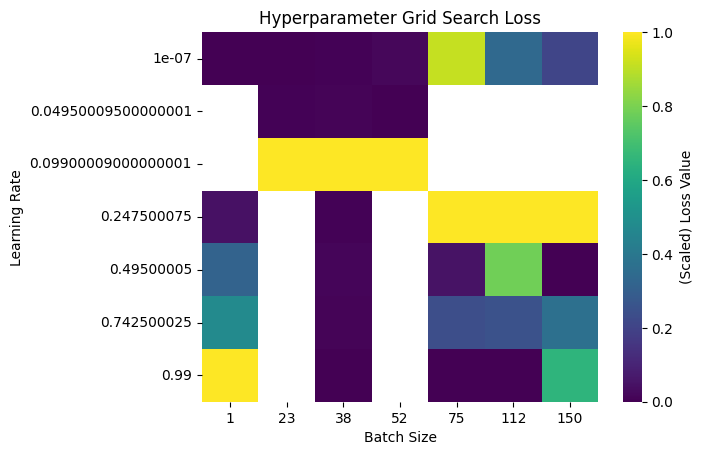

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns


def grid_search_heatmap(hyperparam_grid_search):
    """
    Represent the grid search results as a heatmap.
    """

    # Get unique X and Ys
    x_vals = sorted(set([key[0] for key in hyperparam_grid_search.keys()]))
    y_vals = sorted(set([key[1] for key in hyperparam_grid_search.keys()]))

    # Get zs for each calculated loss (or nan)
    X, Y = np.meshgrid(y_vals, x_vals)
    Z = np.array([[hyperparam_grid_search.get((x, y), np.nan) for y in y_vals] for x in x_vals])

    scaler = MinMaxScaler(feature_range=(0, 1))
    Z = scaler.fit_transform(Z)

    fig = plt.figure()
    sns.heatmap(
        Z,
        robust=True,
        xticklabels=y_vals,
        yticklabels=x_vals,
        cmap="viridis",
        cbar_kws={"label": "(Scaled) Loss Value"},
    )
    plt.xlabel("Batch Size")
    plt.ylabel("Learning Rate")
    plt.title("Hyperparameter Grid Search Loss")
    plt.show()


grid_search_heatmap(hyperparam_grid_search)


Train a model with the optimal hyper params from grid search

In [ ]:
learning_rate, batch_size = optimal_hyperparams
curriculum_learning(preprocessed_training_files,
                    all_labels,
                    feature_extractor,
                    epochs=3,
                    learning_rate=max(learning_rate, 0.001),
                    batch_size=int(batch_size))

Training on dataset df_1MB_train...
File path: preprocessed_1MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training: 100%|██████████| 1/1 [00:00<00:00, 10.39it/s]

Batch 1/1, Loss: 7.3086
Training completed. Average loss: 7.3086



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Batch 1/1, Loss: 7.3275
Epoch 2/3


Training: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Batch 1/1, Loss: 7.0016
Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

Batch 1/1, Loss: 6.5345
Training completed. Average loss: 6.9545



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Batch 1/1, Loss: 7.3582
Epoch 2/3


Training: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Batch 1/1, Loss: 6.8612
Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

Batch 1/1, Loss: 6.5370
Training completed. Average loss: 6.9188



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


Batch 1/1, Loss: 7.3915


Training: 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


Epoch 2/3


Training: 100%|██████████| 1/1 [00:00<00:00, 13.28it/s]


Batch 1/1, Loss: 7.0926


Training: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]


Epoch 3/3


Training: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s]


Batch 1/1, Loss: 6.7931


Training: 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

Training completed. Average loss: 7.0924


Training on dataset df_10MB_train...
File path: preprocessed_10MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:  33%|███▎      | 1/3 [00:00<00:00,  3.80it/s]

Batch 1/3, Loss: 7.2870


Training: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


Training completed. Average loss: 7.3095


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:  33%|███▎      | 1/3 [00:00<00:01,  1.03it/s]

Batch 1/3, Loss: 7.2881


Training: 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


Epoch 2/3


Training:  33%|███▎      | 1/3 [00:00<00:01,  1.00it/s]

Batch 1/3, Loss: 7.1345


Training: 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


Epoch 3/3


Training:  33%|███▎      | 1/3 [00:00<00:01,  1.03it/s]

Batch 1/3, Loss: 6.5550


Training: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Training completed. Average loss: 6.9169


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:  33%|███▎      | 1/3 [00:00<00:01,  1.04it/s]

Batch 1/3, Loss: 7.3353


Training: 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


Epoch 2/3


Training:  33%|███▎      | 1/3 [00:00<00:01,  1.00it/s]

Batch 1/3, Loss: 7.1061


Training: 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


Epoch 3/3


Training:  33%|███▎      | 1/3 [00:00<00:01,  1.02it/s]

Batch 1/3, Loss: 6.5866


Training: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Training completed. Average loss: 6.9150


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  3.79it/s]

Batch 1/3, Loss: 7.3274


Training: 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]


Epoch 2/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  3.41it/s]

Batch 1/3, Loss: 7.0521


Training: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


Epoch 3/3


Training:  33%|███▎      | 1/3 [00:00<00:00,  3.36it/s]

Batch 1/3, Loss: 6.5756


Training: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Training completed. Average loss: 6.8872
Training on dataset df_100MB_train...
File path: preprocessed_100MB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:   3%|▎         | 1/30 [00:00<00:07,  3.78it/s]

Batch 1/30, Loss: 7.2965


Training:  37%|███▋      | 11/30 [00:02<00:04,  3.81it/s]

Batch 11/30, Loss: 7.3441


Training:  70%|███████   | 21/30 [00:05<00:02,  3.81it/s]

Batch 21/30, Loss: 7.3641


Training: 100%|██████████| 30/30 [00:07<00:00,  3.88it/s]


Training completed. Average loss: 7.3165


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   3%|▎         | 1/30 [00:00<00:28,  1.03it/s]

Batch 1/30, Loss: 7.2935


Training:  37%|███▋      | 11/30 [00:10<00:18,  1.00it/s]

Batch 11/30, Loss: 7.3465


Training:  70%|███████   | 21/30 [00:20<00:08,  1.00it/s]

Batch 21/30, Loss: 7.3334


Training: 100%|██████████| 30/30 [00:29<00:00,  1.02it/s]


Epoch 2/3


Training:   3%|▎         | 1/30 [00:00<00:28,  1.02it/s]

Batch 1/30, Loss: 7.0969


Training:  37%|███▋      | 11/30 [00:10<00:18,  1.01it/s]

Batch 11/30, Loss: 6.7467


Training:  70%|███████   | 21/30 [00:20<00:09,  1.00s/it]

Batch 21/30, Loss: 6.9844


Training: 100%|██████████| 30/30 [00:29<00:00,  1.02it/s]


Epoch 3/3


Training:   3%|▎         | 1/30 [00:00<00:28,  1.03it/s]

Batch 1/30, Loss: 6.7895


Training:  37%|███▋      | 11/30 [00:10<00:18,  1.00it/s]

Batch 11/30, Loss: 6.7129


Training:  70%|███████   | 21/30 [00:21<00:09,  1.01s/it]

Batch 21/30, Loss: 6.8123


Training: 100%|██████████| 30/30 [00:29<00:00,  1.02it/s]


Training completed. Average loss: 7.0077


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   3%|▎         | 1/30 [00:01<00:29,  1.01s/it]

Batch 1/30, Loss: 7.3369


Training:  37%|███▋      | 11/30 [00:11<00:19,  1.03s/it]

Batch 11/30, Loss: 7.3024


Training:  70%|███████   | 21/30 [00:21<00:09,  1.03s/it]

Batch 21/30, Loss: 7.3553


Training: 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Epoch 2/3


Training:   3%|▎         | 1/30 [00:00<00:28,  1.03it/s]

Batch 1/30, Loss: 7.2507


Training:  37%|███▋      | 11/30 [00:10<00:18,  1.00it/s]

Batch 11/30, Loss: 7.0103


Training:  70%|███████   | 21/30 [00:20<00:09,  1.00s/it]

Batch 21/30, Loss: 7.1063


Training: 100%|██████████| 30/30 [00:29<00:00,  1.02it/s]


Epoch 3/3


Training:   3%|▎         | 1/30 [00:00<00:28,  1.02it/s]

Batch 1/30, Loss: 6.6261


Training:  37%|███▋      | 11/30 [00:10<00:19,  1.00s/it]

Batch 11/30, Loss: 6.9411


Training:  70%|███████   | 21/30 [00:21<00:09,  1.01s/it]

Batch 21/30, Loss: 6.8951


Training: 100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


Training completed. Average loss: 7.0589


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   3%|▎         | 1/30 [00:00<00:07,  3.80it/s]

Batch 1/30, Loss: 7.3232


Training:  37%|███▋      | 11/30 [00:02<00:04,  3.81it/s]

Batch 11/30, Loss: 7.3550


Training:  70%|███████   | 21/30 [00:05<00:02,  3.81it/s]

Batch 21/30, Loss: 7.3022


Training: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Epoch 2/3


Training:   3%|▎         | 1/30 [00:00<00:08,  3.31it/s]

Batch 1/30, Loss: 7.0137


Training:  37%|███▋      | 11/30 [00:02<00:04,  3.80it/s]

Batch 11/30, Loss: 6.8914


Training:  70%|███████   | 21/30 [00:05<00:02,  3.81it/s]

Batch 21/30, Loss: 7.2335


Training: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s]


Epoch 3/3


Training:   3%|▎         | 1/30 [00:00<00:08,  3.54it/s]

Batch 1/30, Loss: 6.8465


Training:  37%|███▋      | 11/30 [00:02<00:04,  3.81it/s]

Batch 11/30, Loss: 6.7737


Training:  70%|███████   | 21/30 [00:05<00:02,  3.81it/s]

Batch 21/30, Loss: 6.8411


Training: 100%|██████████| 30/30 [00:19<00:00,  1.50it/s]


Training completed. Average loss: 7.0075
Training on dataset df_1GB_train...
File path: preprocessed_1GB_train.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:   0%|          | 1/307 [00:00<01:30,  3.38it/s]

Batch 1/307, Loss: 7.3065


Training:   4%|▎         | 11/307 [00:02<01:17,  3.80it/s]

Batch 11/307, Loss: 7.3159


Training:   7%|▋         | 21/307 [00:05<01:15,  3.81it/s]

Batch 21/307, Loss: 7.3230


Training:  10%|█         | 31/307 [00:08<01:12,  3.80it/s]

Batch 31/307, Loss: 7.3198


Training:  13%|█▎        | 41/307 [00:10<01:09,  3.81it/s]

Batch 41/307, Loss: 7.3022


Training:  17%|█▋        | 51/307 [00:13<01:07,  3.81it/s]

Batch 51/307, Loss: 7.2677


Training:  20%|█▉        | 61/307 [00:16<01:04,  3.81it/s]

Batch 61/307, Loss: 7.3167


Training:  23%|██▎       | 71/307 [00:18<01:01,  3.81it/s]

Batch 71/307, Loss: 7.3401


Training:  26%|██▋       | 81/307 [00:21<00:59,  3.81it/s]

Batch 81/307, Loss: 7.3314


Training:  30%|██▉       | 91/307 [00:23<00:56,  3.81it/s]

Batch 91/307, Loss: 7.3338


Training:  33%|███▎      | 101/307 [00:26<00:54,  3.81it/s]

Batch 101/307, Loss: 7.3255


Training:  36%|███▌      | 111/307 [00:29<00:51,  3.81it/s]

Batch 111/307, Loss: 7.2879


Training:  39%|███▉      | 121/307 [00:31<00:48,  3.81it/s]

Batch 121/307, Loss: 7.3317


Training:  43%|████▎     | 131/307 [00:34<00:46,  3.81it/s]

Batch 131/307, Loss: 7.2959


Training:  46%|████▌     | 141/307 [00:37<00:43,  3.81it/s]

Batch 141/307, Loss: 7.2987


Training:  49%|████▉     | 151/307 [00:39<00:40,  3.81it/s]

Batch 151/307, Loss: 7.3200


Training:  52%|█████▏    | 161/307 [00:42<00:38,  3.81it/s]

Batch 161/307, Loss: 7.3182


Training:  56%|█████▌    | 171/307 [00:44<00:35,  3.81it/s]

Batch 171/307, Loss: 7.3903


Training:  59%|█████▉    | 181/307 [00:47<00:33,  3.81it/s]

Batch 181/307, Loss: 7.3066


Training:  62%|██████▏   | 191/307 [00:50<00:30,  3.81it/s]

Batch 191/307, Loss: 7.3047


Training:  65%|██████▌   | 201/307 [00:52<00:27,  3.81it/s]

Batch 201/307, Loss: 7.2983


Training:  69%|██████▊   | 211/307 [00:55<00:25,  3.81it/s]

Batch 211/307, Loss: 7.3449


Training:  72%|███████▏  | 221/307 [00:58<00:22,  3.81it/s]

Batch 221/307, Loss: 7.3340


Training:  75%|███████▌  | 231/307 [01:00<00:19,  3.81it/s]

Batch 231/307, Loss: 7.2958


Training:  79%|███████▊  | 241/307 [01:03<00:17,  3.81it/s]

Batch 241/307, Loss: 7.3090


Training:  82%|████████▏ | 251/307 [01:05<00:14,  3.81it/s]

Batch 251/307, Loss: 7.3112


Training:  85%|████████▌ | 261/307 [01:08<00:12,  3.80it/s]

Batch 261/307, Loss: 7.3143


Training:  88%|████████▊ | 271/307 [01:11<00:09,  3.81it/s]

Batch 271/307, Loss: 7.3176


Training:  92%|█████████▏| 281/307 [01:13<00:06,  3.81it/s]

Batch 281/307, Loss: 7.3190


Training:  95%|█████████▍| 291/307 [01:16<00:04,  3.80it/s]

Batch 291/307, Loss: 7.3049


Training:  98%|█████████▊| 301/307 [01:19<00:01,  3.81it/s]

Batch 301/307, Loss: 7.3354


Training: 100%|██████████| 307/307 [01:20<00:00,  3.81it/s]


Training completed. Average loss: 7.3152


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   0%|          | 1/307 [00:01<05:16,  1.03s/it]

Batch 1/307, Loss: 7.3378


Training:   4%|▎         | 11/307 [00:11<05:03,  1.02s/it]

Batch 11/307, Loss: 7.3625


Training:   7%|▋         | 21/307 [00:21<04:51,  1.02s/it]

Batch 21/307, Loss: 7.2958


Training:  10%|█         | 31/307 [00:31<04:45,  1.03s/it]

Batch 31/307, Loss: 7.3019


Training:  13%|█▎        | 41/307 [00:42<04:30,  1.02s/it]

Batch 41/307, Loss: 7.3248


Training:  17%|█▋        | 51/307 [00:52<04:22,  1.03s/it]

Batch 51/307, Loss: 7.3470


Training:  20%|█▉        | 61/307 [01:02<04:08,  1.01s/it]

Batch 61/307, Loss: 7.3213


Training:  23%|██▎       | 71/307 [01:12<03:59,  1.02s/it]

Batch 71/307, Loss: 7.2846


Training:  26%|██▋       | 81/307 [01:22<03:48,  1.01s/it]

Batch 81/307, Loss: 7.2955


Training:  30%|██▉       | 91/307 [01:32<03:40,  1.02s/it]

Batch 91/307, Loss: 7.2902


Training:  33%|███▎      | 101/307 [01:43<03:30,  1.02s/it]

Batch 101/307, Loss: 7.3306


Training:  36%|███▌      | 111/307 [01:53<03:18,  1.01s/it]

Batch 111/307, Loss: 7.3208


Training:  39%|███▉      | 121/307 [02:03<03:07,  1.01s/it]

Batch 121/307, Loss: 7.3000


Training:  43%|████▎     | 131/307 [02:13<03:00,  1.03s/it]

Batch 131/307, Loss: 7.2873


Training:  46%|████▌     | 141/307 [02:23<02:47,  1.01s/it]

Batch 141/307, Loss: 7.3190


Training:  49%|████▉     | 151/307 [02:33<02:39,  1.02s/it]

Batch 151/307, Loss: 7.3042


Training:  52%|█████▏    | 161/307 [02:44<02:28,  1.02s/it]

Batch 161/307, Loss: 7.2838


Training:  56%|█████▌    | 171/307 [02:54<02:18,  1.02s/it]

Batch 171/307, Loss: 7.2767


Training:  59%|█████▉    | 181/307 [03:04<02:08,  1.02s/it]

Batch 181/307, Loss: 7.3066


Training:  62%|██████▏   | 191/307 [03:14<01:59,  1.03s/it]

Batch 191/307, Loss: 7.3213


Training:  65%|██████▌   | 201/307 [03:24<01:48,  1.02s/it]

Batch 201/307, Loss: 7.3791


Training:  69%|██████▊   | 211/307 [03:35<01:37,  1.02s/it]

Batch 211/307, Loss: 7.3584


Training:  72%|███████▏  | 221/307 [03:45<01:27,  1.02s/it]

Batch 221/307, Loss: 7.2843


Training:  75%|███████▌  | 231/307 [03:55<01:18,  1.03s/it]

Batch 231/307, Loss: 7.3080


Training:  79%|███████▊  | 241/307 [04:05<01:07,  1.03s/it]

Batch 241/307, Loss: 7.2875


Training:  82%|████████▏ | 251/307 [04:15<00:57,  1.02s/it]

Batch 251/307, Loss: 7.2866


Training:  85%|████████▌ | 261/307 [04:26<00:46,  1.02s/it]

Batch 261/307, Loss: 7.3131


Training:  88%|████████▊ | 271/307 [04:36<00:36,  1.01s/it]

Batch 271/307, Loss: 7.3179


Training:  92%|█████████▏| 281/307 [04:46<00:26,  1.02s/it]

Batch 281/307, Loss: 7.3162


Training:  95%|█████████▍| 291/307 [04:56<00:16,  1.03s/it]

Batch 291/307, Loss: 7.3765


Training:  98%|█████████▊| 301/307 [05:06<00:06,  1.02s/it]

Batch 301/307, Loss: 7.3292


Training: 100%|██████████| 307/307 [05:12<00:00,  1.02s/it]


Epoch 2/3


Training:   0%|          | 1/307 [00:01<05:13,  1.03s/it]

Batch 1/307, Loss: 7.3111


Training:   4%|▎         | 11/307 [00:11<05:01,  1.02s/it]

Batch 11/307, Loss: 7.3009


Training:   7%|▋         | 21/307 [00:21<04:51,  1.02s/it]

Batch 21/307, Loss: 7.3380


Training:  10%|█         | 31/307 [00:31<04:39,  1.01s/it]

Batch 31/307, Loss: 7.3008


Training:  13%|█▎        | 41/307 [00:41<04:30,  1.02s/it]

Batch 41/307, Loss: 7.2357


Training:  17%|█▋        | 51/307 [00:51<04:20,  1.02s/it]

Batch 51/307, Loss: 7.3195


Training:  20%|█▉        | 61/307 [01:02<04:08,  1.01s/it]

Batch 61/307, Loss: 7.2497


Training:  23%|██▎       | 71/307 [01:12<04:00,  1.02s/it]

Batch 71/307, Loss: 7.2782


Training:  26%|██▋       | 81/307 [01:22<03:49,  1.02s/it]

Batch 81/307, Loss: 7.3162


Training:  30%|██▉       | 91/307 [01:32<03:41,  1.03s/it]

Batch 91/307, Loss: 7.2975


Training:  33%|███▎      | 101/307 [01:42<03:31,  1.03s/it]

Batch 101/307, Loss: 7.3008


Training:  36%|███▌      | 111/307 [01:53<03:20,  1.02s/it]

Batch 111/307, Loss: 7.2890


Training:  39%|███▉      | 121/307 [02:03<03:09,  1.02s/it]

Batch 121/307, Loss: 7.2437


Training:  43%|████▎     | 131/307 [02:13<02:57,  1.01s/it]

Batch 131/307, Loss: 7.2554


Training:  46%|████▌     | 141/307 [02:23<02:48,  1.01s/it]

Batch 141/307, Loss: 7.2917


Training:  49%|████▉     | 151/307 [02:33<02:39,  1.02s/it]

Batch 151/307, Loss: 7.2470


Training:  52%|█████▏    | 161/307 [02:43<02:29,  1.02s/it]

Batch 161/307, Loss: 7.2832


Training:  56%|█████▌    | 171/307 [02:54<02:19,  1.02s/it]

Batch 171/307, Loss: 7.3102


Training:  59%|█████▉    | 181/307 [03:04<02:09,  1.03s/it]

Batch 181/307, Loss: 7.2712


Training:  62%|██████▏   | 191/307 [03:14<01:58,  1.02s/it]

Batch 191/307, Loss: 7.2974


Training:  65%|██████▌   | 201/307 [03:24<01:47,  1.01s/it]

Batch 201/307, Loss: 7.3137


Training:  69%|██████▊   | 211/307 [03:34<01:38,  1.02s/it]

Batch 211/307, Loss: 7.2823


Training:  72%|███████▏  | 221/307 [03:45<01:28,  1.03s/it]

Batch 221/307, Loss: 7.2638


Training:  75%|███████▌  | 231/307 [03:55<01:17,  1.02s/it]

Batch 231/307, Loss: 7.2826


Training:  79%|███████▊  | 241/307 [04:05<01:07,  1.02s/it]

Batch 241/307, Loss: 7.2498


Training:  82%|████████▏ | 251/307 [04:15<00:57,  1.02s/it]

Batch 251/307, Loss: 7.2970


Training:  85%|████████▌ | 261/307 [04:25<00:46,  1.02s/it]

Batch 261/307, Loss: 7.3010


Training:  88%|████████▊ | 271/307 [04:36<00:36,  1.02s/it]

Batch 271/307, Loss: 7.3092


Training:  92%|█████████▏| 281/307 [04:46<00:26,  1.02s/it]

Batch 281/307, Loss: 7.3173


Training:  95%|█████████▍| 291/307 [04:56<00:16,  1.01s/it]

Batch 291/307, Loss: 7.3396


Training:  98%|█████████▊| 301/307 [05:06<00:06,  1.01s/it]

Batch 301/307, Loss: 7.3368


Training: 100%|██████████| 307/307 [05:12<00:00,  1.02s/it]


Epoch 3/3


Training:   0%|          | 1/307 [00:01<05:14,  1.03s/it]

Batch 1/307, Loss: 7.2448


Training:   4%|▎         | 11/307 [00:11<05:02,  1.02s/it]

Batch 11/307, Loss: 7.1958


Training:   7%|▋         | 21/307 [00:21<04:52,  1.02s/it]

Batch 21/307, Loss: 7.3044


Training:  10%|█         | 31/307 [00:31<04:41,  1.02s/it]

Batch 31/307, Loss: 7.2817


Training:  13%|█▎        | 41/307 [00:41<04:29,  1.01s/it]

Batch 41/307, Loss: 7.2379


Training:  17%|█▋        | 51/307 [00:52<04:23,  1.03s/it]

Batch 51/307, Loss: 7.3508


Training:  20%|█▉        | 61/307 [01:02<04:10,  1.02s/it]

Batch 61/307, Loss: 7.2318


Training:  23%|██▎       | 71/307 [01:12<04:02,  1.03s/it]

Batch 71/307, Loss: 7.2395


Training:  26%|██▋       | 81/307 [01:22<03:51,  1.02s/it]

Batch 81/307, Loss: 7.2318


Training:  30%|██▉       | 91/307 [01:32<03:40,  1.02s/it]

Batch 91/307, Loss: 7.2318


Training:  33%|███▎      | 101/307 [01:43<03:32,  1.03s/it]

Batch 101/307, Loss: 7.2272


Training:  36%|███▌      | 111/307 [01:53<03:20,  1.02s/it]

Batch 111/307, Loss: 7.2363


Training:  39%|███▉      | 121/307 [02:03<03:09,  1.02s/it]

Batch 121/307, Loss: 7.2749


Training:  43%|████▎     | 131/307 [02:13<02:57,  1.01s/it]

Batch 131/307, Loss: 7.2566


Training:  46%|████▌     | 141/307 [02:23<02:49,  1.02s/it]

Batch 141/307, Loss: 7.3188


Training:  49%|████▉     | 151/307 [02:34<02:38,  1.02s/it]

Batch 151/307, Loss: 7.3101


Training:  52%|█████▏    | 161/307 [02:44<02:29,  1.02s/it]

Batch 161/307, Loss: 7.3540


Training:  56%|█████▌    | 171/307 [02:54<02:18,  1.02s/it]

Batch 171/307, Loss: 7.2904


Training:  59%|█████▉    | 181/307 [03:04<02:07,  1.01s/it]

Batch 181/307, Loss: 7.2837


Training:  62%|██████▏   | 191/307 [03:14<01:58,  1.02s/it]

Batch 191/307, Loss: 7.3420


Training:  65%|██████▌   | 201/307 [03:24<01:48,  1.02s/it]

Batch 201/307, Loss: 7.2157


Training:  69%|██████▊   | 211/307 [03:35<01:37,  1.02s/it]

Batch 211/307, Loss: 7.3046


Training:  72%|███████▏  | 221/307 [03:45<01:28,  1.03s/it]

Batch 221/307, Loss: 7.3158


Training:  75%|███████▌  | 231/307 [03:55<01:18,  1.03s/it]

Batch 231/307, Loss: 7.2555


Training:  79%|███████▊  | 241/307 [04:05<01:07,  1.02s/it]

Batch 241/307, Loss: 7.3116


Training:  82%|████████▏ | 251/307 [04:15<00:56,  1.01s/it]

Batch 251/307, Loss: 7.2489


Training:  85%|████████▌ | 261/307 [04:26<00:46,  1.02s/it]

Batch 261/307, Loss: 7.3309


Training:  88%|████████▊ | 271/307 [04:36<00:36,  1.02s/it]

Batch 271/307, Loss: 7.2757


Training:  92%|█████████▏| 281/307 [04:46<00:26,  1.02s/it]

Batch 281/307, Loss: 7.2630


Training:  95%|█████████▍| 291/307 [04:56<00:16,  1.02s/it]

Batch 291/307, Loss: 7.3388


Training:  98%|█████████▊| 301/307 [05:06<00:06,  1.02s/it]

Batch 301/307, Loss: 7.2911


Training: 100%|██████████| 307/307 [05:13<00:00,  1.02s/it]


Training completed. Average loss: 7.2977


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   0%|          | 1/307 [00:01<05:10,  1.02s/it]

Batch 1/307, Loss: 7.2724


Training:   4%|▎         | 11/307 [00:11<04:57,  1.00s/it]

Batch 11/307, Loss: 7.3047


Training:   7%|▋         | 21/307 [00:21<04:48,  1.01s/it]

Batch 21/307, Loss: 7.2936


Training:  10%|█         | 31/307 [00:31<04:37,  1.01s/it]

Batch 31/307, Loss: 7.3292


Training:  13%|█▎        | 41/307 [00:41<04:28,  1.01s/it]

Batch 41/307, Loss: 7.3691


Training:  17%|█▋        | 51/307 [00:51<04:21,  1.02s/it]

Batch 51/307, Loss: 7.3205


Training:  20%|█▉        | 61/307 [01:01<04:08,  1.01s/it]

Batch 61/307, Loss: 7.3593


Training:  23%|██▎       | 71/307 [01:11<03:59,  1.02s/it]

Batch 71/307, Loss: 7.3249


Training:  26%|██▋       | 81/307 [01:22<03:49,  1.01s/it]

Batch 81/307, Loss: 7.3001


Training:  30%|██▉       | 91/307 [01:32<03:37,  1.01s/it]

Batch 91/307, Loss: 7.3543


Training:  33%|███▎      | 101/307 [01:42<03:26,  1.00s/it]

Batch 101/307, Loss: 7.2946


Training:  36%|███▌      | 111/307 [01:52<03:18,  1.01s/it]

Batch 111/307, Loss: 7.2830


Training:  39%|███▉      | 121/307 [02:02<03:07,  1.01s/it]

Batch 121/307, Loss: 7.3369


Training:  43%|████▎     | 131/307 [02:12<02:56,  1.01s/it]

Batch 131/307, Loss: 7.3324


Training:  46%|████▌     | 141/307 [02:22<02:49,  1.02s/it]

Batch 141/307, Loss: 7.3527


Training:  49%|████▉     | 151/307 [02:32<02:40,  1.03s/it]

Batch 151/307, Loss: 7.3360


Training:  52%|█████▏    | 161/307 [02:43<02:27,  1.01s/it]

Batch 161/307, Loss: 7.3101


Training:  56%|█████▌    | 171/307 [02:53<02:18,  1.02s/it]

Batch 171/307, Loss: 7.3257


Training:  59%|█████▉    | 181/307 [03:03<02:06,  1.00s/it]

Batch 181/307, Loss: 7.2751


Training:  62%|██████▏   | 191/307 [03:13<01:57,  1.01s/it]

Batch 191/307, Loss: 7.3033


Training:  65%|██████▌   | 201/307 [03:23<01:46,  1.01s/it]

Batch 201/307, Loss: 7.2784


Training:  69%|██████▊   | 211/307 [03:33<01:36,  1.01s/it]

Batch 211/307, Loss: 7.2862


Training:  72%|███████▏  | 221/307 [03:43<01:26,  1.01s/it]

Batch 221/307, Loss: 7.3156


Training:  75%|███████▌  | 231/307 [03:53<01:16,  1.01s/it]

Batch 231/307, Loss: 7.3707


Training:  79%|███████▊  | 241/307 [04:03<01:06,  1.01s/it]

Batch 241/307, Loss: 7.3491


Training:  82%|████████▏ | 251/307 [04:13<00:56,  1.01s/it]

Batch 251/307, Loss: 7.3189


Training:  85%|████████▌ | 261/307 [04:24<00:46,  1.02s/it]

Batch 261/307, Loss: 7.2848


Training:  88%|████████▊ | 271/307 [04:34<00:36,  1.01s/it]

Batch 271/307, Loss: 7.2991


Training:  92%|█████████▏| 281/307 [04:44<00:26,  1.01s/it]

Batch 281/307, Loss: 7.3417


Training:  95%|█████████▍| 291/307 [04:54<00:16,  1.01s/it]

Batch 291/307, Loss: 7.2838


Training:  98%|█████████▊| 301/307 [05:04<00:06,  1.01s/it]

Batch 301/307, Loss: 7.3368


Training: 100%|██████████| 307/307 [05:10<00:00,  1.01s/it]


Epoch 2/3


Training:   0%|          | 1/307 [00:01<05:12,  1.02s/it]

Batch 1/307, Loss: 7.2713


Training:   4%|▎         | 11/307 [00:11<04:59,  1.01s/it]

Batch 11/307, Loss: 7.2675


Training:   7%|▋         | 21/307 [00:21<04:50,  1.02s/it]

Batch 21/307, Loss: 7.2820


Training:  10%|█         | 31/307 [00:31<04:41,  1.02s/it]

Batch 31/307, Loss: 7.2790


Training:  13%|█▎        | 41/307 [00:41<04:28,  1.01s/it]

Batch 41/307, Loss: 7.3025


Training:  17%|█▋        | 51/307 [00:51<04:18,  1.01s/it]

Batch 51/307, Loss: 7.3321


Training:  20%|█▉        | 61/307 [01:01<04:09,  1.01s/it]

Batch 61/307, Loss: 7.2112


Training:  23%|██▎       | 71/307 [01:11<03:57,  1.01s/it]

Batch 71/307, Loss: 7.2383


Training:  26%|██▋       | 81/307 [01:22<03:52,  1.03s/it]

Batch 81/307, Loss: 7.2775


Training:  30%|██▉       | 91/307 [01:32<03:40,  1.02s/it]

Batch 91/307, Loss: 7.2644


Training:  33%|███▎      | 101/307 [01:42<03:29,  1.02s/it]

Batch 101/307, Loss: 7.3083


Training:  36%|███▌      | 111/307 [01:52<03:17,  1.01s/it]

Batch 111/307, Loss: 7.3030


Training:  39%|███▉      | 121/307 [02:02<03:08,  1.01s/it]

Batch 121/307, Loss: 7.2722


Training:  43%|████▎     | 131/307 [02:12<02:58,  1.01s/it]

Batch 131/307, Loss: 7.2811


Training:  46%|████▌     | 141/307 [02:23<02:49,  1.02s/it]

Batch 141/307, Loss: 7.3096


Training:  49%|████▉     | 151/307 [02:33<02:38,  1.02s/it]

Batch 151/307, Loss: 7.2923


Training:  52%|█████▏    | 161/307 [02:43<02:29,  1.02s/it]

Batch 161/307, Loss: 7.3056


Training:  56%|█████▌    | 171/307 [02:53<02:18,  1.02s/it]

Batch 171/307, Loss: 7.2776


Training:  59%|█████▉    | 181/307 [03:03<02:07,  1.02s/it]

Batch 181/307, Loss: 7.2867


Training:  62%|██████▏   | 191/307 [03:13<01:56,  1.01s/it]

Batch 191/307, Loss: 7.2523


Training:  65%|██████▌   | 201/307 [03:23<01:46,  1.01s/it]

Batch 201/307, Loss: 7.3007


Training:  69%|██████▊   | 211/307 [03:34<01:37,  1.01s/it]

Batch 211/307, Loss: 7.3536


Training:  72%|███████▏  | 221/307 [03:44<01:27,  1.02s/it]

Batch 221/307, Loss: 7.3059


Training:  75%|███████▌  | 231/307 [03:54<01:17,  1.03s/it]

Batch 231/307, Loss: 7.3332


Training:  79%|███████▊  | 241/307 [04:04<01:06,  1.01s/it]

Batch 241/307, Loss: 7.2800


Training:  82%|████████▏ | 251/307 [04:14<00:56,  1.01s/it]

Batch 251/307, Loss: 7.2950


Training:  85%|████████▌ | 261/307 [04:24<00:46,  1.02s/it]

Batch 261/307, Loss: 7.3026


Training:  88%|████████▊ | 271/307 [04:34<00:36,  1.01s/it]

Batch 271/307, Loss: 7.2997


Training:  92%|█████████▏| 281/307 [04:45<00:26,  1.02s/it]

Batch 281/307, Loss: 7.3049


Training:  95%|█████████▍| 291/307 [04:55<00:16,  1.02s/it]

Batch 291/307, Loss: 7.2980


Training:  98%|█████████▊| 301/307 [05:05<00:06,  1.01s/it]

Batch 301/307, Loss: 7.2687


Training: 100%|██████████| 307/307 [05:11<00:00,  1.01s/it]


Epoch 3/3


Training:   0%|          | 1/307 [00:01<05:07,  1.01s/it]

Batch 1/307, Loss: 7.2737


Training:   4%|▎         | 11/307 [00:11<05:02,  1.02s/it]

Batch 11/307, Loss: 7.2317


Training:   7%|▋         | 21/307 [00:21<04:49,  1.01s/it]

Batch 21/307, Loss: 7.2493


Training:  10%|█         | 31/307 [00:31<04:35,  1.00it/s]

Batch 31/307, Loss: 7.2402


Training:  13%|█▎        | 41/307 [00:41<04:27,  1.01s/it]

Batch 41/307, Loss: 7.2493


Training:  17%|█▋        | 51/307 [00:51<04:17,  1.01s/it]

Batch 51/307, Loss: 7.2312


Training:  20%|█▉        | 61/307 [01:01<04:11,  1.02s/it]

Batch 61/307, Loss: 7.2853


Training:  23%|██▎       | 71/307 [01:11<03:58,  1.01s/it]

Batch 71/307, Loss: 7.3019


Training:  26%|██▋       | 81/307 [01:21<03:49,  1.01s/it]

Batch 81/307, Loss: 7.2999


Training:  30%|██▉       | 91/307 [01:32<03:38,  1.01s/it]

Batch 91/307, Loss: 7.1971


Training:  33%|███▎      | 101/307 [01:42<03:28,  1.01s/it]

Batch 101/307, Loss: 7.2524


Training:  36%|███▌      | 111/307 [01:52<03:17,  1.01s/it]

Batch 111/307, Loss: 7.2679


Training:  39%|███▉      | 121/307 [02:02<03:09,  1.02s/it]

Batch 121/307, Loss: 7.2339


Training:  43%|████▎     | 131/307 [02:12<02:58,  1.01s/it]

Batch 131/307, Loss: 7.3127


Training:  46%|████▌     | 141/307 [02:22<02:50,  1.03s/it]

Batch 141/307, Loss: 7.2861


Training:  49%|████▉     | 151/307 [02:32<02:38,  1.01s/it]

Batch 151/307, Loss: 7.2515


Training:  52%|█████▏    | 161/307 [02:42<02:27,  1.01s/it]

Batch 161/307, Loss: 7.2922


Training:  56%|█████▌    | 171/307 [02:53<02:18,  1.02s/it]

Batch 171/307, Loss: 7.2972


Training:  59%|█████▉    | 181/307 [03:03<02:08,  1.02s/it]

Batch 181/307, Loss: 7.2769


Training:  62%|██████▏   | 191/307 [03:13<01:57,  1.01s/it]

Batch 191/307, Loss: 7.2923


Training:  65%|██████▌   | 201/307 [03:23<01:46,  1.01s/it]

Batch 201/307, Loss: 7.2562


Training:  69%|██████▊   | 211/307 [03:33<01:36,  1.01s/it]

Batch 211/307, Loss: 7.2449


Training:  72%|███████▏  | 221/307 [03:43<01:27,  1.02s/it]

Batch 221/307, Loss: 7.2967


Training:  75%|███████▌  | 231/307 [03:54<01:17,  1.02s/it]

Batch 231/307, Loss: 7.2882


Training:  79%|███████▊  | 241/307 [04:04<01:06,  1.01s/it]

Batch 241/307, Loss: 7.2946


Training:  82%|████████▏ | 251/307 [04:14<00:57,  1.02s/it]

Batch 251/307, Loss: 7.2592


Training:  85%|████████▌ | 261/307 [04:24<00:46,  1.02s/it]

Batch 261/307, Loss: 7.2529


Training:  88%|████████▊ | 271/307 [04:34<00:36,  1.02s/it]

Batch 271/307, Loss: 7.3194


Training:  92%|█████████▏| 281/307 [04:44<00:26,  1.01s/it]

Batch 281/307, Loss: 7.2581


Training:  95%|█████████▍| 291/307 [04:54<00:16,  1.01s/it]

Batch 291/307, Loss: 7.3600


Training:  98%|█████████▊| 301/307 [05:05<00:06,  1.02s/it]

Batch 301/307, Loss: 7.2858


Training: 100%|██████████| 307/307 [05:11<00:00,  1.01s/it]


Training completed. Average loss: 7.2971


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   0%|          | 1/307 [00:00<01:32,  3.31it/s]

Batch 1/307, Loss: 7.2677


Training:   4%|▎         | 11/307 [00:02<01:17,  3.81it/s]

Batch 11/307, Loss: 7.3223


Training:   7%|▋         | 21/307 [00:05<01:14,  3.82it/s]

Batch 21/307, Loss: 7.3792


Training:  10%|█         | 31/307 [00:08<01:12,  3.81it/s]

Batch 31/307, Loss: 7.4044


Training:  13%|█▎        | 41/307 [00:10<01:09,  3.81it/s]

Batch 41/307, Loss: 7.3218


Training:  17%|█▋        | 51/307 [00:13<01:07,  3.81it/s]

Batch 51/307, Loss: 7.2998


Training:  20%|█▉        | 61/307 [00:16<01:04,  3.81it/s]

Batch 61/307, Loss: 7.3322


Training:  23%|██▎       | 71/307 [00:18<01:01,  3.81it/s]

Batch 71/307, Loss: 7.3380


Training:  26%|██▋       | 81/307 [00:21<00:59,  3.81it/s]

Batch 81/307, Loss: 7.2951


Training:  30%|██▉       | 91/307 [00:23<00:56,  3.81it/s]

Batch 91/307, Loss: 7.3195


Training:  33%|███▎      | 101/307 [00:26<00:54,  3.81it/s]

Batch 101/307, Loss: 7.3003


Training:  36%|███▌      | 111/307 [00:29<00:51,  3.81it/s]

Batch 111/307, Loss: 7.3089


Training:  39%|███▉      | 121/307 [00:31<00:48,  3.81it/s]

Batch 121/307, Loss: 7.3288


Training:  43%|████▎     | 131/307 [00:34<00:46,  3.81it/s]

Batch 131/307, Loss: 7.3168


Training:  46%|████▌     | 141/307 [00:37<00:43,  3.81it/s]

Batch 141/307, Loss: 7.3303


Training:  49%|████▉     | 151/307 [00:39<00:40,  3.81it/s]

Batch 151/307, Loss: 7.3148


Training:  52%|█████▏    | 161/307 [00:42<00:38,  3.81it/s]

Batch 161/307, Loss: 7.3288


Training:  56%|█████▌    | 171/307 [00:44<00:35,  3.81it/s]

Batch 171/307, Loss: 7.3022


Training:  59%|█████▉    | 181/307 [00:47<00:33,  3.81it/s]

Batch 181/307, Loss: 7.3384


Training:  62%|██████▏   | 191/307 [00:50<00:30,  3.81it/s]

Batch 191/307, Loss: 7.3155


Training:  65%|██████▌   | 201/307 [00:52<00:27,  3.81it/s]

Batch 201/307, Loss: 7.3174


Training:  69%|██████▊   | 211/307 [00:55<00:25,  3.81it/s]

Batch 211/307, Loss: 7.3219


Training:  72%|███████▏  | 221/307 [00:58<00:22,  3.81it/s]

Batch 221/307, Loss: 7.3206


Training:  75%|███████▌  | 231/307 [01:00<00:19,  3.81it/s]

Batch 231/307, Loss: 7.3100


Training:  79%|███████▊  | 241/307 [01:03<00:17,  3.81it/s]

Batch 241/307, Loss: 7.3022


Training:  82%|████████▏ | 251/307 [01:05<00:14,  3.81it/s]

Batch 251/307, Loss: 7.2916


Training:  85%|████████▌ | 261/307 [01:08<00:12,  3.81it/s]

Batch 261/307, Loss: 7.3021


Training:  88%|████████▊ | 271/307 [01:11<00:09,  3.81it/s]

Batch 271/307, Loss: 7.3094


Training:  92%|█████████▏| 281/307 [01:13<00:06,  3.81it/s]

Batch 281/307, Loss: 7.3088


Training:  95%|█████████▍| 291/307 [01:16<00:04,  3.81it/s]

Batch 291/307, Loss: 7.3099


Training:  98%|█████████▊| 301/307 [01:19<00:01,  3.81it/s]

Batch 301/307, Loss: 7.3180


Training: 100%|██████████| 307/307 [03:32<00:00,  1.44it/s]


Epoch 2/3


Training:   0%|          | 1/307 [00:00<01:29,  3.41it/s]

Batch 1/307, Loss: 7.3056


Training:   4%|▎         | 11/307 [00:02<01:17,  3.81it/s]

Batch 11/307, Loss: 7.3008


Training:   7%|▋         | 21/307 [00:05<01:15,  3.80it/s]

Batch 21/307, Loss: 7.2849


Training:  10%|█         | 31/307 [00:08<01:12,  3.81it/s]

Batch 31/307, Loss: 7.2836


Training:  13%|█▎        | 41/307 [00:10<01:09,  3.81it/s]

Batch 41/307, Loss: 7.3491


Training:  17%|█▋        | 51/307 [00:13<01:07,  3.81it/s]

Batch 51/307, Loss: 7.3235


Training:  20%|█▉        | 61/307 [00:16<01:04,  3.81it/s]

Batch 61/307, Loss: 7.2555


Training:  23%|██▎       | 71/307 [00:18<01:01,  3.81it/s]

Batch 71/307, Loss: 7.2635


Training:  26%|██▋       | 81/307 [00:21<00:59,  3.81it/s]

Batch 81/307, Loss: 7.3406


Training:  30%|██▉       | 91/307 [00:23<00:56,  3.81it/s]

Batch 91/307, Loss: 7.2348


Training:  33%|███▎      | 101/307 [00:26<00:54,  3.81it/s]

Batch 101/307, Loss: 7.4025


Training:  36%|███▌      | 111/307 [00:29<00:51,  3.81it/s]

Batch 111/307, Loss: 7.2453


Training:  39%|███▉      | 121/307 [00:31<00:48,  3.81it/s]

Batch 121/307, Loss: 7.3295


Training:  43%|████▎     | 131/307 [00:34<00:46,  3.81it/s]

Batch 131/307, Loss: 7.2913


Training:  46%|████▌     | 141/307 [00:37<00:43,  3.81it/s]

Batch 141/307, Loss: 7.3088


Training:  49%|████▉     | 151/307 [00:39<00:40,  3.81it/s]

Batch 151/307, Loss: 7.3178


Training:  52%|█████▏    | 161/307 [00:42<00:38,  3.81it/s]

Batch 161/307, Loss: 7.2339


Training:  56%|█████▌    | 171/307 [00:44<00:35,  3.81it/s]

Batch 171/307, Loss: 7.3080


Training:  59%|█████▉    | 181/307 [00:47<00:33,  3.81it/s]

Batch 181/307, Loss: 7.2639


Training:  62%|██████▏   | 191/307 [00:50<00:30,  3.81it/s]

Batch 191/307, Loss: 7.2608


Training:  65%|██████▌   | 201/307 [00:52<00:27,  3.81it/s]

Batch 201/307, Loss: 7.3231


Training:  69%|██████▊   | 211/307 [00:55<00:25,  3.81it/s]

Batch 211/307, Loss: 7.2877


Training:  72%|███████▏  | 221/307 [00:58<00:22,  3.81it/s]

Batch 221/307, Loss: 7.2793


Training:  75%|███████▌  | 231/307 [01:00<00:19,  3.81it/s]

Batch 231/307, Loss: 7.2816


Training:  79%|███████▊  | 241/307 [01:03<00:17,  3.81it/s]

Batch 241/307, Loss: 7.2816


Training:  82%|████████▏ | 251/307 [01:05<00:14,  3.81it/s]

Batch 251/307, Loss: 7.3215


Training:  85%|████████▌ | 261/307 [01:08<00:12,  3.81it/s]

Batch 261/307, Loss: 7.2884


Training:  88%|████████▊ | 271/307 [01:11<00:09,  3.81it/s]

Batch 271/307, Loss: 7.2931


Training:  92%|█████████▏| 281/307 [01:13<00:06,  3.81it/s]

Batch 281/307, Loss: 7.2765


Training:  95%|█████████▍| 291/307 [01:16<00:04,  3.81it/s]

Batch 291/307, Loss: 7.2548


Training:  98%|█████████▊| 301/307 [01:19<00:01,  3.81it/s]

Batch 301/307, Loss: 7.2970


Training: 100%|██████████| 307/307 [03:33<00:00,  1.44it/s]


Epoch 3/3


Training:   0%|          | 1/307 [00:00<01:33,  3.28it/s]

Batch 1/307, Loss: 7.2977


Training:   4%|▎         | 11/307 [00:02<01:17,  3.81it/s]

Batch 11/307, Loss: 7.2894


Training:   7%|▋         | 21/307 [00:05<01:15,  3.81it/s]

Batch 21/307, Loss: 7.2217


Training:  10%|█         | 31/307 [00:08<01:12,  3.81it/s]

Batch 31/307, Loss: 7.2047


Training:  13%|█▎        | 41/307 [00:10<01:09,  3.81it/s]

Batch 41/307, Loss: 7.2840


Training:  17%|█▋        | 51/307 [00:13<01:07,  3.81it/s]

Batch 51/307, Loss: 7.2303


Training:  20%|█▉        | 61/307 [00:16<01:04,  3.81it/s]

Batch 61/307, Loss: 7.1847


Training:  23%|██▎       | 71/307 [00:18<01:01,  3.81it/s]

Batch 71/307, Loss: 7.2366


Training:  26%|██▋       | 81/307 [00:21<00:59,  3.81it/s]

Batch 81/307, Loss: 7.2188


Training:  30%|██▉       | 91/307 [00:23<00:56,  3.81it/s]

Batch 91/307, Loss: 7.2622


Training:  33%|███▎      | 101/307 [00:26<00:54,  3.81it/s]

Batch 101/307, Loss: 7.2647


Training:  36%|███▌      | 111/307 [00:29<00:51,  3.81it/s]

Batch 111/307, Loss: 7.2006


Training:  39%|███▉      | 121/307 [00:31<00:48,  3.81it/s]

Batch 121/307, Loss: 7.2662


Training:  43%|████▎     | 131/307 [00:34<00:46,  3.81it/s]

Batch 131/307, Loss: 7.2452


Training:  46%|████▌     | 141/307 [00:37<00:43,  3.81it/s]

Batch 141/307, Loss: 7.2166


Training:  49%|████▉     | 151/307 [00:39<00:40,  3.81it/s]

Batch 151/307, Loss: 7.3360


Training:  52%|█████▏    | 161/307 [00:42<00:38,  3.81it/s]

Batch 161/307, Loss: 7.2734


Training:  56%|█████▌    | 171/307 [00:44<00:35,  3.81it/s]

Batch 171/307, Loss: 7.2869


Training:  59%|█████▉    | 181/307 [00:47<00:33,  3.81it/s]

Batch 181/307, Loss: 7.2972


Training:  62%|██████▏   | 191/307 [00:50<00:30,  3.81it/s]

Batch 191/307, Loss: 7.3461


Training:  65%|██████▌   | 201/307 [00:52<00:27,  3.81it/s]

Batch 201/307, Loss: 7.2331


Training:  69%|██████▊   | 211/307 [00:55<00:25,  3.81it/s]

Batch 211/307, Loss: 7.3247


Training:  72%|███████▏  | 221/307 [00:58<00:22,  3.81it/s]

Batch 221/307, Loss: 7.3072


Training:  75%|███████▌  | 231/307 [01:00<00:19,  3.81it/s]

Batch 231/307, Loss: 7.3325


Training:  79%|███████▊  | 241/307 [01:03<00:17,  3.81it/s]

Batch 241/307, Loss: 7.2799


Training:  82%|████████▏ | 251/307 [01:05<00:14,  3.81it/s]

Batch 251/307, Loss: 7.3063


Training:  85%|████████▌ | 261/307 [01:08<00:12,  3.81it/s]

Batch 261/307, Loss: 7.2768


Training:  88%|████████▊ | 271/307 [01:11<00:09,  3.81it/s]

Batch 271/307, Loss: 7.3063


Training:  92%|█████████▏| 281/307 [01:13<00:06,  3.81it/s]

Batch 281/307, Loss: 7.2590


Training:  95%|█████████▍| 291/307 [01:16<00:04,  3.81it/s]

Batch 291/307, Loss: 7.2872


Training:  98%|█████████▊| 301/307 [01:19<00:01,  3.81it/s]

Batch 301/307, Loss: 7.2893


Training: 100%|██████████| 307/307 [03:34<00:00,  1.43it/s]


Training completed. Average loss: 7.2975


7.044181380524741


=== Running grid search for df_1MB_train ===
Testing hyperparameters for df_1MB_train: learning_rate = 0.0001000, batch_size = 16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3638
Epoch 2/3, Loss: 7.0127
Epoch 3/3, Loss: 6.7644
Testing hyperparameters for df_1MB_train: learning_rate = 0.0001000, batch_size = 32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3082
Epoch 2/3, Loss: 6.9810
Epoch 3/3, Loss: 6.7751
Testing hyperparameters for df_1MB_train: learning_rate = 0.0001000, batch_size = 64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3386
Epoch 2/3, Loss: 7.0525
Epoch 3/3, Loss: 6.7722
Testing hyperparameters for df_1MB_train: learning_rate = 0.0005000, batch_size = 16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.2844
Epoch 2/3, Loss: 6.9610
Epoch 3/3, Loss: 6.6610
Testing hyperparameters for df_1MB_train: learning_rate = 0.0005000, batch_size = 32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3213
Epoch 2/3, Loss: 6.9036
Epoch 3/3, Loss: 6.7604
Testing hyperparameters for df_1MB_train: learning_rate = 0.0005000, batch_size = 64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.2889
Epoch 2/3, Loss: 7.0298
Epoch 3/3, Loss: 6.7845
Testing hyperparameters for df_1MB_train: learning_rate = 0.0010000, batch_size = 16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.2886
Epoch 2/3, Loss: 6.9836
Epoch 3/3, Loss: 7.1014
Testing hyperparameters for df_1MB_train: learning_rate = 0.0010000, batch_size = 32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3603
Epoch 2/3, Loss: 7.0075
Epoch 3/3, Loss: 6.7031
Testing hyperparameters for df_1MB_train: learning_rate = 0.0010000, batch_size = 64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3352
Epoch 2/3, Loss: 6.9026
Epoch 3/3, Loss: 6.5821

=== Running grid search for df_10MB_train ===
Testing hyperparameters for df_10MB_train: learning_rate = 0.0001000, batch_size = 16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3202
Epoch 2/3, Loss: 7.1143
Epoch 3/3, Loss: 6.8313
Testing hyperparameters for df_10MB_train: learning_rate = 0.0001000, batch_size = 32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3302
Epoch 2/3, Loss: 7.0487
Epoch 3/3, Loss: 6.8379
Testing hyperparameters for df_10MB_train: learning_rate = 0.0001000, batch_size = 64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3065
Epoch 2/3, Loss: 7.1195
Epoch 3/3, Loss: 6.9512
Testing hyperparameters for df_10MB_train: learning_rate = 0.0005000, batch_size = 16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3106
Epoch 2/3, Loss: 6.7262
Epoch 3/3, Loss: 6.1055
Testing hyperparameters for df_10MB_train: learning_rate = 0.0005000, batch_size = 32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3242
Epoch 2/3, Loss: 7.0360
Epoch 3/3, Loss: 6.6706
Testing hyperparameters for df_10MB_train: learning_rate = 0.0005000, batch_size = 64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3026
Epoch 2/3, Loss: 7.0771
Epoch 3/3, Loss: 6.7909
Testing hyperparameters for df_10MB_train: learning_rate = 0.0010000, batch_size = 16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.2931
Epoch 2/3, Loss: 6.4521
Epoch 3/3, Loss: 5.4668
Testing hyperparameters for df_10MB_train: learning_rate = 0.0010000, batch_size = 32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3157
Epoch 2/3, Loss: 6.7641
Epoch 3/3, Loss: 6.1026
Testing hyperparameters for df_10MB_train: learning_rate = 0.0010000, batch_size = 64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.2963
Epoch 2/3, Loss: 7.0850
Epoch 3/3, Loss: 6.7081

=== Running grid search for df_100MB_train ===
Testing hyperparameters for df_100MB_train: learning_rate = 0.0001000, batch_size = 16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3130
Epoch 2/3, Loss: 7.0005
Epoch 3/3, Loss: 6.7289
Testing hyperparameters for df_100MB_train: learning_rate = 0.0001000, batch_size = 32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3028
Epoch 2/3, Loss: 7.0918
Epoch 3/3, Loss: 6.8436
Testing hyperparameters for df_100MB_train: learning_rate = 0.0001000, batch_size = 64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3126
Epoch 2/3, Loss: 7.1558
Epoch 3/3, Loss: 6.9838
Testing hyperparameters for df_100MB_train: learning_rate = 0.0005000, batch_size = 16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3260
Epoch 2/3, Loss: 6.9260
Epoch 3/3, Loss: 6.7722
Testing hyperparameters for df_100MB_train: learning_rate = 0.0005000, batch_size = 32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3201
Epoch 2/3, Loss: 7.0202
Epoch 3/3, Loss: 6.8109
Testing hyperparameters for df_100MB_train: learning_rate = 0.0005000, batch_size = 64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3112
Epoch 2/3, Loss: 6.9800
Epoch 3/3, Loss: 6.7647
Testing hyperparameters for df_100MB_train: learning_rate = 0.0010000, batch_size = 16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3242
Epoch 2/3, Loss: 6.9341
Epoch 3/3, Loss: 6.7764
Testing hyperparameters for df_100MB_train: learning_rate = 0.0010000, batch_size = 32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3170
Epoch 2/3, Loss: 7.0184
Epoch 3/3, Loss: 6.8129
Testing hyperparameters for df_100MB_train: learning_rate = 0.0010000, batch_size = 64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3244
Epoch 2/3, Loss: 6.9180
Epoch 3/3, Loss: 6.7681

=== Running grid search for df_1GB_train ===
Testing hyperparameters for df_1GB_train: learning_rate = 0.0001000, batch_size = 16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.2995
Epoch 2/3, Loss: 7.1391
Epoch 3/3, Loss: 6.9156
Testing hyperparameters for df_1GB_train: learning_rate = 0.0001000, batch_size = 32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3031
Epoch 2/3, Loss: 7.1509
Epoch 3/3, Loss: 6.9208
Testing hyperparameters for df_1GB_train: learning_rate = 0.0001000, batch_size = 64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3063
Epoch 2/3, Loss: 7.2205
Epoch 3/3, Loss: 7.0502
Testing hyperparameters for df_1GB_train: learning_rate = 0.0005000, batch_size = 16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3172
Epoch 2/3, Loss: 7.2917
Epoch 3/3, Loss: 7.2735
Testing hyperparameters for df_1GB_train: learning_rate = 0.0005000, batch_size = 32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3118
Epoch 2/3, Loss: 7.2913
Epoch 3/3, Loss: 7.2789
Testing hyperparameters for df_1GB_train: learning_rate = 0.0005000, batch_size = 64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3158
Epoch 2/3, Loss: 7.2745
Epoch 3/3, Loss: 7.2080
Testing hyperparameters for df_1GB_train: learning_rate = 0.0010000, batch_size = 16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3176
Epoch 2/3, Loss: 7.2931
Epoch 3/3, Loss: 7.2825
Testing hyperparameters for df_1GB_train: learning_rate = 0.0010000, batch_size = 32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3180
Epoch 2/3, Loss: 7.2914
Epoch 3/3, Loss: 7.2827
Testing hyperparameters for df_1GB_train: learning_rate = 0.0010000, batch_size = 64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3165
Epoch 2/3, Loss: 7.2900
Epoch 3/3, Loss: 7.2815


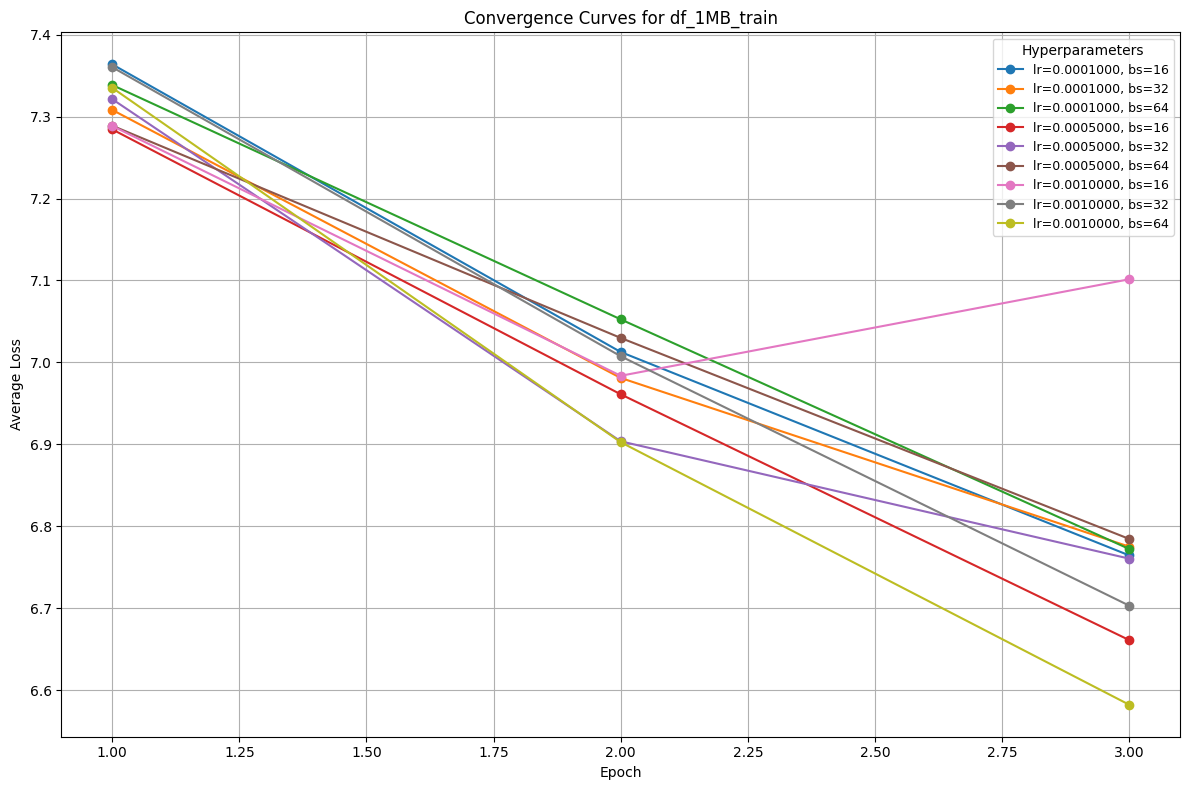

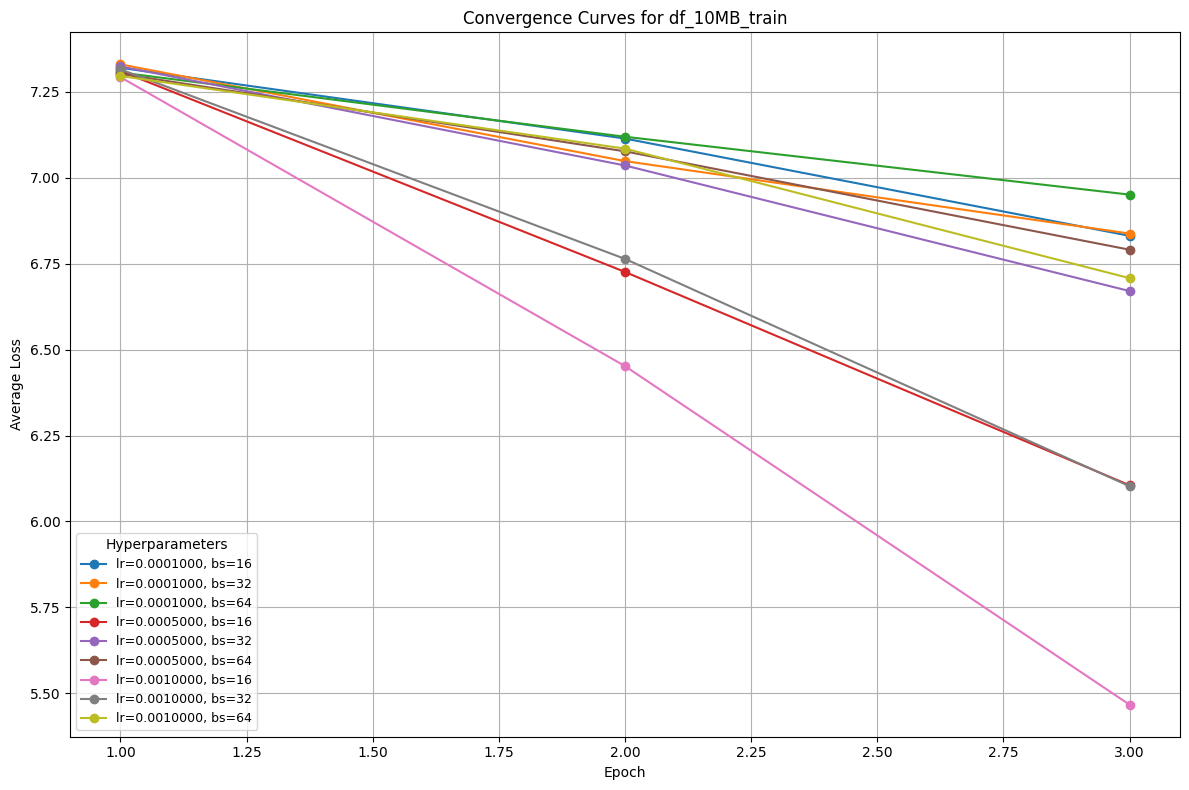

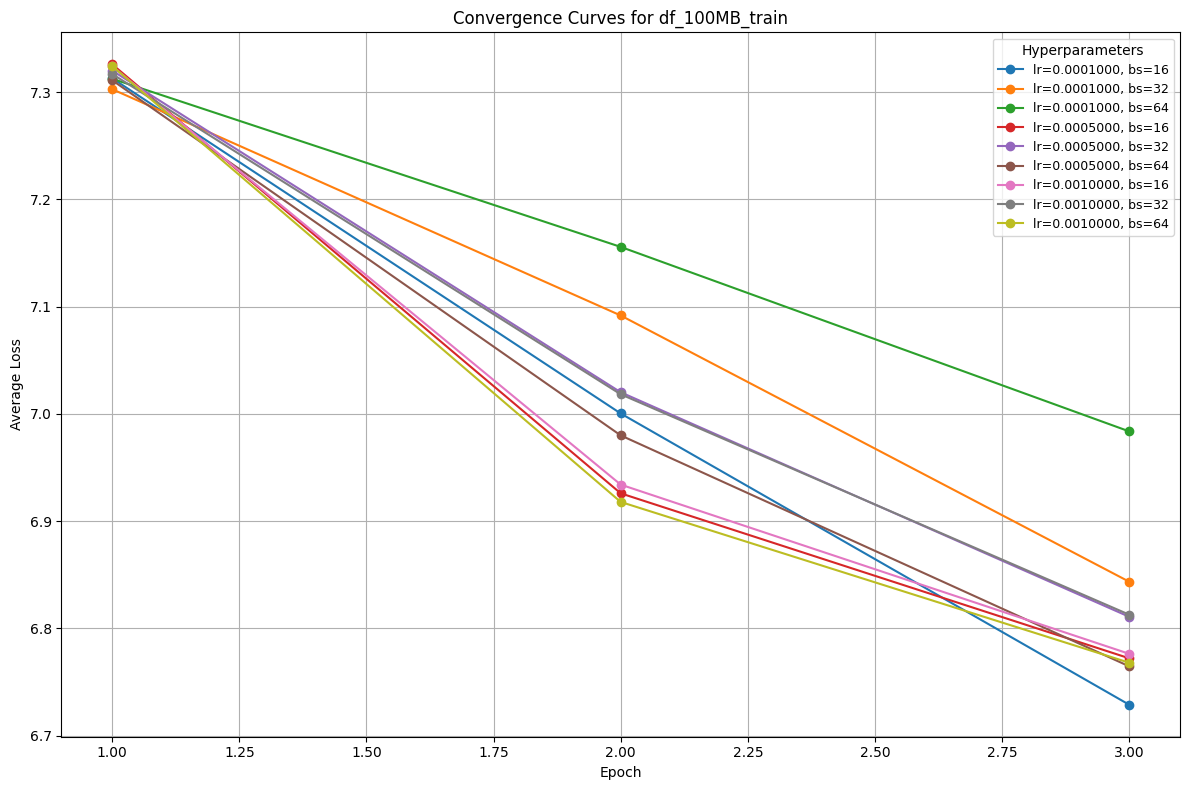

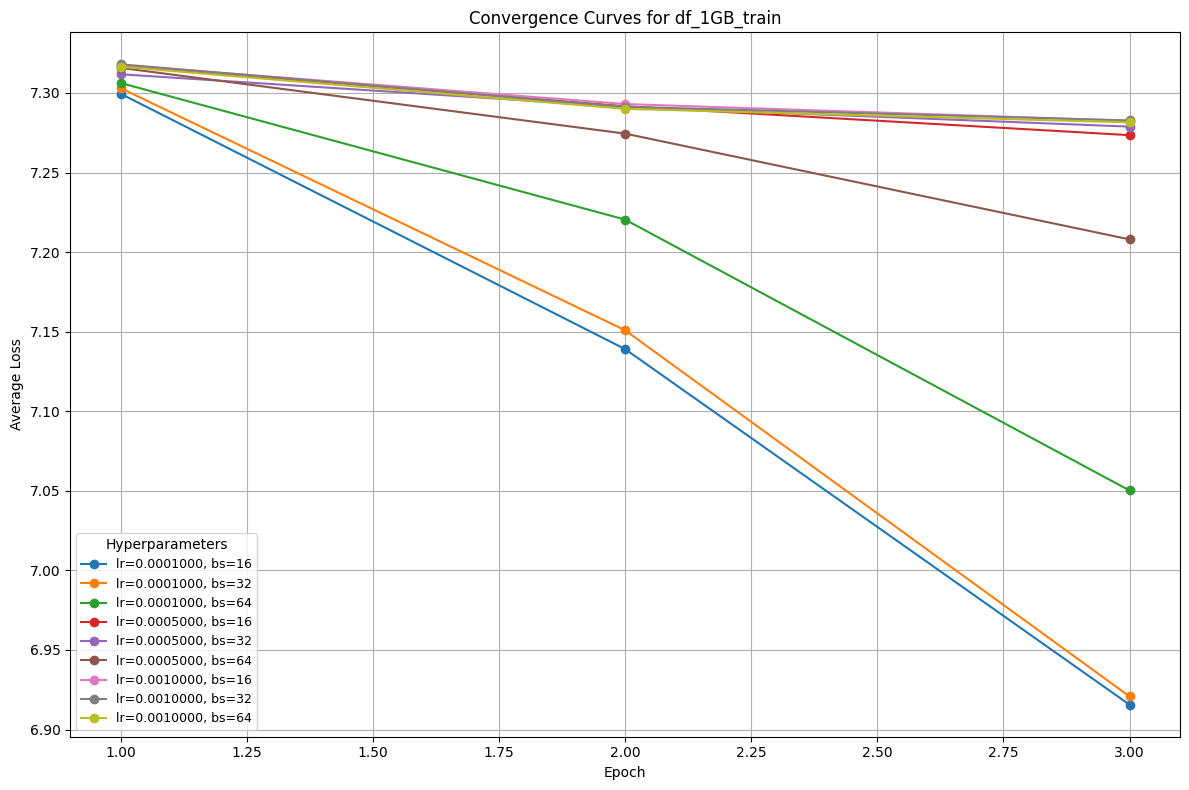

In [ ]:
import torch
import torch.nn.functional as F
from transformers import ViTForImageClassification
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
import gc

# --- Train Model Function ---
def train_model(train_loader, model, optimizer, epochs, device="cuda"):
    model.train()  # Enable training mode
    loss_history = []
    for epoch in range(epochs):
        total_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).logits
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        epoch_avg_loss = total_loss / len(train_loader)
        loss_history.append(epoch_avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_avg_loss:.4f}")
    return loss_history

# --- Grid Search Convergence Function ---
def grid_search_convergence(training_files, model_name, num_labels, learning_rates, batch_sizes, epochs=3, device="cuda"):
    """
    For each (learning_rate, batch_size) combination, create a DataLoader from training files,
    initialize a ViT model, train for 'epochs', and record the convergence curve.
    """
    results = {}
    for dataset_key, training_file in training_files.items():
        print(f"\n=== Running grid search for {dataset_key} ===")
        dataset_results = {}
        for lr, bs in it.product(learning_rates, batch_sizes):
            print(f"Testing hyperparameters for {dataset_key}: learning_rate = {lr:.7f}, batch_size = {bs}")
            gc.collect()
            torch.cuda.empty_cache()

            # Create DataLoader for the current dataset and batch size.
            train_loader = create_dataloader(training_file, batch_size=bs)

            # Initialize a new ViT model.
            model = ViTForImageClassification.from_pretrained(model_name, num_labels=num_labels)
            model.to(device)

            # Define optimizer with the current learning rate.
            optimizer = optim.Adam(model.parameters(), lr=lr)

            # Train the model and record the loss history.
            loss_history = train_model(train_loader, model, optimizer, epochs, device=device)
            dataset_results[(lr, bs)] = loss_history

            # Free up memory after this training loop.
            del model, optimizer
            gc.collect()
            torch.cuda.empty_cache()

        results[dataset_key] = dataset_results
    return results

# --- Plot Convergence Curves ---
def plot_convergence_curves_all(results):
    """
    For each dataset, plot convergence curves (loss vs. epoch) for each hyperparameter combination.
    """
    for dataset_key, dataset_results in results.items():
        plt.figure(figsize=(12, 8))
        for (lr, bs), loss_history in dataset_results.items():
            epochs_range = np.arange(1, len(loss_history) + 1)
            plt.plot(epochs_range, loss_history, marker="o", label=f"lr={lr:.7f}, bs={bs}")
        plt.xlabel("Epoch")
        plt.ylabel("Average Loss")
        plt.title(f"Convergence Curves for {dataset_key}")
        plt.legend(title="Hyperparameters", fontsize=9)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# --- Define Hyperparameters ---
# Testing different combinations of learning rates and batch sizes.
learning_rates = [0.0001, 0.0005, 0.001]   # Range of learning rates to test
batch_sizes = [16, 32, 64]                 # Range of batch sizes to test

# --- Run Grid Search ---
# Ensure preprocessed_training_files and all_labels are defined.
training_files = preprocessed_training_files  # All datasets: e.g., {"df_1MB_train": ..., "df_10MB_train": ...}
num_labels = len(all_labels)  # Total number of classes.

# Perform grid search convergence.
convergence_results = grid_search_convergence(training_files, "google/vit-base-patch16-224-in21k", num_labels, learning_rates, batch_sizes, epochs=3, device="cuda")

# Plot convergence curves.
plot_convergence_curves_all(convergence_results)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 7.3441
Epoch 2/3, Loss: 7.1493
Epoch 3/3, Loss: 7.0004

Evaluating Vanilla model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Vanilla Metrics: {'Accuracy': 0.06666666666666667, 'Recall': 0.06666666666666667, 'Precision': 0.02222222222222222, 'F1': 0.03333333333333333}

Evaluating Curriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Curriculum Metrics: {'Accuracy': 0.06666666666666667, 'Recall': 0.06666666666666667, 'Precision': 0.03333333333333333, 'F1': 0.04444444444444444}

Evaluating AntiCurriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AntiCurriculum Metrics: {'Accuracy': 0.06666666666666667, 'Recall': 0.06666666666666667, 'Precision': 0.03333333333333333, 'F1': 0.04444444444444444}

Evaluating Uncertainty model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Uncertainty Metrics: {'Accuracy': 0.06666666666666667, 'Recall': 0.06666666666666667, 'Precision': 0.02222222222222222, 'F1': 0.03333333333333333}

Evaluating Vanilla model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Vanilla Metrics: {'Accuracy': 0.13333333333333333, 'Recall': 0.13333333333333333, 'Precision': 0.04444444444444444, 'F1': 0.06666666666666667}

Evaluating Curriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Curriculum Metrics: {'Accuracy': 0.13333333333333333, 'Recall': 0.13333333333333333, 'Precision': 0.05555555555555555, 'F1': 0.07777777777777778}

Evaluating AntiCurriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AntiCurriculum Metrics: {'Accuracy': 0.13333333333333333, 'Recall': 0.13333333333333333, 'Precision': 0.05555555555555555, 'F1': 0.07777777777777778}

Evaluating Uncertainty model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Uncertainty Metrics: {'Accuracy': 0.13333333333333333, 'Recall': 0.13333333333333333, 'Precision': 0.04444444444444444, 'F1': 0.06666666666666667}

Evaluating Vanilla model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Vanilla Metrics: {'Accuracy': 0.2, 'Recall': 0.2, 'Precision': 0.06666666666666665, 'F1': 0.1}

Evaluating Curriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Curriculum Metrics: {'Accuracy': 0.2, 'Recall': 0.2, 'Precision': 0.07777777777777778, 'F1': 0.1111111111111111}

Evaluating AntiCurriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AntiCurriculum Metrics: {'Accuracy': 0.2, 'Recall': 0.2, 'Precision': 0.07777777777777778, 'F1': 0.1111111111111111}

Evaluating Uncertainty model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Uncertainty Metrics: {'Accuracy': 0.2, 'Recall': 0.2, 'Precision': 0.06666666666666665, 'F1': 0.1}

Evaluating Vanilla model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Vanilla Metrics: {'Accuracy': 0.26666666666666666, 'Recall': 0.26666666666666666, 'Precision': 0.08888888888888888, 'F1': 0.13333333333333333}

Evaluating Curriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Curriculum Metrics: {'Accuracy': 0.26666666666666666, 'Recall': 0.26666666666666666, 'Precision': 0.1, 'F1': 0.14444444444444443}

Evaluating AntiCurriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AntiCurriculum Metrics: {'Accuracy': 0.26666666666666666, 'Recall': 0.26666666666666666, 'Precision': 0.1, 'F1': 0.14444444444444443}

Evaluating Uncertainty model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Uncertainty Metrics: {'Accuracy': 0.26666666666666666, 'Recall': 0.26666666666666666, 'Precision': 0.09999999999999998, 'F1': 0.14444444444444443}

Evaluating Vanilla model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Vanilla Metrics: {'Accuracy': 0.3333333333333333, 'Recall': 0.3333333333333333, 'Precision': 0.1111111111111111, 'F1': 0.16666666666666666}

Evaluating Curriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Curriculum Metrics: {'Accuracy': 0.3333333333333333, 'Recall': 0.3333333333333333, 'Precision': 0.12222222222222223, 'F1': 0.17777777777777776}

Evaluating AntiCurriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AntiCurriculum Metrics: {'Accuracy': 0.3333333333333333, 'Recall': 0.3333333333333333, 'Precision': 0.12222222222222223, 'F1': 0.17777777777777776}

Evaluating Uncertainty model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Uncertainty Metrics: {'Accuracy': 0.4, 'Recall': 0.4, 'Precision': 0.19999999999999998, 'F1': 0.25555555555555554}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


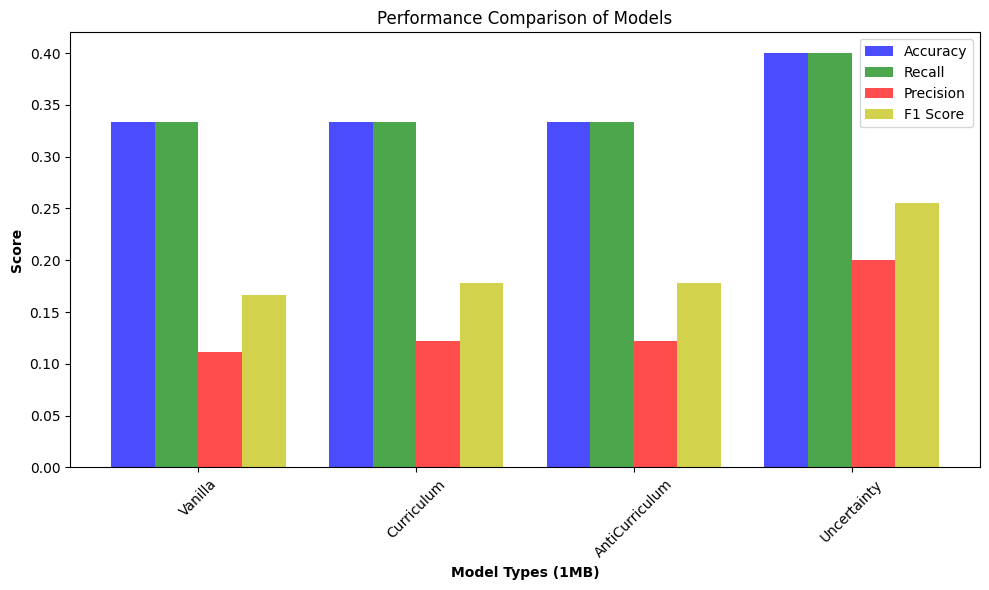


Evaluating Vanilla model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Vanilla Metrics: {'Accuracy': 0.0017699115044247787, 'Recall': 0.0017699115044247787, 'Precision': 1.5662933667475917e-05, 'F1': 3.105107902499612e-05}

Evaluating Curriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Curriculum Metrics: {'Accuracy': 0.0017699115044247787, 'Recall': 0.0017699115044247787, 'Precision': 1.5802781289506953e-05, 'F1': 3.1325867334951834e-05}

Evaluating AntiCurriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AntiCurriculum Metrics: {'Accuracy': 0.0017699115044247787, 'Recall': 0.0017699115044247787, 'Precision': 1.5662933667475917e-05, 'F1': 3.105107902499612e-05}

Evaluating Uncertainty model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Uncertainty Metrics: {'Accuracy': 0.0017699115044247787, 'Recall': 0.0017699115044247787, 'Precision': 1.5662933667475917e-05, 'F1': 3.105107902499612e-05}

Evaluating Vanilla model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Vanilla Metrics: {'Accuracy': 0.0035398230088495575, 'Recall': 0.0035398230088495575, 'Precision': 3.1325867334951834e-05, 'F1': 6.210215804999224e-05}

Evaluating Curriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Curriculum Metrics: {'Accuracy': 0.0035398230088495575, 'Recall': 0.0035398230088495575, 'Precision': 3.146571495698287e-05, 'F1': 6.237694635994795e-05}

Evaluating AntiCurriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AntiCurriculum Metrics: {'Accuracy': 0.0035398230088495575, 'Recall': 0.0035398230088495575, 'Precision': 3.1325867334951834e-05, 'F1': 6.210215804999224e-05}

Evaluating Uncertainty model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Uncertainty Metrics: {'Accuracy': 0.0035398230088495575, 'Recall': 0.0035398230088495575, 'Precision': 3.1325867334951834e-05, 'F1': 6.210215804999224e-05}

Evaluating Vanilla model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Vanilla Metrics: {'Accuracy': 0.007079646017699115, 'Recall': 0.007079646017699115, 'Precision': 9.437756973091653e-05, 'F1': 0.00018598519092208565}

Evaluating Curriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Curriculum Metrics: {'Accuracy': 0.005309734513274336, 'Recall': 0.005309734513274336, 'Precision': 4.712864862445879e-05, 'F1': 9.342802538494407e-05}

Evaluating AntiCurriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AntiCurriculum Metrics: {'Accuracy': 0.007079646017699115, 'Recall': 0.007079646017699115, 'Precision': 9.39776020048555e-05, 'F1': 0.0001852264366186725}

Evaluating Uncertainty model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Uncertainty Metrics: {'Accuracy': 0.005309734513274336, 'Recall': 0.005309734513274336, 'Precision': 4.698880100242775e-05, 'F1': 9.315323707498836e-05}

Evaluating Vanilla model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Vanilla Metrics: {'Accuracy': 0.008849557522123894, 'Recall': 0.008849557522123894, 'Precision': 0.0001132064155226695, 'F1': 0.000223246485752081}

Evaluating Curriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Curriculum Metrics: {'Accuracy': 0.007079646017699115, 'Recall': 0.007079646017699115, 'Precision': 6.279158229193471e-05, 'F1': 0.00012447910440994018}

Evaluating AntiCurriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AntiCurriculum Metrics: {'Accuracy': 0.008849557522123894, 'Recall': 0.008849557522123894, 'Precision': 0.00010964053567233142, 'F1': 0.00021627751564366862}

Evaluating Uncertainty model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Uncertainty Metrics: {'Accuracy': 0.007079646017699115, 'Recall': 0.007079646017699115, 'Precision': 6.265173466990367e-05, 'F1': 0.00012420431609998448}

Evaluating Vanilla model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Vanilla Metrics: {'Accuracy': 0.010619469026548672, 'Recall': 0.010619469026548672, 'Precision': 0.00012900919681217644, 'F1': 0.0002545723530870328}

Evaluating Curriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Curriculum Metrics: {'Accuracy': 0.008849557522123894, 'Recall': 0.008849557522123894, 'Precision': 7.845451595941063e-05, 'F1': 0.0001555301834349363}

Evaluating AntiCurriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AntiCurriculum Metrics: {'Accuracy': 0.010619469026548672, 'Recall': 0.010619469026548672, 'Precision': 0.00012530346933980734, 'F1': 0.00024732859466866473}

Evaluating Uncertainty model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Uncertainty Metrics: {'Accuracy': 0.008849557522123894, 'Recall': 0.008849557522123894, 'Precision': 7.831466833737959e-05, 'F1': 0.0001552553951249806}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


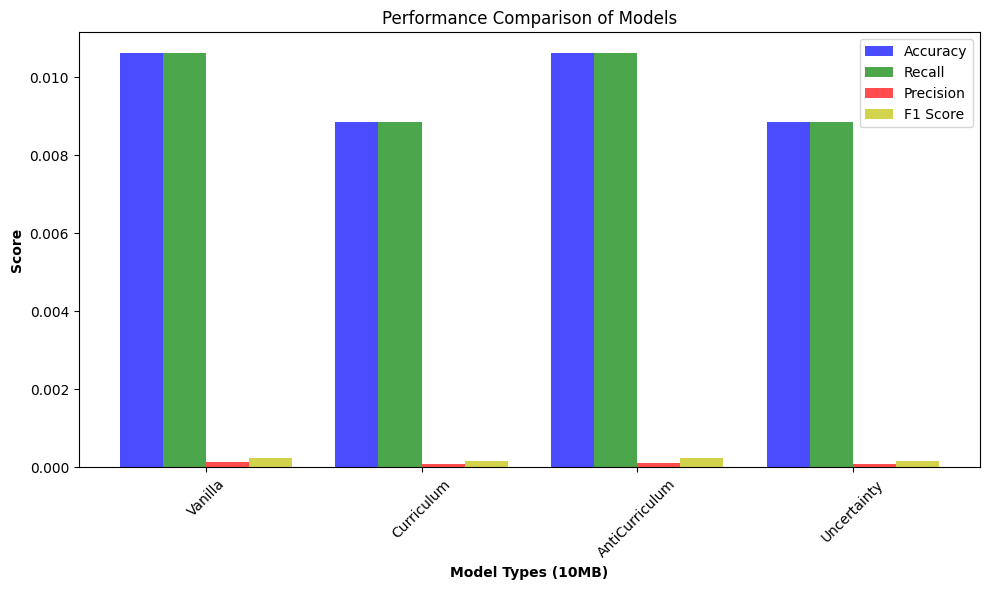


Evaluating Vanilla model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Vanilla Metrics: {'Accuracy': 0.00017905102954341988, 'Recall': 0.00017905102954341988, 'Precision': 1.6043999063030455e-07, 'F1': 3.2059271180558617e-07}

Evaluating Curriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Curriculum Metrics: {'Accuracy': 0.00035810205908683976, 'Recall': 0.00035810205908683976, 'Precision': 6.411854236111723e-07, 'F1': 1.280078852857336e-06}

Evaluating AntiCurriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AntiCurriculum Metrics: {'Accuracy': 0.00017905102954341988, 'Recall': 0.00017905102954341988, 'Precision': 1.6029635590279309e-07, 'F1': 3.2030595624940947e-07}

Evaluating Uncertainty model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Uncertainty Metrics: {'Accuracy': 0.00017905102954341988, 'Recall': 0.00017905102954341988, 'Precision': 1.6029635590279309e-07, 'F1': 3.2030595624940947e-07}

Evaluating Vanilla model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Vanilla Metrics: {'Accuracy': 0.00035810205908683976, 'Recall': 0.00035810205908683976, 'Precision': 3.2073634653309763e-07, 'F1': 6.408986680549956e-07}

Evaluating Curriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Curriculum Metrics: {'Accuracy': 0.0005371530886302597, 'Recall': 0.0005371530886302597, 'Precision': 8.094664664151384e-07, 'F1': 1.616324917727608e-06}

Evaluating AntiCurriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AntiCurriculum Metrics: {'Accuracy': 0.0005371530886302597, 'Recall': 0.0005371530886302597, 'Precision': 8.014817795139655e-07, 'F1': 1.6003848091067454e-06}

Evaluating Uncertainty model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Uncertainty Metrics: {'Accuracy': 0.00035810205908683976, 'Recall': 0.00035810205908683976, 'Precision': 3.2059271180558617e-07, 'F1': 6.406119124988189e-07}

Evaluating Vanilla model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Vanilla Metrics: {'Accuracy': 0.0005371530886302597, 'Recall': 0.0005371530886302597, 'Precision': 4.810327024358907e-07, 'F1': 9.61204624304405e-07}

Evaluating Curriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Curriculum Metrics: {'Accuracy': 0.0007162041181736795, 'Recall': 0.0007162041181736795, 'Precision': 9.697628223179315e-07, 'F1': 1.9366308739770177e-06}

Evaluating AntiCurriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AntiCurriculum Metrics: {'Accuracy': 0.0007162041181736795, 'Recall': 0.0007162041181736795, 'Precision': 9.617781354167585e-07, 'F1': 1.920690765356155e-06}

Evaluating Uncertainty model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Uncertainty Metrics: {'Accuracy': 0.0005371530886302597, 'Recall': 0.0005371530886302597, 'Precision': 4.808890677083792e-07, 'F1': 9.609178687482285e-07}

Evaluating Vanilla model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Vanilla Metrics: {'Accuracy': 0.0007162041181736795, 'Recall': 0.0007162041181736795, 'Precision': 6.449988467064218e-07, 'F1': 1.2888368833042584e-06}

Evaluating Curriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Curriculum Metrics: {'Accuracy': 0.0008952551477170994, 'Recall': 0.0008952551477170994, 'Precision': 1.1300591782207246e-06, 'F1': 2.256936830226427e-06}

Evaluating AntiCurriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AntiCurriculum Metrics: {'Accuracy': 0.0010743061772605193, 'Recall': 0.0010743061772605193, 'Precision': 1.6029635590279307e-06, 'F1': 3.200769618213491e-06}

Evaluating Uncertainty model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Uncertainty Metrics: {'Accuracy': 0.0007162041181736795, 'Recall': 0.0007162041181736795, 'Precision': 6.59049296109792e-07, 'F1': 1.3168841302659619e-06}

Evaluating Vanilla model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Vanilla Metrics: {'Accuracy': 0.0010743061772605193, 'Recall': 0.0010743061772605193, 'Precision': 1.3818343592307835e-06, 'F1': 2.759481889821054e-06}

Evaluating Curriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Curriculum Metrics: {'Accuracy': 0.0010743061772605193, 'Recall': 0.0010743061772605193, 'Precision': 1.2903555341235178e-06, 'F1': 2.5772427864758365e-06}

Evaluating AntiCurriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AntiCurriculum Metrics: {'Accuracy': 0.0012533572068039393, 'Recall': 0.0012533572068039393, 'Precision': 1.7632599149307238e-06, 'F1': 3.5210755744629003e-06}

Evaluating Uncertainty model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Uncertainty Metrics: {'Accuracy': 0.0008952551477170994, 'Recall': 0.0008952551477170994, 'Precision': 8.193456520125852e-07, 'F1': 1.6371900865153713e-06}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


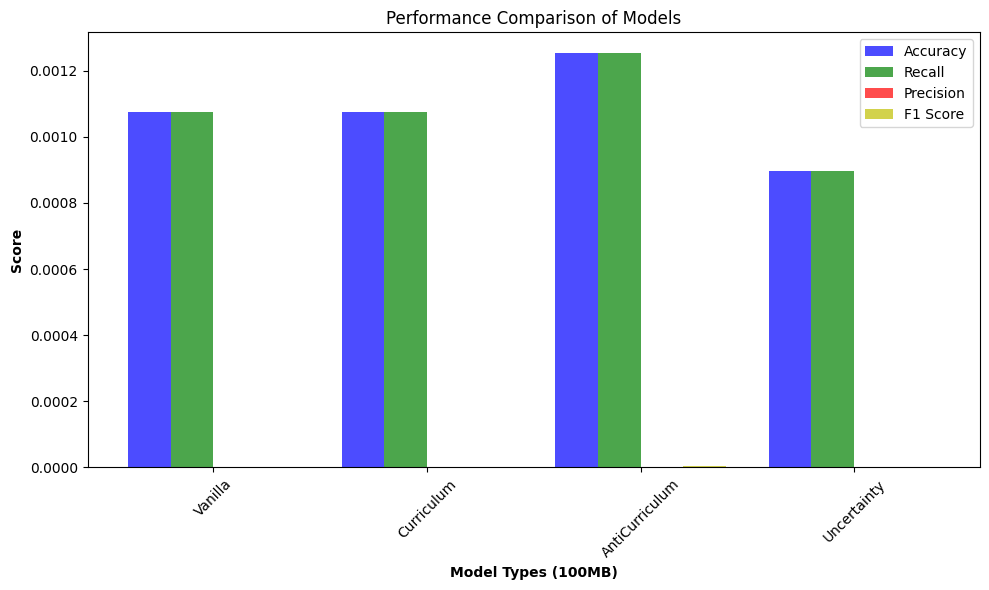


Evaluating Vanilla model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Vanilla Metrics: {'Accuracy': 6.858710562414265e-05, 'Recall': 6.858710562414265e-05, 'Precision': 2.3520955289486508e-08, 'F1': 4.70257837669816e-08}

Evaluating Curriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Curriculum Metrics: {'Accuracy': 6.858710562414265e-05, 'Recall': 6.858710562414265e-05, 'Precision': 2.429582204185004e-08, 'F1': 4.857443741086591e-08}

Evaluating AntiCurriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AntiCurriculum Metrics: {'Accuracy': 6.858710562414265e-05, 'Recall': 6.858710562414265e-05, 'Precision': 2.468049860530502e-08, 'F1': 4.9343241456217744e-08}

Evaluating Uncertainty model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Uncertainty Metrics: {'Accuracy': 0.000205761316872428, 'Recall': 0.000205761316872428, 'Precision': 2.116885976053786e-07, 'F1': 4.229420696247236e-07}

Evaluating Vanilla model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Vanilla Metrics: {'Accuracy': 0.0003429355281207132, 'Recall': 0.0003429355281207132, 'Precision': 1.8247387437738958e-06, 'F1': 3.610854462248342e-06}

Evaluating Curriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Curriculum Metrics: {'Accuracy': 0.00020576131687242795, 'Recall': 0.00020576131687242795, 'Precision': 1.2069372172441175e-07, 'F1': 2.412348464674464e-07}

Evaluating AntiCurriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AntiCurriculum Metrics: {'Accuracy': 0.00027434842249657066, 'Recall': 0.00027434842249657066, 'Precision': 6.535738674864644e-07, 'F1': 1.3023624307528023e-06}

Evaluating Uncertainty model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Uncertainty Metrics: {'Accuracy': 0.00027434842249657066, 'Recall': 0.00027434842249657066, 'Precision': 2.3520955289486513e-07, 'F1': 4.6996785339170516e-07}

Evaluating Vanilla model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Vanilla Metrics: {'Accuracy': 0.0005486968449931412, 'Recall': 0.0005486968449931412, 'Precision': 2.038405739487736e-06, 'F1': 4.037745161153794e-06}

Evaluating Curriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Curriculum Metrics: {'Accuracy': 0.0003429355281207132, 'Recall': 0.0003429355281207132, 'Precision': 4.3729008174817816e-07, 'F1': 8.721164428987479e-07}

Evaluating AntiCurriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AntiCurriculum Metrics: {'Accuracy': 0.0004801097393689987, 'Recall': 0.0004801097393689987, 'Precision': 1.3167924004143552e-06, 'F1': 2.6236166618155343e-06}

Evaluating Uncertainty model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Uncertainty Metrics: {'Accuracy': 0.0005486968449931412, 'Recall': 0.0005486968449931412, 'Precision': 6.115448375266492e-07, 'F1': 1.2216073670809397e-06}

Evaluating Vanilla model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Vanilla Metrics: {'Accuracy': 0.0006858710562414265, 'Recall': 0.0006858710562414265, 'Precision': 2.13343463539926e-06, 'F1': 4.2276713795660965e-06}

Evaluating Curriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Curriculum Metrics: {'Accuracy': 0.00048010973936899853, 'Recall': 0.00048010973936899853, 'Precision': 5.395444322873397e-07, 'F1': 1.0764728097490799e-06}

Evaluating AntiCurriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AntiCurriculum Metrics: {'Accuracy': 0.000617283950617284, 'Recall': 0.000617283950617284, 'Precision': 1.703573865746738e-06, 'F1': 3.39357657685981e-06}

Evaluating Uncertainty model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Uncertainty Metrics: {'Accuracy': 0.0007544581618655692, 'Recall': 0.0007544581618655692, 'Precision': 8.232334351320278e-07, 'F1': 1.6445494367056634e-06}

Evaluating Vanilla model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Vanilla Metrics: {'Accuracy': 0.0007544581618655691, 'Recall': 0.0007544581618655691, 'Precision': 2.20352876480564e-06, 'F1': 4.367716516113606e-06}

Evaluating Curriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Curriculum Metrics: {'Accuracy': 0.0005486968449931412, 'Recall': 0.0005486968449931412, 'Precision': 5.650130938633303e-07, 'F1': 1.1273912252087255e-06}

Evaluating AntiCurriculum model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AntiCurriculum Metrics: {'Accuracy': 0.000617283950617284, 'Recall': 0.000617283950617284, 'Precision': 1.703573865746738e-06, 'F1': 3.39357657685981e-06}

Evaluating Uncertainty model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Uncertainty Metrics: {'Accuracy': 0.0008230452674897118, 'Recall': 0.0008230452674897118, 'Precision': 8.467543904215143e-07, 'F1': 1.691575220472645e-06}


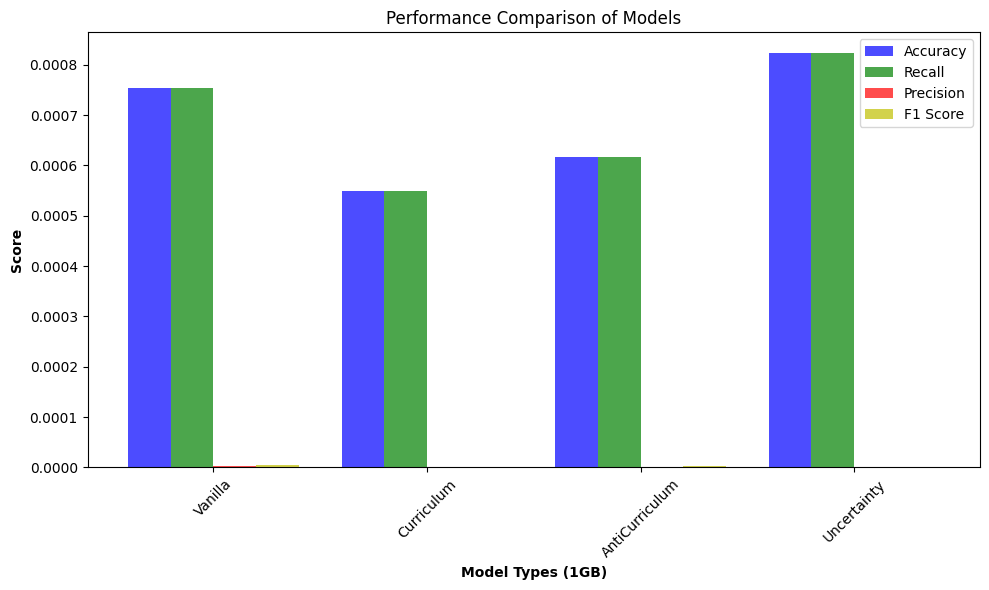

In [ ]:
import torch
import torch.nn.functional as F  # Ensure F is imported
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import ViTForImageClassification
from torch import optim
import gc

# Ensure create_dataloader, preprocessed_training_files, preprocessed_validation_files, and all_labels are defined


def train_model(model, train_loader, optimizer, num_epochs=3, device="cuda"):
    model.train()  # Enable training mode
    loss_history = []
    for epoch in range(num_epochs):
        total_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).logits
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        epoch_avg_loss = total_loss / len(train_loader)
        loss_history.append(epoch_avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_avg_loss:.4f}")
    return loss_history


# Create your training DataLoader for your downstream task.
train_loader = create_dataloader(preprocessed_training_files["df_1MB_train"], batch_size=50)

# (If you have, say, 3 classes for birds, set num_labels=3)
num_classes = len(all_labels)  # Ensure all_labels contains the correct class labels
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=5e-5)

# Train the model and save the fine-tuned checkpoint.
loss_history = train_model(model, train_loader, optimizer, num_epochs=3, device=device)
torch.save(model.state_dict(), "/content/fine_tuned_vit_model.pth")
gc.collect()
torch.cuda.empty_cache()


def evaluate_and_plot(num_samples, model_paths, name, val_loaders, device="cuda"):
    metrics_data = {}  # Dictionary to store metrics

    for _ in range(num_samples):
        for model_type, model_path in model_paths.items():
            print(f"\nEvaluating {model_type} model...")

            # Load the checkpoint using the proper device mapping.
            checkpoint = torch.load(model_path, map_location=device)

            # Remove classifier parameters if they exist to avoid shape mismatches.
            for key in ["classifier.weight", "classifier.bias"]:
                if key in checkpoint:
                    del checkpoint[key]

            # Infer the number of classes dynamically from the validation loader.
            val_loader = val_loaders[model_type]
            all_labels_set = set()
            for _, labels in val_loader:
                # Convert tensor labels to a Python list before updating the set.
                all_labels_set.update(labels.cpu().numpy().tolist())
            num_labels = len(all_labels_set)
            if num_labels == 0:
                raise ValueError(f"No labels found in val_loader for {model_type}")

            # Load the model with the correct number of labels.
            model = ViTForImageClassification.from_pretrained(
                "google/vit-base-patch16-224-in21k", num_labels=num_labels
            )
            model.load_state_dict(checkpoint, strict=False)
            model.to(device)
            model.eval()

            all_preds = []
            all_true = []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs = inputs.to(device)
                    outputs = model(inputs).logits
                    preds = torch.argmax(outputs, dim=1).cpu().numpy()
                    all_preds.extend(preds.tolist())
                    all_true.extend(labels.cpu().numpy().tolist())

            # Calculate metrics (using weighted averages)
            accuracy = accuracy_score(all_true, all_preds)
            recall = recall_score(all_true, all_preds, average="weighted")
            precision = precision_score(all_true, all_preds, average="weighted")
            f1 = f1_score(all_true, all_preds, average="weighted")

            metrics_prev = metrics_data.get(
                model_type,
                {
                    "Accuracy": 0.0,
                    "Recall": 0.0,
                    "Precision": 0.0,
                    "F1": 0.0,
                },
            )
            metrics_prev["Accuracy"] += accuracy / num_samples
            metrics_prev["Recall"] += recall / num_samples
            metrics_prev["Precision"] += precision / num_samples
            metrics_prev["F1"] += f1 / num_samples
            metrics_data[model_type] = metrics_prev
            print(f"{model_type} Metrics: {metrics_data[model_type]}")

    # Plot the metrics.
    plot_metrics(name, metrics_data)


def plot_metrics(name, metrics_data):
    # Extract model names and corresponding metric values.
    model_names = list(metrics_data.keys())
    accuracies = [metrics_data[model]["Accuracy"] for model in model_names]
    recalls = [metrics_data[model]["Recall"] for model in model_names]
    precisions = [metrics_data[model]["Precision"] for model in model_names]
    f1_scores = [metrics_data[model]["F1"] for model in model_names]

    # Bar chart settings: positions and width.
    bar_width = 0.2
    indices = np.arange(len(model_names))

    plt.figure(figsize=(10, 6))
    plt.bar(indices, accuracies, width=bar_width, label="Accuracy", color="b", alpha=0.7)
    plt.bar(indices + bar_width, recalls, width=bar_width, label="Recall", color="g", alpha=0.7)
    plt.bar(indices + 2 * bar_width, precisions, width=bar_width, label="Precision", color="r", alpha=0.7)
    plt.bar(indices + 3 * bar_width, f1_scores, width=bar_width, label="F1 Score", color="y", alpha=0.7)

    plt.xlabel(f"Model Types ({name})", fontweight="bold")
    plt.ylabel("Score", fontweight="bold")
    plt.title("Performance Comparison of Models")
    plt.xticks(indices + 1.5 * bar_width, model_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Example Usage ---
# Model paths structured across multiple training stages, now including uncertainty models
model_paths = [
    {
        "Vanilla": f"/content/vit_model_stage{i}.pth",
        "Curriculum": f"/content/vit_curriculum_model_stage{i}.pth",
        "AntiCurriculum": f"/content/vit_anticurriculum_model_stage{i}.pth",
        "Uncertainty": f"/content/vit_uncertainty_model_stage{i}.pth",
    }
    for i in range(1, 5)
]

batch_size = int(batch_size)
# Validation loaders structured across all datasets
val_loaders = [
    (
        k.split("_")[1],  # Extract dataset label (e.g., "1MB", "10MB")
        {
            "Vanilla": create_dataloader(v, batch_size=batch_size),
            "Curriculum": create_dataloader(v, batch_size=batch_size),
            "AntiCurriculum": create_dataloader(v, batch_size=batch_size),
            "Uncertainty": create_dataloader(v, batch_size=batch_size),
        },
    )
    for (k, v) in preprocessed_validation_files.items()
]

# Evaluate and plot for all models and datasets
_ = [evaluate_and_plot(5, mdl_pths, l, vls) for (mdl_pths, (l, vls)) in zip(model_paths, val_loaders)]
